In [4]:
### Validate the nichenet regulatory potential data by comparing with own data (e.g. cytokine-gene associations)
### Calculate correlations and check with nichenet regulatory potential

#############################################
# Prerequisites - Load Libraries

In [5]:
source('MS0_Libraries.r')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
   

In [19]:
source('MS4_Plot_Config.r')

###############################################
# Preqrequisites Configurations & Parameters

In [20]:
data_path = '../data/current'

In [21]:
result_path = '../results/current'

In [22]:
data_path

[1] "../data/current"

In [23]:
### Decide which data to load from F4_1

In [24]:
name = 'V_FINAL'  # of dataset to load, prepared and combined data of E1 - skip E2 step 

In [25]:
weight_views = FALSE

In [26]:
### Version of the pre-processed data to load

In [27]:
mofa_name = 'V_FINAL_INTEGRATED'

In [28]:
filter_samples = 'all'
#filter_samples = 'acs_w_o_infection_ccs'
#filter_samples = 'no_ccs_ccs'

# Load Data 

## Sample Data

In [29]:
#head(merged_data$CK,6)

In [30]:
#head(sample_data$CK, 5)

In [31]:
path = paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv')
sample_data = read.csv(path)
print(file.info(path)$mtime)

[1] "2022-06-16 14:38:20 CEST"


In [32]:
sample_data[(sample_data$sample_id == 'm6.4'),] 

X.1 sample_id sample id  measurement library id.y      name read
136 136 m6.4      M6     6.4 TP4         L14     HTO_B0259 6.4  R2  
137 137 m6.4      M6     6.4 TP4         L10     HTO_B0255 6.4  R2  
    pattern          ⋯ meta_data delta_ef_value_group delta_ef_value
136 5PNNNNNNNNNN(BC) ⋯ 1         x_smaller_1          0.875         
137 5PNNNNNNNNNN(BC) ⋯ 1         x_smaller_1          0.875         
    delta_ef_value_class ef_classification_data CK CK_MB Troponin CRP
136 intermediate         1                      59       0.458    1.3
137 intermediate         1                      59       0.458    1.3
    clinical_data
136 1            
137 1

In [33]:
sample_data$CK_raw = sample_data$CK

In [34]:
sample_data$CK = log2(sample_data$CK+1)

In [35]:
sample_data$Troponin = log2(sample_data$Troponin+1)

In [36]:
sample_data$CK_MB = log2(as.numeric(sample_data$CK_MB)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [37]:
sample_data$CRP =  log2(as.numeric(sample_data$CRP)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [38]:
sample_data$sample_id[(sample_data$sample_id == 'm13.2')  & (sample_data$library %in%  c('L6'))] = 'm13.22'

In [39]:
sample_data$sample_id[(sample_data$sample_id == 'm6.4')  & (sample_data$library %in%  c('L10'))] = 'm6.42'

In [40]:
sample_data$sample_id[(sample_data$sample_id == 'm6.1')  & (sample_data$library %in%  c('L3'))] = 'm6.12'

## Prepared combined data

In [41]:
### Select version to load -- differ based on aggregate level and steps taken for pre-processing (e.g. threshold for filtering out genes in single cell data based on expression in cells)

In [42]:
path = paste0(result_path, '/E-Analysis/Combined_Data_',name,'.csv')
data_long = read.csv(path)
print(path)
print(file.info(path)$mtime)

[1] "../results/current/E-Analysis/Combined_Data_V_FINAL.csv"
[1] "2023-01-18 13:50:32 CET"


In [43]:
head(data_long,2)

X sample_id type        variable             value    
1 1 k10       single_cell X0_T.cell.CD4__SSU72 0.5896835
2 2 k10       single_cell X0_T.cell.CD4__PARK7 0.8587511
  config                          
1 FALSE-FALSE-TRUE-0.2-FALSE-TRUE-
2 FALSE-FALSE-TRUE-0.2-FALSE-TRUE-

In [44]:
nrow(data_long)

[1] 1557939

In [45]:
#### Filter based on selected samples

In [46]:
if(filter_samples == 'all'){
    filter = unique(sample_data$sample_id)
    }


if(filter_samples == 'acs_w_o_infection_ccs'){
    filter =unique(sample_data$sample_id[sample_data$classification %in% c('ccs', 'acs_w_o_infection')])
    
    }

if(filter_samples == 'no_ccs_ccs'){
    filter =unique(sample_data$sample_id[sample_data$classification %in% c('vollstaendiger_ausschluss','ccs','koronarsklerose')])
    
    }

In [47]:
length(filter)

[1] 149

In [48]:
#filter

In [49]:
nrow(data_long)

[1] 1557939

In [50]:
data_long = data_long[data_long$sample_id %in% filter,]

In [51]:
nrow(data_long)

[1] 1557939

## Nichenet data

In [52]:
ligand_target_matrix = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))  # gene-gene regulatory scores
# gives the regulatory potential of a target gene based on the ligand-tf & tf- target-gene links and weights of the signaling and gr network (multiply PPR of each ligand -tf  pair with the weights of the gr network)

In [53]:
### Generate data in long format

In [54]:
ligand_target_matrix_long = melt(ligand_target_matrix)

In [55]:
colnames(ligand_target_matrix_long) = c('target', 'ligand', 'regulatory_potential')

In [56]:
head(ligand_target_matrix_long,2)

target   ligand regulatory_potential
1 A1BG     CXCL1  0.0003534343        
2 A1BG-AS1 CXCL1  0.0001650894

## Prepared expression and correlation data

In [57]:
name

[1] "V_FINAL"

In [58]:
load_path = paste0(result_path, '/F-Analysis/' ,'F4_Ligand_Receptor_Data_Expression', name,filter_samples, '.gz')
ligand_receptor_expression = fread(load_path)
print(load_path)
print(file.info(load_path)$mtime)

Warning message in fread(load_path):
“Detected 12 column names but the data has 13 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] "../results/current/F-Analysis/F4_Ligand_Receptor_Data_ExpressionV_FINALall.gz"
[1] "2023-01-18 18:48:54 CET"


In [59]:
head(ligand_receptor_expression,2)

V1 interaction_type gene   type        cluster            
1 1  Ligand           A2M    proteomics  proteomics         
2 2  Ligand           ADAM17 single_cell X4_Monocytes...CD14
  perc_cells_expressing_gene total_amount_cells_expressing_gene
1 69.10381                     NA                              
2 49.68889                   7267                              
  ident                                     mean_expr_norm mean_expr
1 proteomics_0_A2M_P01023                   0.86719027     8.7445302
2 single_cell_0_X4_Monocytes...CD14__ADAM17 0.09912111     0.8383966
  var_expression cell_type        cluster_vis
1 0.32468578     proteomics       NA         
2 0.03136488     Monocytes...CD14  5

In [60]:
load_path = paste0(result_path, '/F-Analysis/' ,'F4_Ligand_Receptor_Data', name,filter_samples, '.gz')
ligand_receptor_correlation = fread(load_path)
print(load_path)
print(file.info(load_path)$mtime)

Warning message in fread(load_path):
“Detected 29 column names but the data has 30 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] "../results/current/F-Analysis/F4_Ligand_Receptor_DataV_FINALall.gz"
[1] "2023-01-18 18:49:07 CET"


In [61]:
head(ligand_receptor_correlation,2)

V1 ident                   ident_R            Receptor Ligand amount_sources
1 1  cytokine_0_BCA1__CXCL13 neutrophil_0_CXCR4 CXCR4    CXCL13 1             
2 2  cytokine_0_BCA1__CXCL13 neutrophil_0_FPR2  FPR2     CXCL13 1             
  weight    interaction_type type     cluster  ⋯ cluster_R 
1 0.2788696 Ligand           cytokine cytokine ⋯ neutrophil
2 0.1930190 Ligand           cytokine cytokine ⋯ neutrophil
  perc_cells_expressing_gene_R total_amount_cells_expressing_gene_R
1 69.10381                     NA                                  
2 69.10381                     NA                                  
  mean_expr_norm_R mean_expr_R var_expression_R cell_type_R cluster_vis_R
1 0.4142467        3.484843    0.7122165        neutrophil   6           
2 0.3053243        2.568535    0.9156551        neutrophil  NA           
  variable_R         correlation
1 neutrophil_0_CXCR4 -0.1336829 
2 neutrophil_0_FPR2   0.1266091

In [62]:
load_path = paste0(result_path, '/F-Analysis/' ,'F4_Ligand_Target_Data', name,filter_samples, '.gz')
ligand_target_correlation = fread(load_path)
print(load_path)
print(file.info(load_path)$mtime)

Warning message in fread(load_path):
“Detected 12 column names but the data has 13 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] "../results/current/F-Analysis/F4_Ligand_Target_DataV_FINALall.gz"
[1] "2023-01-18 18:56:29 CET"


In [63]:
name

[1] "V_FINAL"

In [64]:
head(ligand_target_correlation,2)

V1 Ligand_Gene Target_Gene cluster   
1 1  ADAM17      A1BG        proteomics
2 2  ADAM17      A1BG        proteomics
  Ligand                                    Target                  
1 single_cell_0_X6_Monocytes...CD14__ADAM17 proteomics_0_A1BG_M0R009
2 single_cell_0_X4_Monocytes...CD14__ADAM17 proteomics_0_A1BG_M0R009
  correlation Target_Type Ligand_Type                      
1 -0.1841739  proteomics  single_cell_0_X6_Monocytes...CD14
2 -0.1387664  proteomics  single_cell_0_X4_Monocytes...CD14
  regulatory_potential regulatory_potential_scaled Target_Cell_Type
1 0.0004622894         0.01667641                  proteomics      
2 0.0004622894         0.01667641                  proteomics      
  Ligand_Cell_Type
1 Monocytes...CD14
2 Monocytes...CD14

In [65]:
###  Adjust to have nice cluster descriptions

In [66]:
ligand_target_correlation$Ligand_Cluster_Text = ligand_target_correlation$Ligand_Type
ligand_target_correlation$Target_Cluster_Text = ligand_target_correlation$Target_Type

In [67]:
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X0_T.cell.CD4', 'CD4+ T cells (Cluster 0)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'clinical_data', 'Clinical')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X1_T.cell.CD8', 'CD8+ T cells (Cluster 1)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X10_B.cell', 'B cells (Cluster 10)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X11_T.cell.CD4', 'CD4+ T cells (Cluster 11)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X12_Monocytes...CD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 12)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X13_Dendritic',  'Dendritic cells (Cluster 13)')
ligand_target_correlation$Ligand_Cluster_Text= str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X2_T.cell.CD4', 'CD4+ T cells (Cluster 2)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X3_NK', 'NK cells (Cluster 3)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X4_Monocytes...CD14', 'CD14(high) Monocytes (Cluster 4)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X5_T.cell.CD4', 'CD4+ T cells (Cluster 5)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X6_Monocytes...CD14','CD14(high) Monocytes (Cluster 6)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X7_Monocytes...CD14', 'CD14(high) Monocytes (Cluster 7)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X8_B.cell','B cells (Cluster 8)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X9_Monocytes...CD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')

ligand_target_correlation$Ligand_Cluster_Text  = str_replace(ligand_target_correlation$Ligand_Cluster_Text  , 'clinical','Clinical')
ligand_target_correlation$Ligand_Cluster_Text  = str_replace(ligand_target_correlation$Ligand_Cluster_Text  , 'cytokine','Cytokine')
ligand_target_correlation$Ligand_Cluster_Text  = str_replace(ligand_target_correlation$Ligand_Cluster_Text  , 'neutrophil','Neutrophil')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text  , 'proteomics','Proteomics')

In [68]:
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X0_T.cell.CD4', 'CD4+ T cells (Cluster 0)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'clinical_data', 'Clinical')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X1_T.cell.CD8', 'CD8+ T cells (Cluster 1)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X10_B.cell', 'B cells (Cluster 10)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X11_T.cell.CD4', 'CD4+ T cells (Cluster 11)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X12_Monocytes...CD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 12)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X13_Dendritic',  'Dendritic cells (Cluster 13)')
ligand_target_correlation$Target_Cluster_Text= str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X2_T.cell.CD4', 'CD4+ T cells (Cluster 2)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X3_NK', 'NK cells (Cluster 3)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X4_Monocytes...CD14', 'CD14(high) Monocytes (Cluster 4)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X5_T.cell.CD4', 'CD4+ T cells (Cluster 5)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X6_Monocytes...CD14','CD14(high) Monocytes (Cluster 6)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X7_Monocytes...CD14', 'CD14(high) Monocytes (Cluster 7)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X8_B.cell','B cells (Cluster 8)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X9_Monocytes...CD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')

ligand_target_correlation$Target_Cluster_Text  = str_replace(ligand_target_correlation$Target_Cluster_Text  , 'clinical','Clinical')
ligand_target_correlation$Target_Cluster_Text  = str_replace(ligand_target_correlation$Target_Cluster_Text  , 'cytokine','Cytokine')
ligand_target_correlation$Target_Cluster_Text  = str_replace(ligand_target_correlation$Target_Cluster_Text  , 'neutrophil','Neutrophil')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text  , 'proteomics','Proteomics')

In [69]:
unique(ligand_target_correlation$Ligand_Cluster_Text)

[1] "CD14(high) Monocytes (Cluster 6)"    "CD14(high) Monocytes (Cluster 4)"   
 [3] "Neutrophil"                          "CD4+ T cells (Cluster 0)"           
 [5] "CD8+ T cells (Cluster 1)"            "CD4+ T cells (Cluster 2)"           
 [7] "CD4+ T cells (Cluster 5)"            "Dendritic cells (Cluster 13)"       
 [9] "FCGR3A(high) Monocytes (Cluster 12)" "NK cells (Cluster 3)"               
[11] "CD14(high) Monocytes (Cluster 7)"    "FCGR3A(high) Monocytes (Cluster 9)" 
[13] "B cells (Cluster 10)"                "CD4+ T cells (Cluster 11)"          
[15] "B cells (Cluster 8)"                 "Cytokine"

In [70]:
unique(ligand_target_correlation$Target_Cluster_Text)

[1] "Proteomics"                          "FCGR3A(high) Monocytes (Cluster 12)"
 [3] "NK cells (Cluster 3)"                "CD4+ T cells (Cluster 5)"           
 [5] "CD8+ T cells (Cluster 1)"            "CD4+ T cells (Cluster 11)"          
 [7] "CD4+ T cells (Cluster 2)"            "CD4+ T cells (Cluster 0)"           
 [9] "B cells (Cluster 10)"                "Neutrophil"                         
[11] "FCGR3A(high) Monocytes (Cluster 9)"  "B cells (Cluster 8)"                
[13] "Dendritic cells (Cluster 13)"        "Clinical"                           
[15] "CD14(high) Monocytes (Cluster 4)"    "CD14(high) Monocytes (Cluster 6)"   
[17] "CD14(high) Monocytes (Cluster 7)"

In [71]:
### Extract cluster numbers

In [72]:
ligand_target_correlation$Ligand_Cluster_Number = str_replace_all(ligand_target_correlation$Ligand_Cluster_Text, '.*Cluster |\\)', '')
ligand_target_correlation$Target_Cluster_Number = str_replace_all(ligand_target_correlation$Target_Cluster_Text, '.*Cluster |\\)', '')

In [73]:
unique(ligand_target_correlation$Target_Cluster_Number)

[1] "Proteomics" "12"         "3"          "5"          "1"         
 [6] "11"         "2"          "0"          "10"         "Neutrophil"
[11] "9"          "8"          "13"         "Clinical"   "4"         
[16] "6"          "7"

In [74]:
### Extract Cell-Types without Cluster

In [75]:
ligand_target_correlation$Ligand_Cell_Type = str_replace_all(ligand_target_correlation$Ligand_Cluster_Text, ' \\(Cluster.*', '')
ligand_target_correlation$Target_Cell_Type = str_replace_all(ligand_target_correlation$Target_Cluster_Text, ' \\(Cluster.*', '')

In [76]:
unique(ligand_target_correlation$Ligand_Cell_Type )

[1] "CD14(high) Monocytes"   "Neutrophil"             "CD4+ T cells"          
[4] "CD8+ T cells"           "Dendritic cells"        "FCGR3A(high) Monocytes"
[7] "NK cells"               "B cells"                "Cytokine"

## Load MOFA model and extract weight data

In [77]:
model_name = paste0("MOFA_MODEL", mofa_name, '-', weight_views, '.hdf5')

In [78]:
model_name

#  old: 'MOFA_Model_26_02V20_Duplicates-FALSE-TRUE-TRUE.hdf5'

[1] "MOFA_MODELV_FINAL_INTEGRATED-FALSE.hdf5"

In [79]:
outfile = file.path( paste0(result_path, '/E-Analysis/',  model_name) )

In [80]:
print(file.info(outfile)$mtime)

[1] "2023-01-03 09:39:39 CET"


In [81]:
outfile

[1] "../results/current/E-Analysis/MOFA_MODELV_FINAL_INTEGRATED-FALSE.hdf5"

In [82]:
model <- load_model(outfile)

Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 9, 12, 17 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


In [83]:
weights = get_weights(model, views = "all", factors = "all")

In [84]:
weight_data = data.frame()

In [85]:
for (i in names(weights)){
    data = data.frame(weights[[i]])
    data$type = i
    weight_data = rbind(weight_data,data)
    }

In [86]:
weight_data$variable_name = rownames(weight_data)

In [87]:
head(weight_data,2)

Factor1     Factor2   Factor3    Factor4      Factor5    Factor6   
CK    -0.13418597 0.4019222 -0.1010765 -0.002177566 -0.5093667 0.24179134
CK_MB -0.06222621 0.2731985 -0.2000362 -0.076098327 -0.1439445 0.04289833
      Factor7     Factor8    Factor9       Factor10     ⋯ Factor13  
CK    -0.03635097 0.05304519  0.0011574664 -0.012307130 ⋯ -0.1604505
CK_MB -0.71818597 0.18658970 -0.0007753517 -0.003074308 ⋯ -0.6107162
      Factor14     Factor15  Factor16     Factor17    Factor18    Factor19     
CK    -0.001418618 0.1540945  0.003821864 -0.24205661 0.004092582 -0.0005618720
CK_MB  0.002499494 0.3864464 -0.001090137 -0.08311704 0.009503498 -0.0003621744
      Factor20   type          variable_name
CK    -0.2423944 clinical_data CK           
CK_MB  0.2060158 clinical_data CK_MB

In [88]:
### Prepare feature weight in long format

In [89]:
feature_weights = weight_data

In [90]:
feature_weights$type_cluster = weight_data$type

In [91]:
feature_weights$type[!feature_weights$type %in% c('clinical_data', 'cytokine', 'neutrophil', 'proteomics')] = 'single_cell'

In [92]:
feature_weights$variable_name_conc = paste0(feature_weights$type, '_0_', feature_weights$variable_name)

In [93]:
feature_weights_long = melt(feature_weights) #TBD: put in a seperate 'chapter'

Using type, variable_name, type_cluster, variable_name_conc as id variables



In [94]:
head(feature_weights_long,2)

type          variable_name type_cluster  variable_name_conc    variable
1 clinical_data CK            clinical_data clinical_data_0_CK    Factor1 
2 clinical_data CK_MB         clinical_data clinical_data_0_CK_MB Factor1 
  value      
1 -0.13418597
2 -0.06222621

In [95]:
### based on feature - weights long calculate amount of features per dimension

In [96]:
amount_features_per_dimension = feature_weights_long[feature_weights_long$variable == 'Factor1',] %>% group_by(type_cluster) %>% count()

In [97]:
colnames(amount_features_per_dimension) = c('type_cluster', 'amount_features')

In [98]:
head(amount_features_per_dimension,2)

type_cluster  amount_features
1 clinical_data  4             
2 cytokine      65

In [99]:
amount_features_per_dimension = merge(amount_features_per_dimension, amount_features_per_dimension, by = NULL)

In [100]:
amount_features_per_dimension$combined_amount = amount_features_per_dimension$amount_features.x * amount_features_per_dimension$amount_features.y

In [101]:
amount_features_per_dimension$amount_features.y = NULL
amount_features_per_dimension$amount_features.x = NULL

In [102]:
colnames(amount_features_per_dimension) = c('Ligand_Type', 'Target_Type', 'combined_amount_features')

# Visualize Expression Data

In [270]:
head(ligand_receptor_expression,2)

V1 interaction_type gene   type        cluster            
1 1  Ligand           A2M    proteomics  proteomics         
2 2  Ligand           ADAM17 single_cell X4_Monocytes...CD14
  perc_cells_expressing_gene total_amount_cells_expressing_gene
1 69.10381                     NA                              
2 49.68889                   7267                              
  ident                                     mean_expr_norm mean_expr
1 proteomics_0_A2M_P01023                   0.86719027     8.7445302
2 single_cell_0_X4_Monocytes...CD14__ADAM17 0.09912111     0.8383966
  var_expression cell_type        cluster_vis
1 0.32468578     proteomics       NA         
2 0.03136488     Monocytes...CD14  1

In [271]:
plot_data = ligand_receptor_expression

In [272]:
plot_data$cluster_number = str_replace_all(plot_data$cluster, 'X|_.*', '')

In [273]:
unique(plot_data$cluster_number)

[1] "proteomics" "4"          "6"          "neutrophil" "13"        
 [6] "7"          "5"          "3"          "11"         "0"         
[11] "9"          "2"          "10"         "12"         "1"         
[16] "8"          "cytokine"

In [274]:
### Filter for visualization (minimum amount of cell expressing gene)

In [275]:
perc_cells_expressing_gene_var = 50

In [276]:
filter_type_vis = c('proteomics', 'cytokine', 'neutrophil')

In [277]:
#unique(plot_data$perc_cells_expressing_gene)

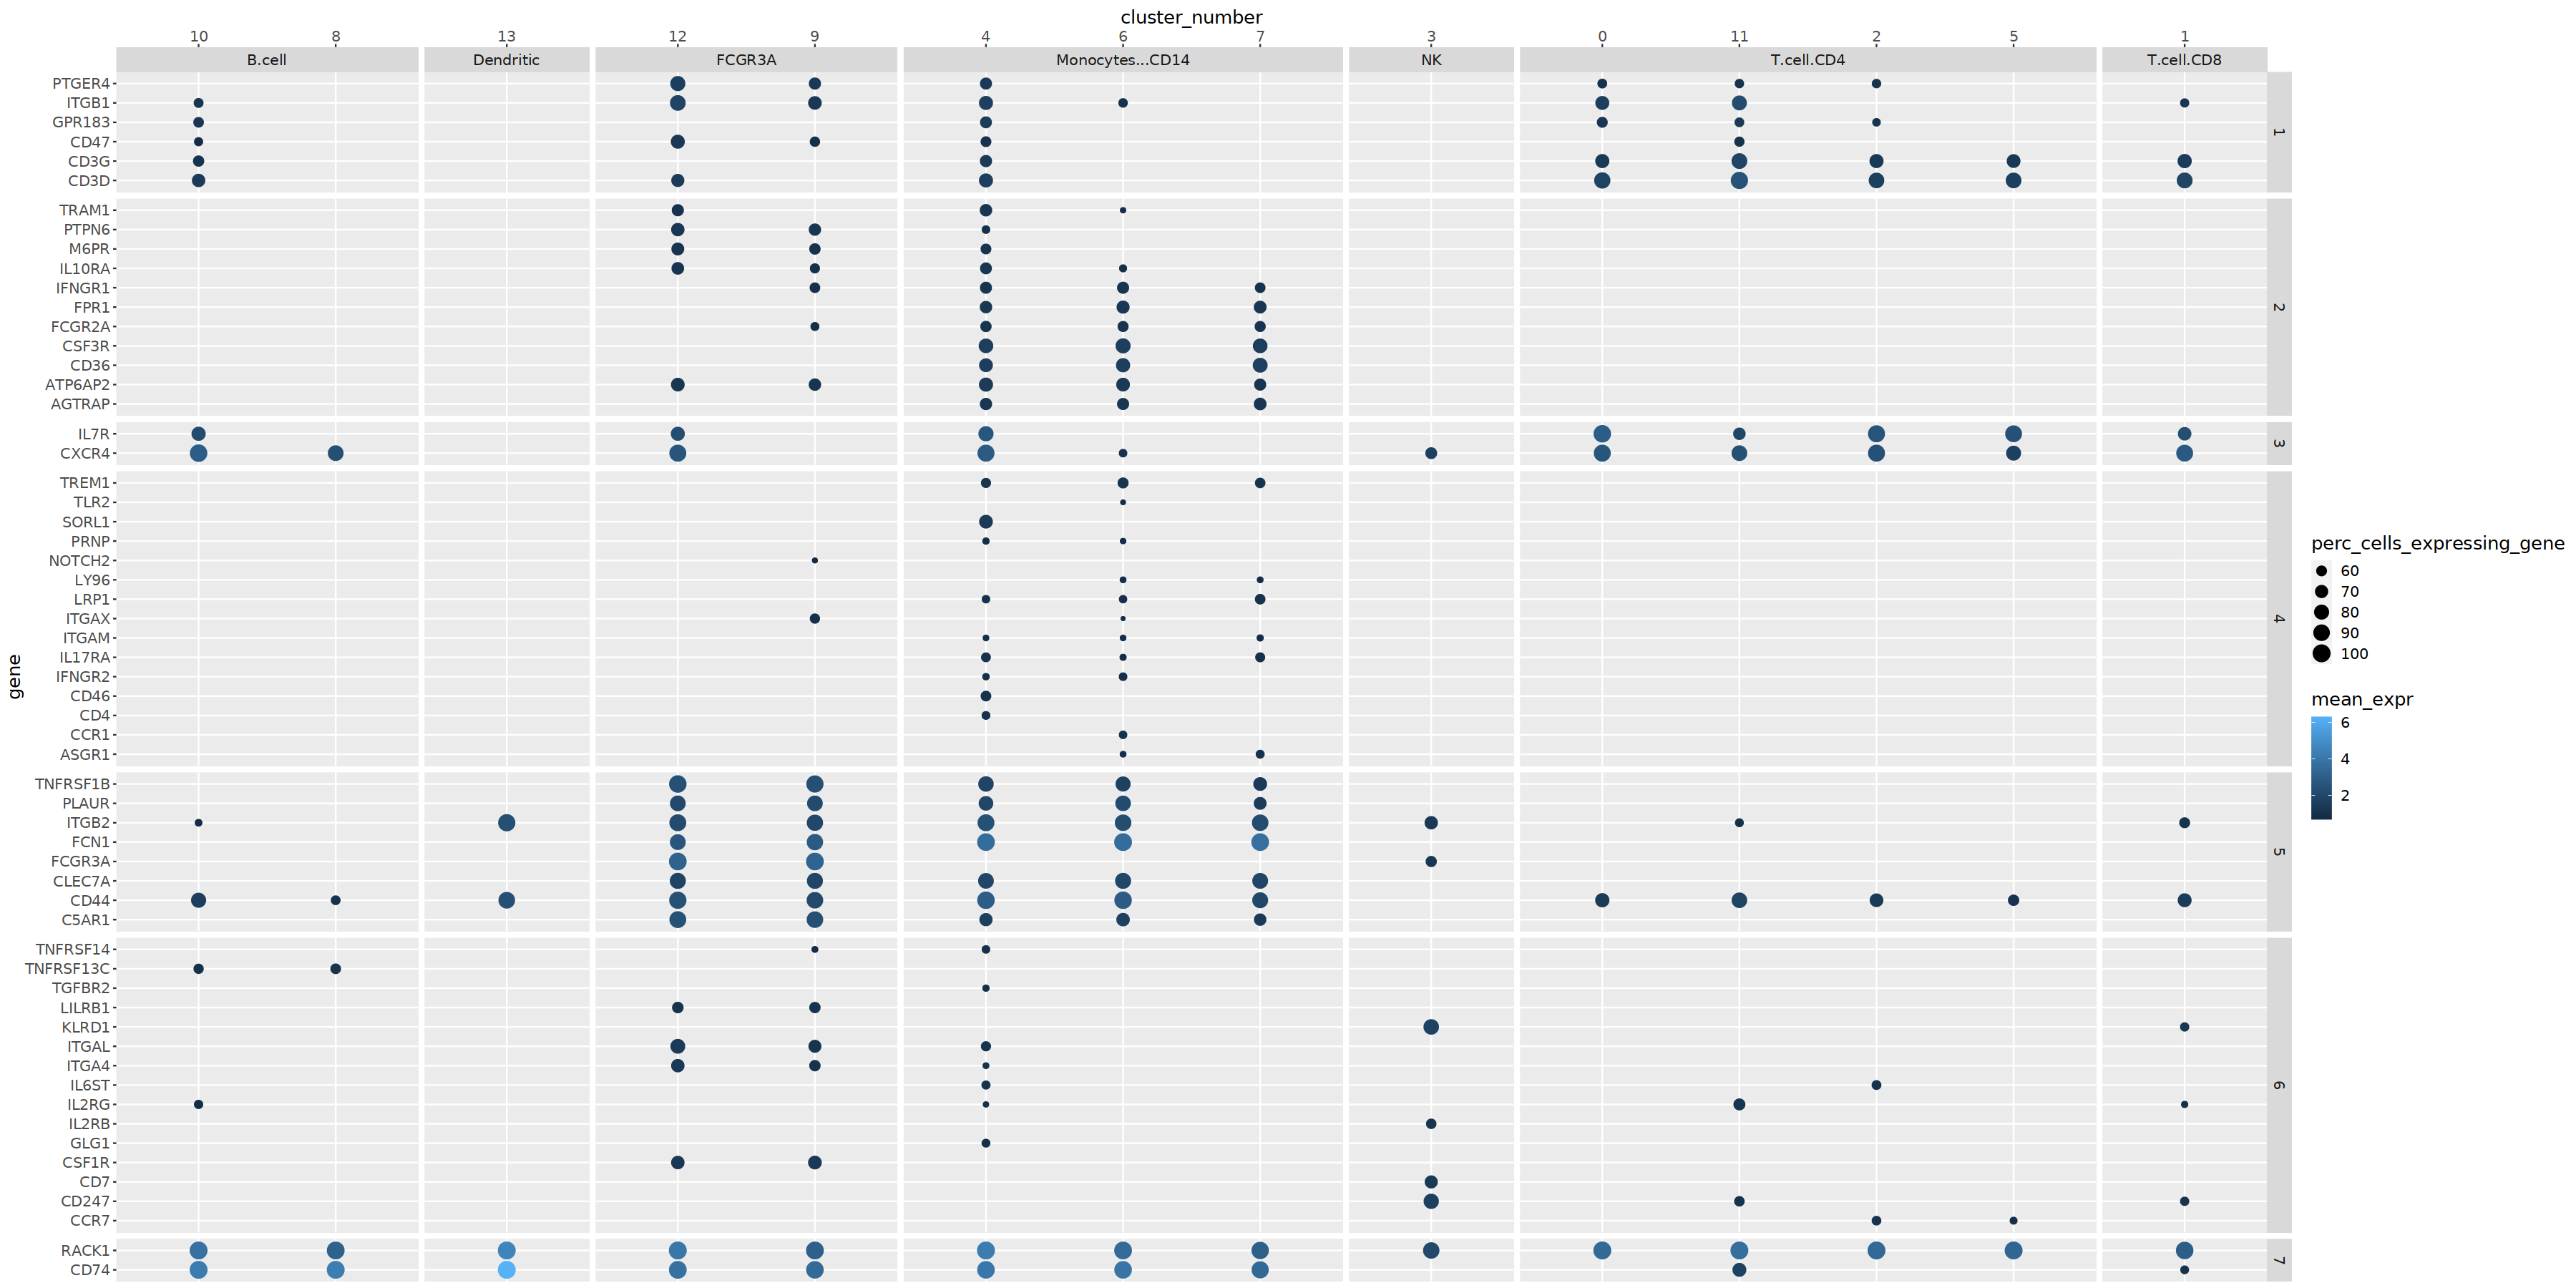

In [278]:
### Visualize all receptors
options(repr.plot.width=30, repr.plot.height=15)
ggplot(plot_data[(plot_data$interaction_type == 'Receptor') & (!plot_data$type %in% filter_type_vis) & (plot_data$perc_cells_expressing_gene > perc_cells_expressing_gene_var),], aes(x = cluster_number, y= gene)) + geom_point(aes(col=mean_expr, size=perc_cells_expressing_gene))  + facet_grid(cluster_vis~cell_type , space = 'free' , scales = 'free')  + theme(text = element_text(size=15), axis.text.x=element_text(angle=0)) + scale_x_discrete(position = "top") 

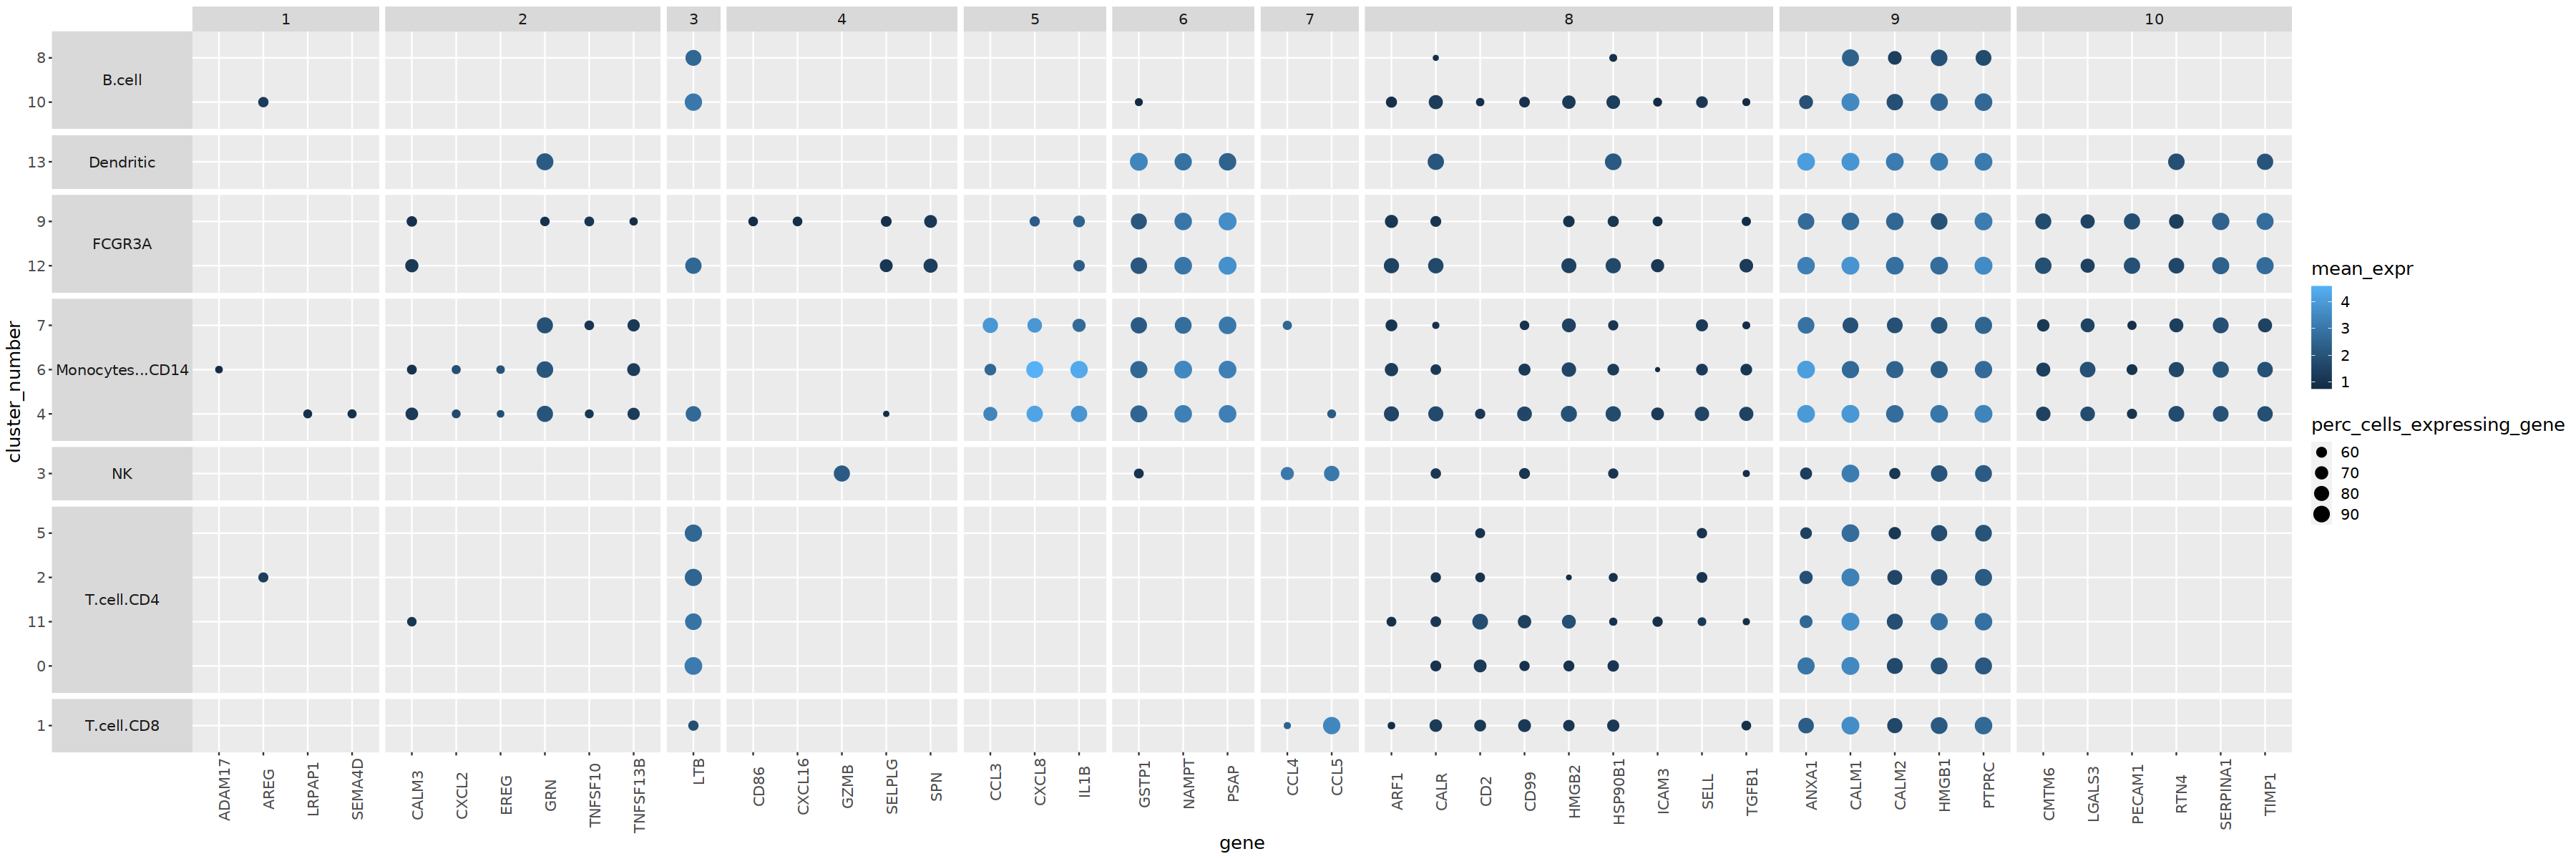

In [279]:
###  Visualize all ligands
options(repr.plot.width=30, repr.plot.height=10)
ggplot(plot_data[(plot_data$interaction_type == 'Ligand' & (!plot_data$type %in% filter_type_vis)) &  (plot_data$perc_cells_expressing_gene > perc_cells_expressing_gene_var) ,], aes(x = gene, y= cluster_number)) + geom_point(aes(col=mean_expr, size=perc_cells_expressing_gene)) + facet_grid(cell_type ~cluster_vis, space = 'free' , scales = 'free', switch = 'y')  + theme(text = element_text(size=15), axis.text.x=element_text(angle=90), strip.text.y.left = element_text(angle = 0)) 

# Visualize Ligand Receptor Correlations

### Heatmap visualization: expressions and correlation

#### Ligand Receptor expression 

In [466]:
head(data,2)

ident                   ident_R            Receptor Ligand amount_sources
1 cytokine_0_BCA1__CXCL13 neutrophil_0_CXCR4 CXCR4    CXCL13 1             
2 cytokine_0_BCA1__CXCL13 neutrophil_0_FPR2  FPR2     CXCL13 1             
  weight    interaction_type type     cluster  perc_cells_expressing_gene ⋯
1 0.2788696 Ligand           cytokine cytokine 41.34211                   ⋯
2 0.1930190 Ligand           cytokine cytokine 41.34211                   ⋯
  mean_expr_R var_expression_R cell_type_R cluster_vis_R cluster_number_R
1 3.484843    0.7122165        neutrophil  4             NA              
2 2.568535    0.9156551        neutrophil  3             NA              
  variable_R         interaction_score correlation
1 neutrophil_0_CXCR4 0.03480850        -0.1336829 
2 neutrophil_0_FPR2  0.01775768         0.1266091 
  correlation_weight_interaction correlation_weight_expression_interaction
1 -0.03728011                    -0.004653302                             
2  0.02443796                     0.002248284

In [468]:
#### Visualize interaction score based on weight and expression

In [469]:
filter_type_vis

[1] "cytokine"   "neutrophil" "proteomics"

In [470]:
# exclude dimension for which no real expression value
data_vis = data[(!data$type %in% filter_type_vis) & (!data$type_R %in% filter_type_vis),]

In [471]:
# only show top 200 scores
data_vis = head(data_vis[order(data_vis$interaction_score, decreasing = TRUE),],200)

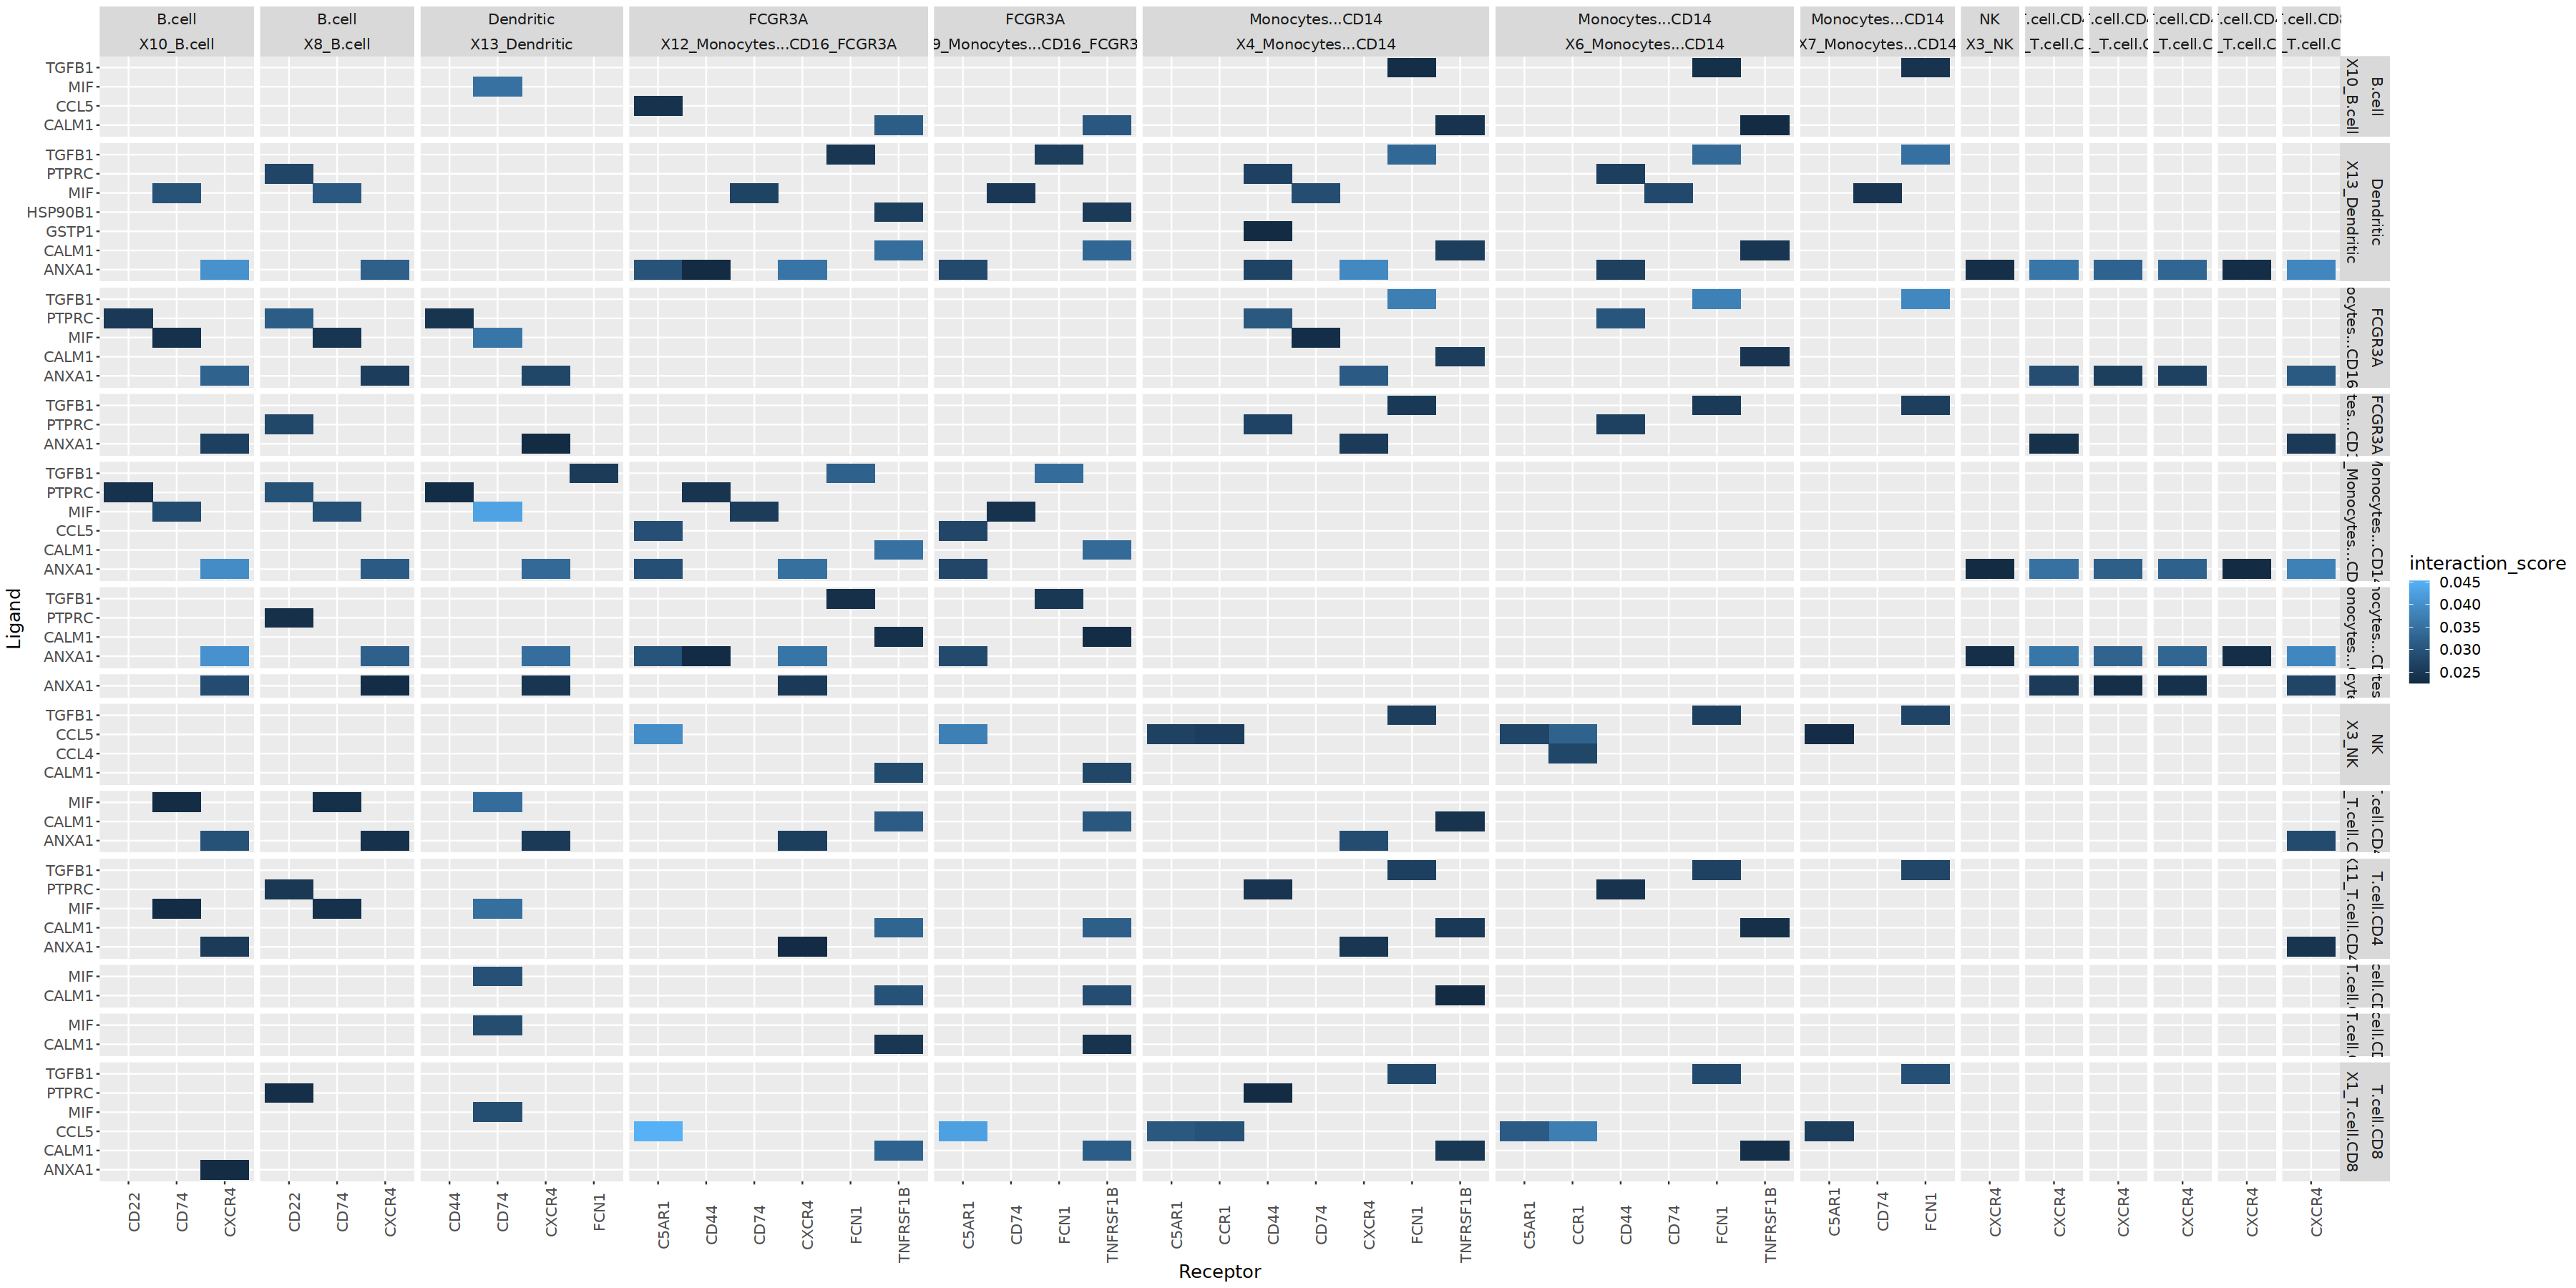

In [472]:
options(repr.plot.width=30, repr.plot.height=15)
ggplot(data_vis, aes(Receptor, Ligand, fill= interaction_score)) + theme(text = element_text(size=15), axis.text.x=element_text(angle=90)) + facet_grid(cell_type + cluster ~cell_type_R + cluster_R, space = 'free' , scales = 'free') +
 geom_tile()

#### Correlation / Expression Heatmap

In [473]:
#data_vis = data[(!data$type %in% filter_type_vis) & (!data$type_R %in% filter_type_vis),]
data_vis = data

In [474]:
#### Parameters

In [475]:
#### Choose a receptor cell-type
receptor = 'Monocytes...CD14'
filter_receptor = FALSE

In [476]:
### Optional - filter on a specific factor -- only for complete overview not for specifically on a cell-type! (to low amount)

In [477]:
### Select the top variable fraction of the MOFA factor to take
top_variable_fraction = 0.1

In [478]:
#### Select a factor
factor = 'Factor2'
filter_factor = TRUE

In [479]:
### Set thresholds
weight_filter = 0.1
cor_filter = 0.3

In [480]:
#### Define Top Genes per Factor 

In [481]:
## Select geneset OI

In [482]:
head(feature_weights_long,2)

type          variable_name type_cluster  variable_name_conc    variable
1 clinical_data CK            clinical_data clinical_data_0_CK    Factor1 
2 clinical_data CK_MB         clinical_data clinical_data_0_CK_MB Factor1 
  value      
1 -0.13716265
2 -0.08379148

In [483]:
#unique(feature_weights_long[,c('variable', 'type')])

In [484]:
geneset_oi_pos_per_factor = feature_weights_long %>% group_by(variable) %>% arrange( desc(value),  .by_group = TRUE)  %>% top_frac(top_variable_fraction)

Selecting by value


In [485]:

geneset_oi_pos_per_factor$direction = 'positive'

In [486]:
geneset_oi_neg_per_factor = feature_weights_long %>% group_by(variable) %>% arrange(desc(value),  .by_group = TRUE)  %>% top_frac(-top_variable_fraction)

Selecting by value


In [487]:
geneset_oi_neg_per_factor$direction = 'negative'

In [488]:
nrow(geneset_oi_pos_per_factor[geneset_oi_pos_per_factor$variable == 'Factor1',])

[1] 1328

In [489]:
geneset_oi = rbind(geneset_oi_pos_per_factor, geneset_oi_neg_per_factor)


In [490]:
geneset_oi = geneset_oi[geneset_oi$variable == factor,]

In [491]:
head(geneset_oi,2)

type        variable_name        type_cluster
1 single_cell X0_T.cell.CD4__EIF3E X0_TcellCD4 
2 single_cell X0_T.cell.CD4__HINT1 X0_TcellCD4 
  variable_name_conc                 variable value     direction
1 single_cell_0_X0_T.cell.CD4__EIF3E Factor2  0.5667885 positive 
2 single_cell_0_X0_T.cell.CD4__HINT1 Factor2  0.5502495 positive

In [492]:
unique(geneset_oi$type)

[1] "single_cell"   "clinical_data" "cytokine"

In [493]:
geneset_oi[(geneset_oi$variable_name_conc == 'single_cell_0_X4_Monocytes...CD14__CALR') ,]

type        variable_name             type_cluster    
1 single_cell X4_Monocytes...CD14__CALR X4_MonocytesCD14
  variable_name_conc                      variable value      direction
1 single_cell_0_X4_Monocytes...CD14__CALR Factor2  -0.2534262 negative

In [494]:
geneset_oi$variable_name[!is.na(str_extract(unique(geneset_oi$variable_name), 'CALR'))]

[1] "X9_Monocytes...CD16_FCGR3A__CALR"  "X12_Monocytes...CD16_FCGR3A__CALR"
[3] "X2_T.cell.CD4__CALR"               "X10_B.cell__CALR"                 
[5] "X4_Monocytes...CD14__CALR"         "X3_NK__CALR"                      
[7] "X1_T.cell.CD8__CALR"               "X0_T.cell.CD4__CALR"

In [495]:
head(geneset_oi[geneset_oi$variable_name == 'X9_Monocytes...CD16_FCGR3A__CALR',],2)

type        variable_name                    type_cluster           
1 single_cell X9_Monocytes...CD16_FCGR3A__CALR X9_MonocytesCD16_FCGR3A
  variable_name_conc                             variable value      direction
1 single_cell_0_X9_Monocytes...CD16_FCGR3A__CALR Factor2  -0.2110146 negative

In [496]:
min(abs(geneset_oi$value))

[1] 0.2057173

In [497]:
#feature_weights_long[!is.na(str_extract(feature_weights_long$variable_name, 'CALR')) & (feature_weights_long$variable == 'Factor1'),]

In [498]:
nrow(geneset_oi)

[1] 2656

In [499]:
#data_vis[(data_vis$ident_R %in% unique(geneset_oi$variable_name_conc)) &  (data_vis$ident %in% unique(geneset_oi$variable_name_conc)),]

In [500]:
#unique(data_vis$ident)

In [501]:
if(filter_factor == TRUE){
    data_vis = data_vis[(data_vis$ident_R %in% unique(geneset_oi$variable_name_conc)) & (data_vis$ident %in% unique(geneset_oi$variable_name_conc)),]
     }

In [502]:
head(data_vis,2)

ident               ident_R                                  Receptor
727 cytokine_0_IL6__IL6 single_cell_0_X2_T.cell.CD4__IL6ST       IL6ST   
729 cytokine_0_IL6__IL6 single_cell_0_X4_Monocytes...CD14__IL6ST IL6ST   
    Ligand amount_sources weight   interaction_type type     cluster 
727 IL6    2              0.787831 Ligand           cytokine cytokine
729 IL6    2              0.787831 Ligand           cytokine cytokine
    perc_cells_expressing_gene ⋯ mean_expr_R var_expression_R cell_type_R     
727 41.34211                   ⋯ 0.995394    0.02720833       T.cell.CD4      
729 41.34211                   ⋯ 1.006127    0.04497586       Monocytes...CD14
    cluster_vis_R cluster_number_R variable_R                 
727 1             2                X2_T.cell.CD4_0_IL6ST      
729 1             4                X4_Monocytes...CD14_0_IL6ST
    interaction_score correlation correlation_weight_interaction
727 0.01641683        0.1627846   0.1282467                     
729 0.01659385        0.1321769   0.1041331                     
    correlation_weight_expression_interaction
727 0.002672407                              
729 0.002193324

In [503]:
nrow(data_vis)

[1] 184

In [504]:
unique(data_vis$type)

[1] "cytokine"    "single_cell"

In [505]:
### Filter on receptor if true

In [506]:
filter_receptor

[1] FALSE

In [507]:
if(filter_receptor == TRUE){
    data_vis = data_vis[data_vis$cell_type_R == receptor,]
    }

In [508]:
### Apply correlation and weight thresholds

In [509]:
data_vis = data_vis[data_vis$weight > weight_filter,]

In [510]:
data_vis = data_vis[abs(data_vis$correlation) > cor_filter,]

In [511]:
head(data_vis)

ident                             
3732 single_cell_0_X0_T.cell.CD4__CALR 
3990 single_cell_0_X0_T.cell.CD4__HMGB1
3991 single_cell_0_X0_T.cell.CD4__HMGB1
4237 single_cell_0_X0_T.cell.CD4__MIF  
4249 single_cell_0_X0_T.cell.CD4__MIF  
4660 single_cell_0_X1_T.cell.CD8__CALR 
     ident_R                                  Receptor Ligand amount_sources
3732 single_cell_0_X1_T.cell.CD8__IL7R        IL7R     CALR   1             
3990 single_cell_0_X4_Monocytes...CD14__ITGA4 ITGA4    HMGB1  1             
3991 single_cell_0_X4_Monocytes...CD14__LY96  LY96     HMGB1  1             
4237 single_cell_0_X3_NK__CD74                CD74     MIF    1             
4249 single_cell_0_X8_B.cell__CD74            CD74     MIF    1             
4660 single_cell_0_X0_T.cell.CD4__IL7R        IL7R     CALR   1             
     weight    interaction_type type        cluster      
3732 0.1133325 Ligand           single_cell X0_T.cell.CD4
3990 0.1296817 Ligand           single_cell X0_T.cell.CD4
3991 0.3988450 Ligand           single_cell X0_T.cell.CD4
4237 0.6160990 Ligand           single_cell X0_T.cell.CD4
4249 0.6160990 Ligand           single_cell X0_T.cell.CD4
4660 0.1133325 Ligand           single_cell X1_T.cell.CD8
     perc_cells_expressing_gene ⋯ mean_expr_R var_expression_R cell_type_R     
3732 59.92502                   ⋯ 2.2683614   0.12173155       T.cell.CD8      
3990 91.64315                   ⋯ 0.9833088   0.03430886       Monocytes...CD14
3991 91.64315                   ⋯ 0.8218164   0.02806937       Monocytes...CD14
4237 44.06192                   ⋯ 0.7413468   0.03100375       NK              
4249 44.06192                   ⋯ 4.2965117   0.20932624       B.cell          
4660 66.81685                   ⋯ 2.9250497   0.06387951       T.cell.CD4      
     cluster_vis_R cluster_number_R variable_R                 
3732 4             1                X1_T.cell.CD8_0_IL7R       
3990 6             4                X4_Monocytes...CD14_0_ITGA4
3991 5             4                X4_Monocytes...CD14_0_LY96 
4237 7             3                X3_NK_0_CD74               
4249 7             8                X8_B.cell_0_CD74           
4660 4             0                X0_T.cell.CD4_0_IL7R       
     interaction_score correlation correlation_weight_interaction
3732 0.003544952       -0.3285265  -0.03723274                   
3990 0.003495761       -0.3255771  -0.04222137                   
3991 0.008985707        0.3852424   0.15365202                   
4237 0.004031936       -0.3310526  -0.20396117                   
4249 0.023367281       -0.3615198  -0.22273202                   
4660 0.005647793       -0.3282597  -0.03720250                   
     correlation_weight_expression_interaction
3732 -0.001164611                             
3990 -0.001138140                             
3991  0.003461676                             
4237 -0.001334783                             
4249 -0.008447736                             
4660 -0.001853943

In [512]:
data_vis$cluster_text = paste0(data_vis$cell_type, '_', data_vis$cluster_number)

In [513]:
#data_vis = head(data_vis[order(abs(data_vis$correlation_weight_interaction), decreasing = TRUE),],200)

In [514]:
#### Combine with expression

In [515]:
#### Correlation plot

In [516]:
###  Visualize all ligands
options(repr.plot.width=30, repr.plot.height=10)
p0 = ggplot(data_vis, aes(x = Receptor, y= Ligand)) + geom_point(aes(col=correlation, size=weight)) + facet_grid(cluster_text ~ cell_type_R + cluster_number_R, space = 'free' , scales = 'free', switch = 'y')  + theme(text = element_text(size=20), axis.text.x=element_text(angle=0), strip.text.y.left = element_text(angle = 0))  + scale_color_gradient2(low = "red", mid = "white", high = "blue", midpoint = 0, limits = c(-1,1)) + scale_size_continuous(range = c(1, 20), limits = c(0,1))  + scale_x_discrete(position = "top") + xlab('Receptor')

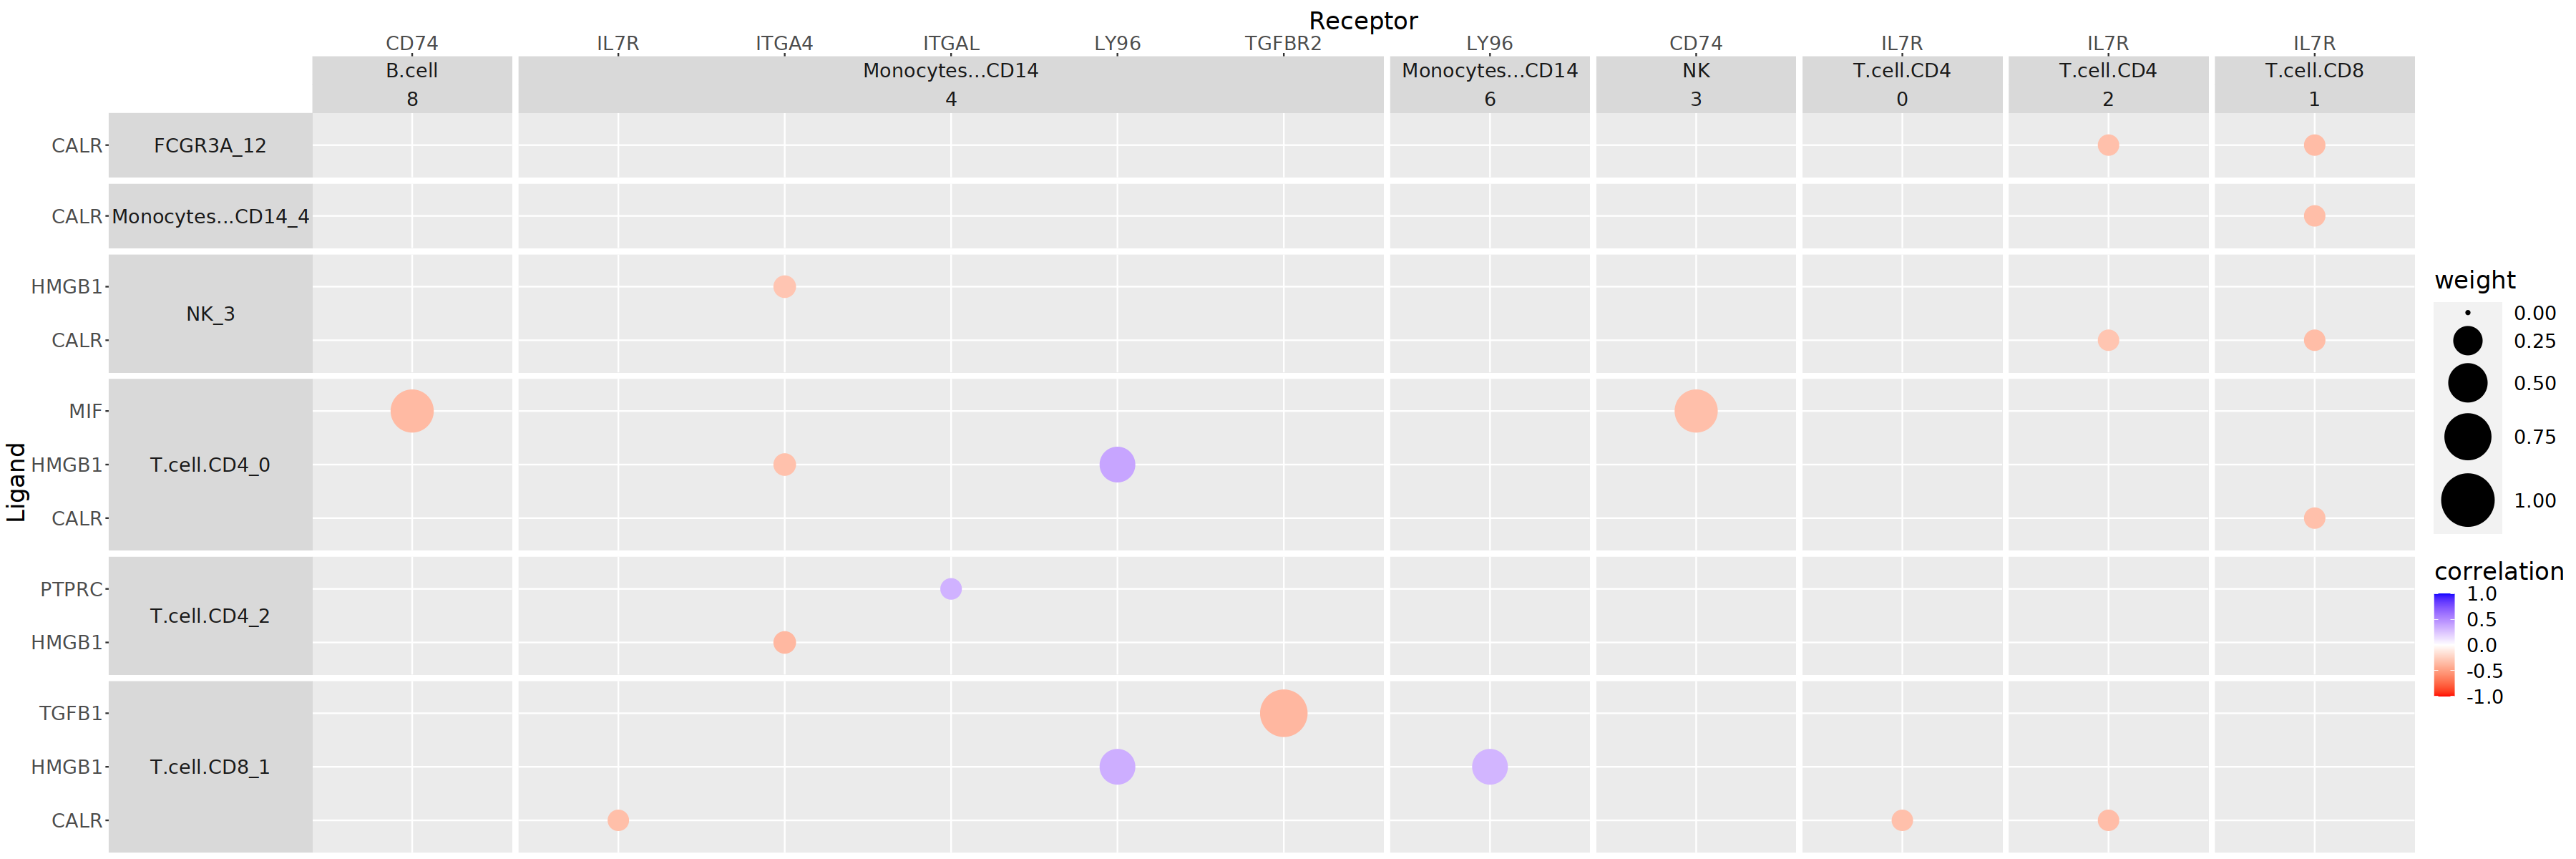

In [517]:
p0

In [518]:
### Heatmap instead of point plot (only showing correlation)
#options(repr.plot.width=30, repr.plot.height=5)
#p1=ggplot(data_vis, aes(cluster_R, Ligand, fill= correlation)) + theme(text = element_text(size=15), axis.text.x=element_text(angle=00),  strip.text.y.left = element_text(angle = 0)) + facet_grid(cluster ~Receptor , space = 'free' , scales = 'free', switch = 'y', labeller=labeller(cluster = label_wrap_gen(width = 20))) +
# geom_tile() + scale_fill_gradient2(low = "red", mid = "white", high = "blue", midpoint = 0) + scale_x_discrete(position = "top") + xlab('Receptor')

In [519]:
#p1

In [520]:
#### Expression Plots

In [521]:
options(repr.plot.width=10, repr.plot.height=10)
p4=ggplot(data_vis, aes(' ', Ligand, fill= mean_expr_norm)) + theme(text = element_text(size=20), axis.text.x=element_text(angle=0),  strip.text.y.left = element_text(angle = 0)) + facet_grid(cluster_text ~'Mean Ligand Expression', space = 'free' , scales = 'free', switch = 'y') +
 geom_tile() + scale_fill_gradient2(low = "red", mid = "white", high = "blue", midpoint = 0, limits = c(0,1)) + scale_x_discrete(position = "top") + guides(fill=guide_legend(title="mean_expr"))

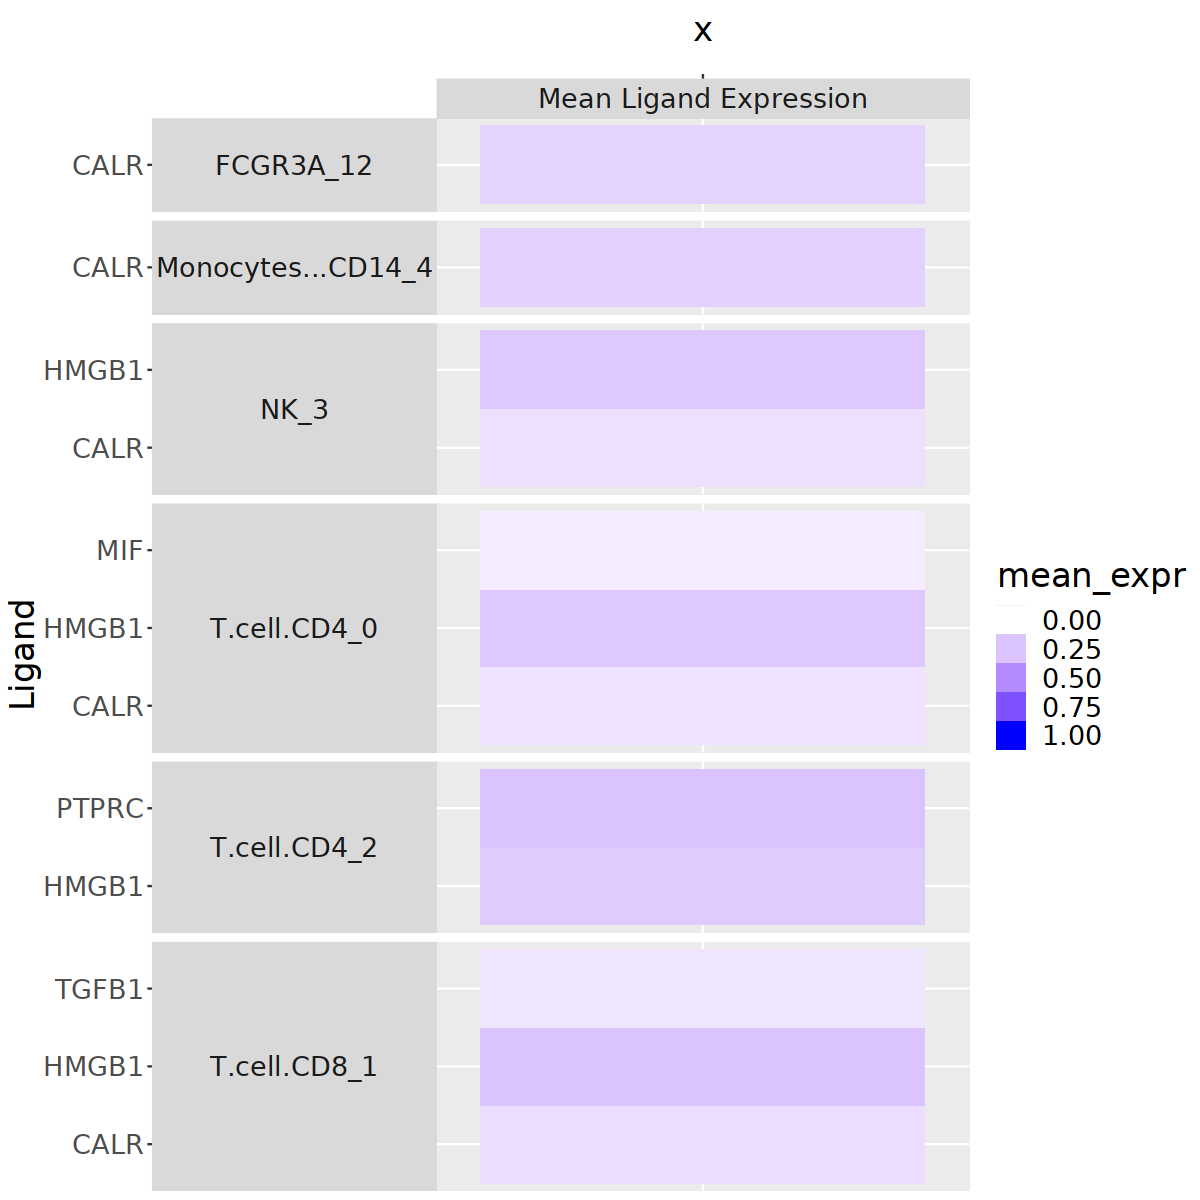

In [522]:
p4

In [523]:
options(repr.plot.width=15, repr.plot.height=10)
p5=ggplot(data_vis, aes(Receptor, strrep(" ",2*max(nchar(unique(data_vis$Ligand)))), fill= mean_expr_norm)) + theme(text = element_text(size=20), axis.text.x=element_text(angle=0),  strip.text.y.left = element_text(angle = 0)) + facet_grid(strrep(" ",2*max(nchar(unique(data_vis$cluster_text)))) ~cell_type_R + cluster_number_R, space = 'free' , scales = 'free', switch = 'y', labeller=labeller(label_wrap_gen(width = 1, multi_line = TRUE))) +
 geom_tile() + scale_fill_gradient2(low = "red", mid = "white", high = "blue", midpoint = 0, limits = c(0,1)) + ylab('Ligand') + guides(fill=guide_legend(title="mean_expr"))

In [524]:
options(repr.plot.width=30, repr.plot.height=10)
combined = ggarrange(p0,p4,p5, ncol = 2, nrow= 2, widths = c(4,1), heights = c(4,1)) + ggtitle(paste0('Target: ', receptor))

Warning message:
“Use of `data_vis$Ligand` is discouraged. Use `Ligand` instead.”


In [525]:
final_plot = annotate_figure(combined, top = text_grob(paste0('Top Ligand Receptor Interactions - ', factor, ' Version: ', version, '( ', top_variable_fraction, '_', cor_filter, ')'), face = "bold", size =20))

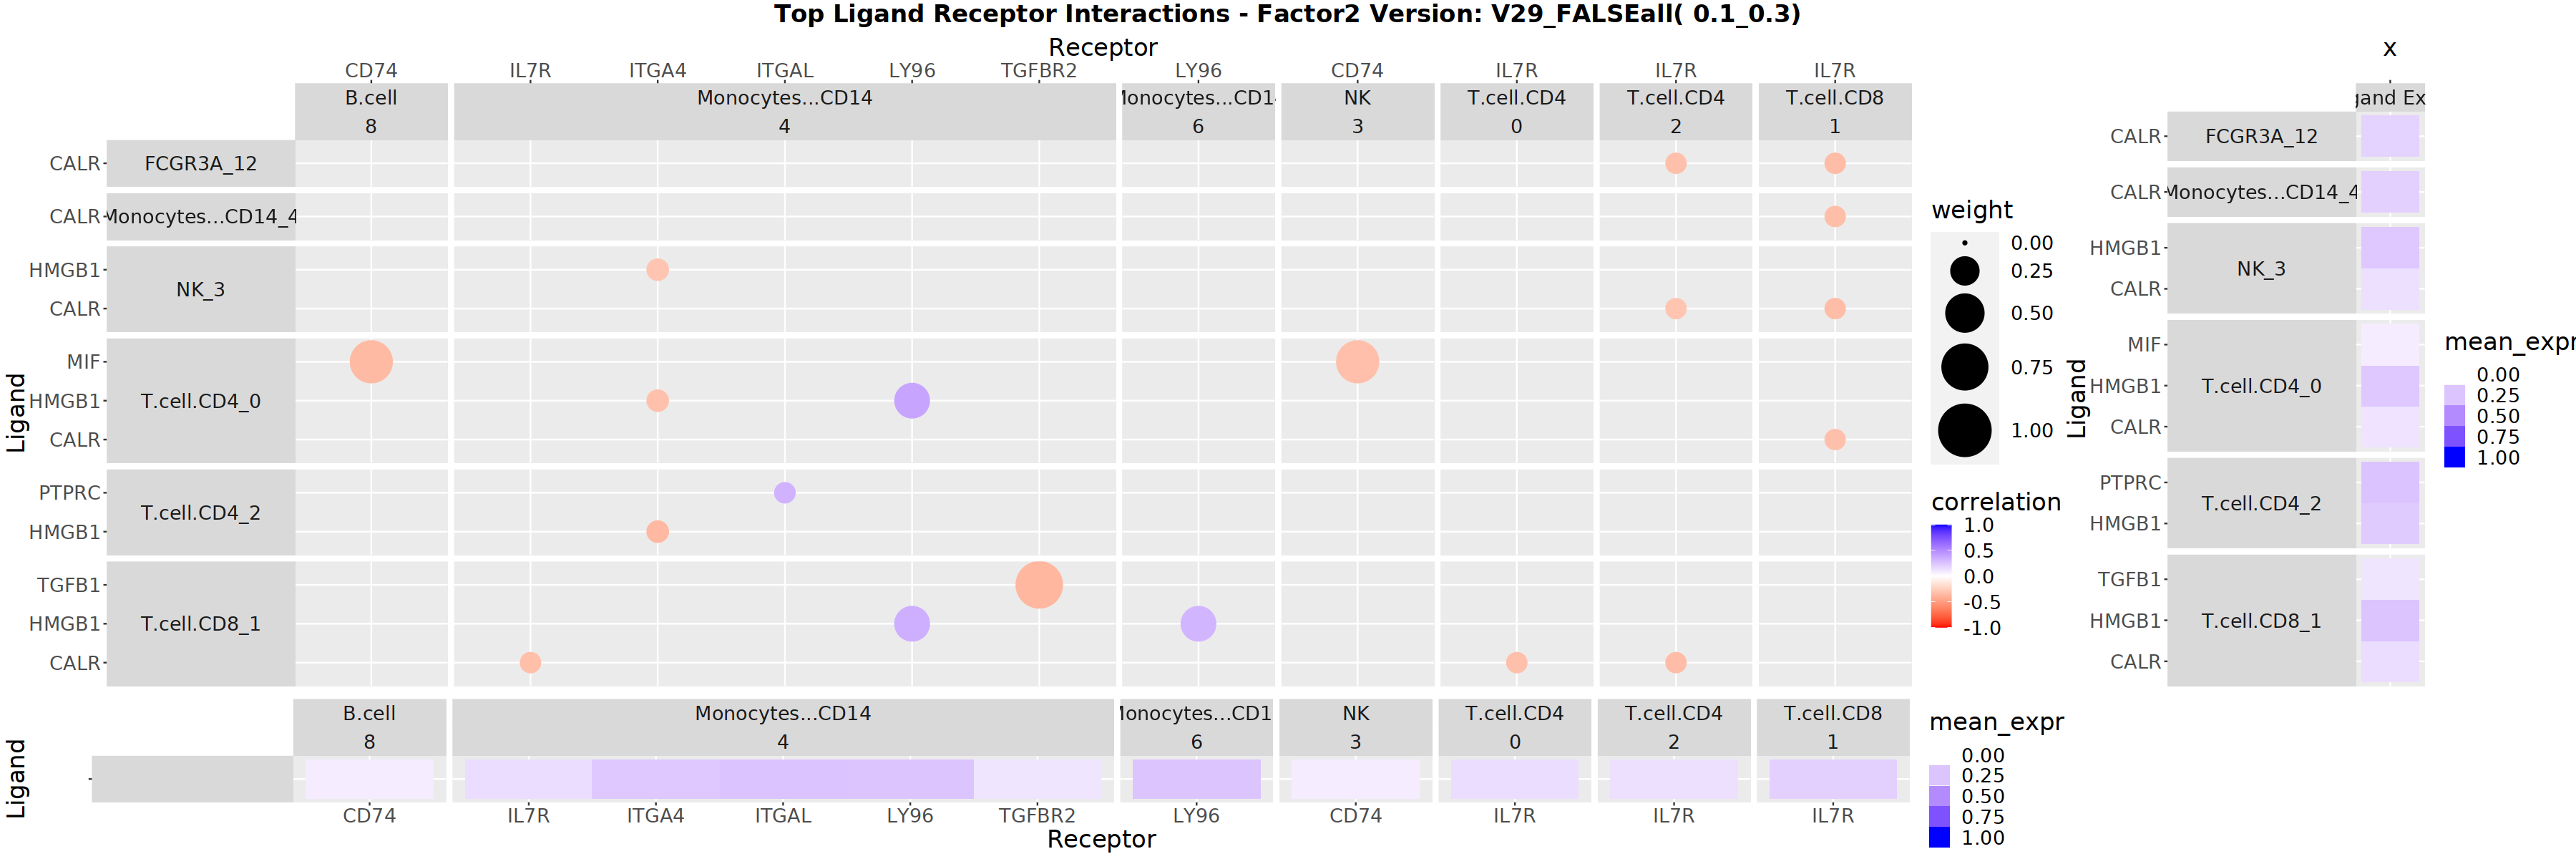

In [526]:
final_plot

In [527]:
pdf(paste0('figures/F_Ligand_Receptors/F4_Ligand_Receptor_Correlations_', factor, '_', version, '_', top_variable_fraction, '_', cor_filter, '.pdf'), width = 30, height = 10)
print(final_plot)
dev.off()

png 
  2

### Visualize in circoplot

#### Aggregated View

In [362]:
#### Prepare Data

In [363]:
#data_vis = data[(!data$type %in% filter_type_vis) & (!data$type_R %in% filter_type_vis),]
data_vis = data

In [364]:
unique(data$cluster_number)

[1] NA   "0"  "1"  "10" "11" "12" "13" "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"

In [365]:
### Filter out entries

In [366]:
data_vis = data_vis[data_vis$weight > 0.1,]

In [367]:
data_vis$cluster_text = paste0(data_vis$cell_type, '_', data_vis$cluster_number)

In [368]:
### Define on whether to focus only on single-cell data

In [369]:
#data_vis = data_vis[(!data_vis$type %in% filter_type_vis) & (!data_vis$type_R %in% filter_type_vis),]

In [370]:
#data_vis = data_vis[data_vis$cell_type %in% unique(data_vis$cell_type)[1:2],]

In [371]:
### Define variable that should show interaction-sizes 

In [372]:
data_vis$interaction_size = data_vis$mean_expr_norm * data_vis$mean_expr_norm_R

In [373]:
### Define variable that defines ticks --> dimension/ segments shown 

In [374]:
data_vis$plot_var = paste0(data_vis$cluster, '_S')

In [375]:
data_vis$plot_var_R = paste0(data_vis$cluster_R, 'R')

In [376]:
### Aggregate by defined variables

In [377]:
data_vis = data_vis %>% group_by(
    plot_var, plot_var_R, # Variables for segement definition (smallest unit)
    cluster, cluster_R, cell_type, cell_type_R,  # Variables for color definition (based on cell-types currently)
    cluster_number, cluster_number_R # Variables for text description 
    ) %>% summarise (
    interaction_size = sum(interaction_size) , # Aggregate variable for segment size
    weight = sum(weight) # Aggregate variable for transparency
)  

`summarise()` has grouped output by 'plot_var', 'plot_var_R', 'cluster',
'cluster_R', 'cell_type', 'cell_type_R', 'cluster_number'. You can override
using the `.groups` argument.


In [378]:
head(data_vis,2)

plot_var   plot_var_R  cluster  cluster_R  cell_type cell_type_R
1 cytokine_S neutrophilR cytokine neutrophil cytokine  neutrophil 
2 cytokine_S proteomicsR cytokine proteomics cytokine  proteomics 
  cluster_number cluster_number_R interaction_size weight   
1 NA             NA               5.430768         17.730992
2 NA             NA               2.116007          6.502644

In [379]:
head(unique(data_vis$weight))

[1] 17.730992  6.502644 26.326853 27.955168 17.714738 13.075303

In [380]:
## Set color   - cluster and cluster_R

In [381]:
data_vis$color = '#000000'

In [382]:
data_vis$color[data_vis$cluster == 'proteomics'] = '#2FE6EC'
data_vis$color[data_vis$cluster == 'cytokine'] = '#0E2D9F'
data_vis$color[data_vis$cluster == 'neutrophil'] = '#CA580E'
data_vis$color[data_vis$cluster %in%  c('X0_T.cell.CD4','X11_T.cell.CD4','X2_T.cell.CD4', 'X5_T.cell.CD4')  ] = '#E38DE5'
data_vis$color[data_vis$cluster %in%  c('X4_Monocytes...CD14','X6_Monocytes...CD14','X7_Monocytes...CD14')  ] = '#F1E984'
data_vis$color[data_vis$cluster %in%  c('X10_B.cell','X8_B.cell')  ] = '#8C75AD'
data_vis$color[data_vis$cluster %in%  c('X13_Dendritic')  ] = '#E6B17F'
data_vis$color[data_vis$cluster %in%  c('X1_T.cell.CD8')  ] = '#EC349B'
data_vis$color[data_vis$cluster %in%  c('X12_Monocytes...CD16_FCGR3A','X9_Monocytes...CD16_FCGR3A' )  ] = '#DCF39D'
data_vis$color[data_vis$cluster %in%  c('X3_NK' )  ] = '#9DB8F3'

In [383]:
data_vis$color_R = '#000000'

In [384]:
data_vis$color_R[data_vis$cluster_R == 'proteomics'] = '#2FE6EC'
data_vis$color_R[data_vis$cluster_R == 'cytokine'] = '#0E2D9F'
data_vis$color_R[data_vis$cluster_R == 'neutrophil'] = '#CA580E'
data_vis$color_R[data_vis$cluster_R %in%  c('X0_T.cell.CD4','X11_T.cell.CD4','X2_T.cell.CD4', 'X5_T.cell.CD4')  ] = '#E38DE5'
data_vis$color_R[data_vis$cluster_R %in%  c('X4_Monocytes...CD14','X6_Monocytes...CD14','X7_Monocytes...CD14')  ] = '#F1E984'
data_vis$color_R[data_vis$cluster_R %in%  c('X10_B.cell','X8_B.cell')  ] = '#8C75AD'
data_vis$color_R[data_vis$cluster_R %in%  c('X13_Dendritic')  ] = '#E6B17F'
data_vis$color_R[data_vis$cluster_R %in%  c('X1_T.cell.CD8')  ] = '#EC349B'
data_vis$color_R[data_vis$cluster_R %in%  c('X12_Monocytes...CD16_FCGR3A','X9_Monocytes...CD16_FCGR3A' )  ] = '#DCF39D'
data_vis$color_R[data_vis$cluster_R %in%  c('X3_NK' )  ] = '#9DB8F3'

In [385]:
grid_col =data_vis[,c('color', 'color_R')]

In [386]:
ligand_color = data_vis %>% distinct(plot_var,color)
grid_ligand_color = ligand_color$color %>% set_names(ligand_color$plot_var)
target_color = data_vis %>% distinct(plot_var_R,color_R)
grid_target_color = target_color$color_R %>% set_names(target_color$plot_var_R)

grid_col =c(grid_ligand_color,grid_target_color)

In [387]:
head(grid_col)

cytokine_S cytokine_S cytokine_S cytokine_S cytokine_S cytokine_S 
 "#0E2D9F"  "#0E2D9F"  "#0E2D9F"  "#0E2D9F"  "#0E2D9F"  "#0E2D9F"

In [388]:
#### Set text

In [389]:
colnames(data_vis)

[1] "plot_var"         "plot_var_R"       "cluster"          "cluster_R"       
 [5] "cell_type"        "cell_type_R"      "cluster_number"   "cluster_number_R"
 [9] "interaction_size" "weight"           "color"            "color_R"

In [390]:
unique(data_vis$cluster_number)

[1] NA   "0"  "1"  "10" "11" "12" "13" "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"

In [391]:
text = rbind(data.frame(variable = data_vis$plot_var, text = data_vis$cluster_number ), 
             data.frame(variable = data_vis$plot_var_R, text = data_vis$cluster_number_R))

In [392]:
### Define Legend

In [393]:
lgd1 = Legend(at = unique(c(unique(data_vis$cell_type), unique(data_vis$cell_type_R))), type = "points", 
              labels_gp = gpar(fontsize = 20),
              grid_height = unit(10, "mm"), grid_width = unit(4, "mm"), gap = unit(4, "mm"),
              legend_gp =list(col = unique(c(unique(data_vis$color), unique(data_vis$color_R)))), 
              title_position = "topleft", 
              title = "Cell-Type", 
              title_gp = gpar(fontsize = 20),
              pch = 16, 
              size = unit(8, "mm"))

In [394]:
lgd_list_vertical = packLegend(lgd1)

In [395]:
### Set alternative colors for links

In [396]:
#head(data_vis,2)

In [397]:
#col_mat = data_vis[,c('variable', 'variable_R', 'correlation')]

In [398]:
#col_mat$color = '#07A52B'

In [399]:
#col_mat$color[col_mat$correlation < 0 ] = '#A52D07'

In [400]:
#col_mat = col_mat$color

In [401]:
#head(col_mat)

In [402]:
### Define links and order

In [403]:
links_circle = data_vis[,c('plot_var', 'plot_var_R', 'interaction_size')]

In [404]:
colnames(links_circle) = c('ligand' , 'target', 'weight')

In [405]:
ordered_data_sender = data_vis %>% arrange(cell_type, cluster_number, cell_type_R, cluster_number_R)

In [406]:
ordered_data_receiver = data_vis %>% arrange( cell_type_R, cluster_number_R, cell_type, cluster_number)

In [407]:
order = c(ordered_data_sender$plot_var, ordered_data_receiver$plot_var_R)

In [408]:
#description = ordered_data[, c('plot_var', 'plot_var_R')]

In [409]:
head(order)

[1] "X10_B.cell_S" "X10_B.cell_S" "X10_B.cell_S" "X10_B.cell_S" "X10_B.cell_S"
[6] "X10_B.cell_S"

In [410]:
#### Define transparency based on a value

In [411]:
data_vis = as.data.frame(data_vis) # grouping needs to be removed from dataframe

In [412]:
transparency =data_vis %>% mutate(weight =(weight-min(weight))/(max(weight)-min(weight))) %>% mutate(transparency = 1-weight) %>% .$transparency 

In [413]:
head(transparency)

[1] 0.7485799 0.9259616 0.6127854 0.5870619 0.7488367 0.8221289

In [414]:
# hist(transparency)  --> values between 0  and 1

In [415]:
#data_vis

In [416]:
circos.clear()

In [417]:
#par(cex = 5, mar = c(0, 0, 0, 0))

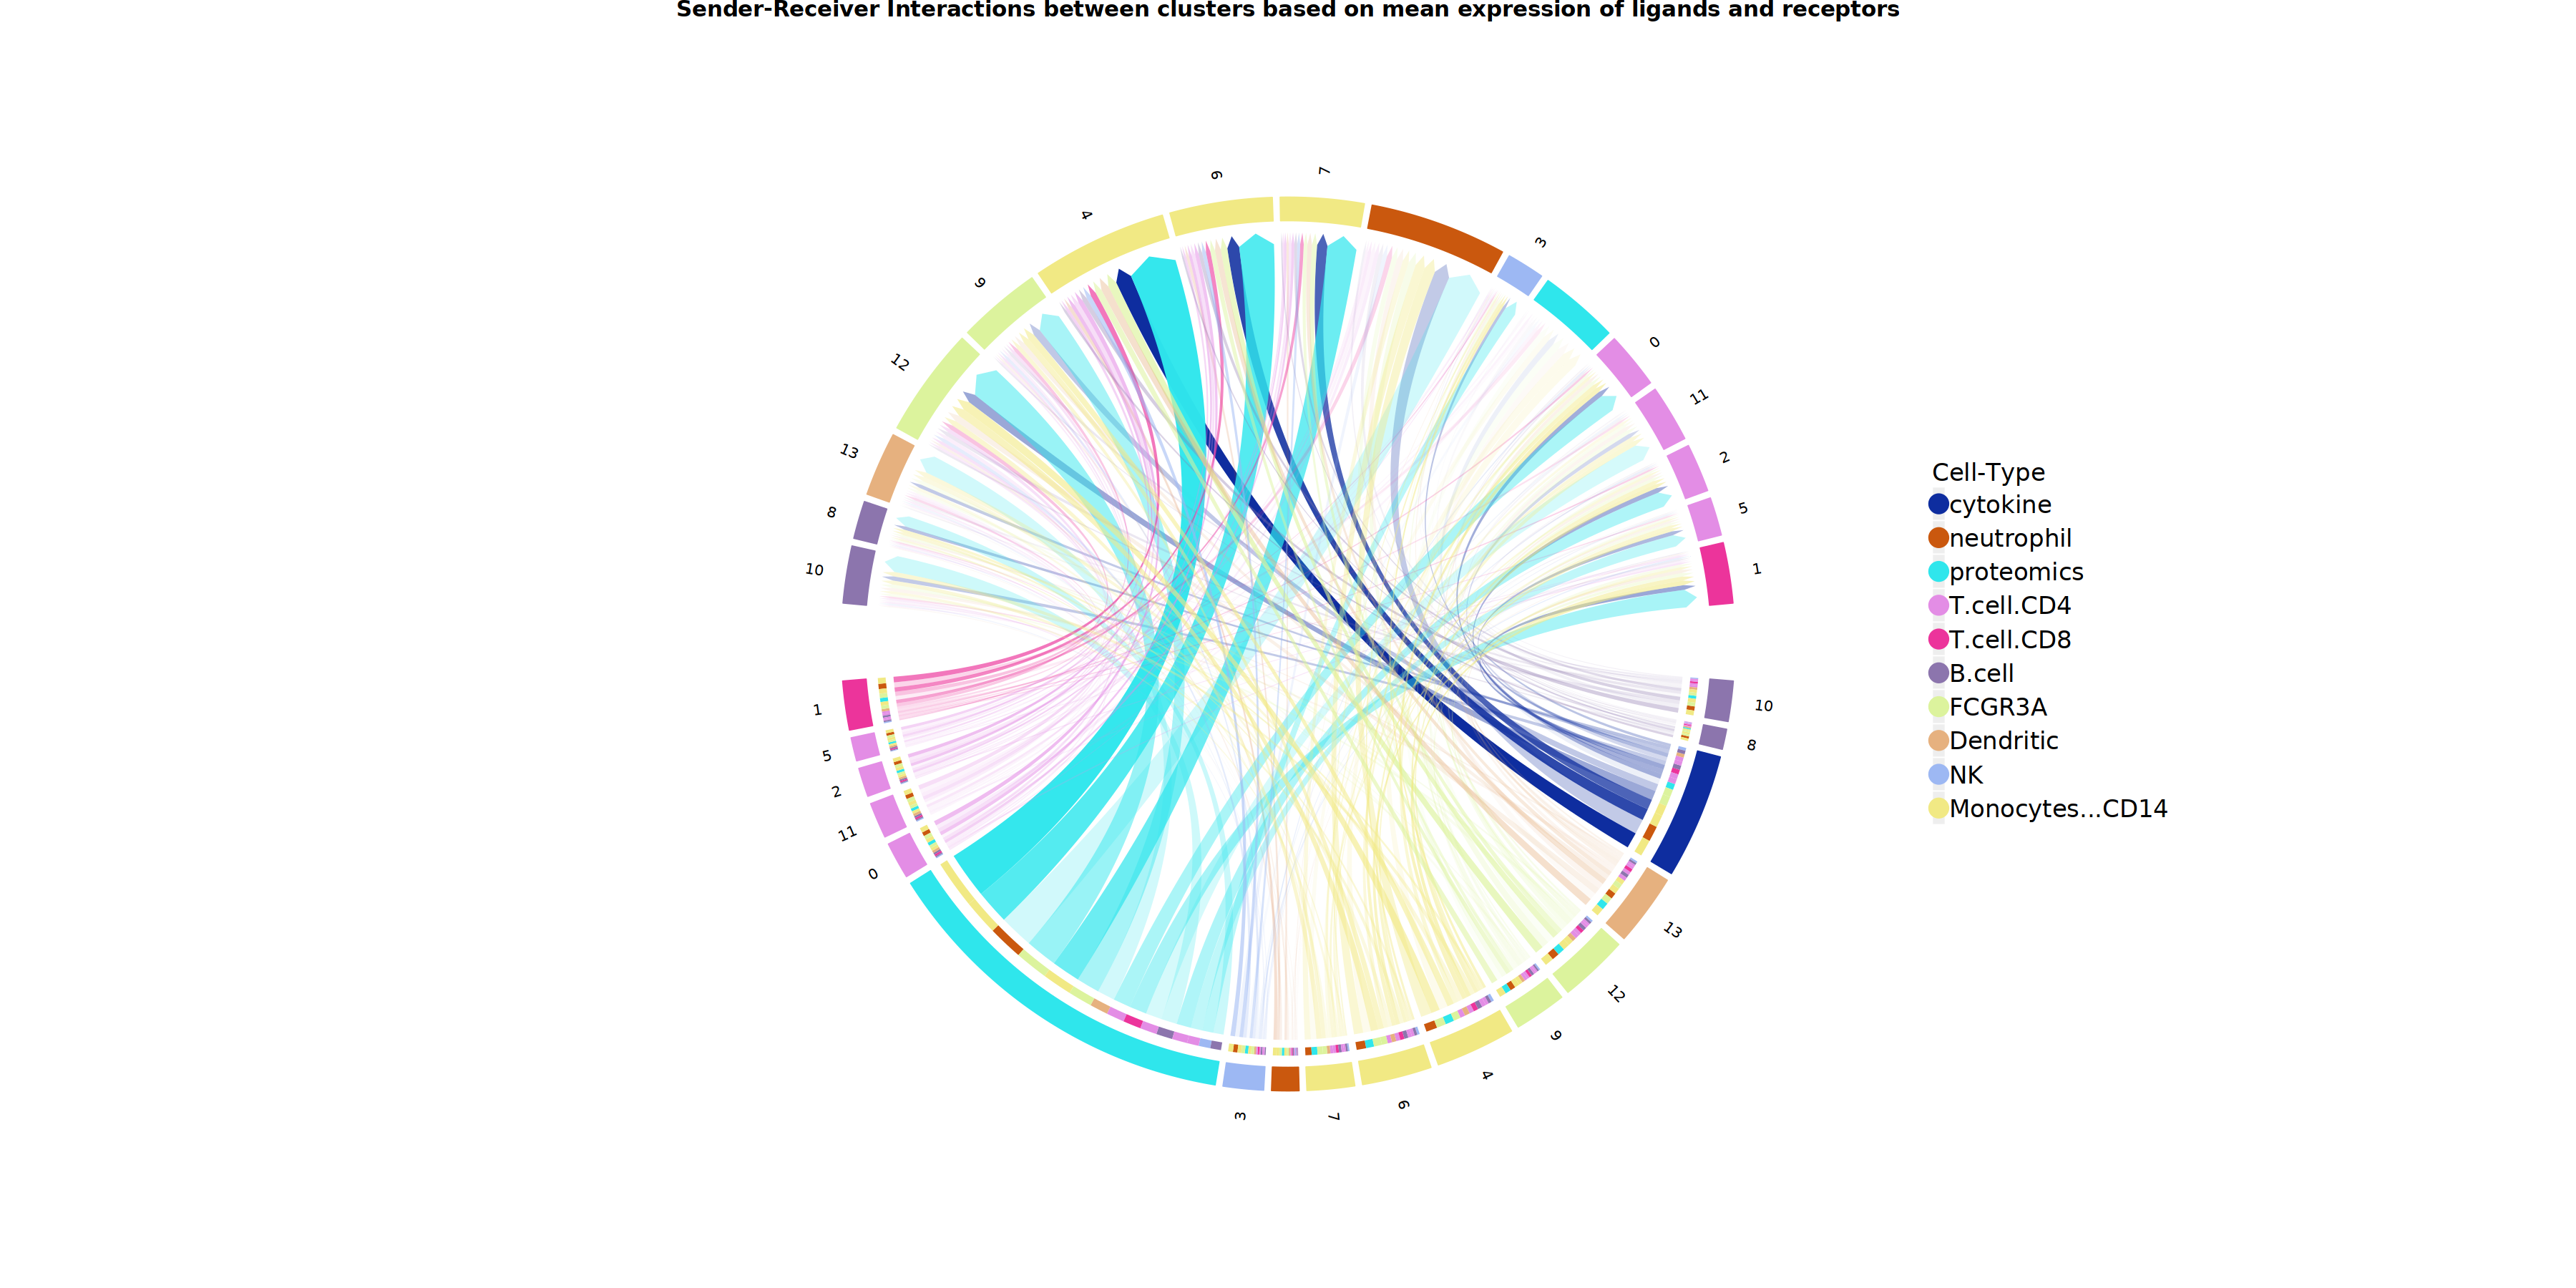

In [418]:
options(repr.plot.width=30, repr.plot.height=15)
chordDiagram(links_circle, directional = 1, order=order,link.sort = TRUE, link.decreasing = FALSE, grid.col = grid_col, transparency = transparency, direction.type = c("diffHeight", "arrows"),  link.arr.type = "big.arrow", annotationTrack = c( "grid"), preAllocateTracks = 1, title(main ='Sender-Receiver Interactions between clusters based on mean expression of ligands and receptors', cex.main = 1.5))
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  # sector.name = 
  circos.text(mean(xlim), ylim[1] + .1, text$text[text$variable == get.cell.meta.data("sector.index")], facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
  #circos.axis(h = "top", labels.cex = 0.5, major.tick.length = 0.2, sector.index = get.cell.meta.data("sector.index"), track.index = 2)
}, bg.border = NA)
### Add legend
draw(lgd_list_vertical, x = unit(1.5, "snpc"), just = "left")

#### Factor specific view

In [528]:
#### Filter on interaction score/ correlation and display top ligand receptor interactions for a specific MOFA factor

In [529]:
length(unique(data$ident))

[1] 722

In [530]:
length(unique(data$ident_R))

[1] 970

In [531]:
head(data,2)

ident                   ident_R            Receptor Ligand amount_sources
1 cytokine_0_BCA1__CXCL13 neutrophil_0_CXCR4 CXCR4    CXCL13 1             
2 cytokine_0_BCA1__CXCL13 neutrophil_0_FPR2  FPR2     CXCL13 1             
  weight    interaction_type type     cluster  perc_cells_expressing_gene ⋯
1 0.2788696 Ligand           cytokine cytokine 41.34211                   ⋯
2 0.1930190 Ligand           cytokine cytokine 41.34211                   ⋯
  mean_expr_R var_expression_R cell_type_R cluster_vis_R cluster_number_R
1 3.484843    0.7122165        neutrophil  4             NA              
2 2.568535    0.9156551        neutrophil  3             NA              
  variable_R         interaction_score correlation
1 neutrophil_0_CXCR4 0.03480850        -0.1336829 
2 neutrophil_0_FPR2  0.01775768         0.1266091 
  correlation_weight_interaction correlation_weight_expression_interaction
1 -0.03728011                    -0.004653302                             
2  0.02443796                     0.002248284

In [532]:
#data_vis = data[(!data$type %in% filter_type_vis) & (!data$type_R %in% filter_type_vis),]
data_vis = data

In [533]:
#### Parameters

In [534]:
### Optional - filter on a specific factor -- only for complete overview not for specifically on a cell-type! (to low amount)

In [535]:
### Select the amount of variables to take
top_variable_fraction = 0.1

In [536]:
### Select a factor 
factor = 'Factor2'
filter_factor = TRUE

In [537]:
### Set thresholding parameters for filtering
cor_filter = 0.3
weight_filter = 0.1

In [538]:
#### Define Top Genes per Factor 

In [539]:
## Select geneset OI

In [540]:
head(feature_weights_long,2)

type          variable_name type_cluster  variable_name_conc    variable
1 clinical_data CK            clinical_data clinical_data_0_CK    Factor1 
2 clinical_data CK_MB         clinical_data clinical_data_0_CK_MB Factor1 
  value      
1 -0.13716265
2 -0.08379148

In [541]:
geneset_oi_pos_per_factor = feature_weights_long %>% group_by(variable) %>% arrange( desc(value),  .by_group = TRUE)  %>% top_frac(top_variable_fraction)

Selecting by value


In [542]:

geneset_oi_pos_per_factor$direction = 'positive'

In [543]:
geneset_oi_neg_per_factor = feature_weights_long %>% group_by(variable) %>% arrange(desc(value),  .by_group = TRUE)  %>% top_frac(-top_variable_fraction)

Selecting by value


In [544]:
geneset_oi_neg_per_factor$direction = 'negative'

In [545]:
nrow(geneset_oi_pos_per_factor[geneset_oi_pos_per_factor$variable == 'Factor1',])

[1] 1328

In [546]:
geneset_oi = rbind(geneset_oi_pos_per_factor, geneset_oi_neg_per_factor)


In [547]:
geneset_oi = geneset_oi[geneset_oi$variable == factor,]

In [548]:
#head(geneset_oi,2)

In [549]:
nrow(geneset_oi)

[1] 2656

In [550]:
#data_vis[(data_vis$ident_R %in% unique(geneset_oi$variable_name_conc)) &  (data_vis$ident %in% unique(geneset_oi$variable_name_conc)),]

In [551]:
### Apply parameters - filter on factor

In [552]:
if(filter_factor == TRUE){
    data_vis = data_vis[(data_vis$ident_R %in% unique(geneset_oi$variable_name_conc)) & (data_vis$ident %in% unique(geneset_oi$variable_name_conc)),]
     }

In [553]:
head(geneset_oi,2)

type        variable_name        type_cluster
1 single_cell X0_T.cell.CD4__EIF3E X0_TcellCD4 
2 single_cell X0_T.cell.CD4__HINT1 X0_TcellCD4 
  variable_name_conc                 variable value     direction
1 single_cell_0_X0_T.cell.CD4__EIF3E Factor2  0.5667885 positive 
2 single_cell_0_X0_T.cell.CD4__HINT1 Factor2  0.5502495 positive

In [554]:
## Add factor values

In [555]:
factor_value_merge = geneset_oi[,c('variable_name_conc', 'value', 'direction')]

In [556]:
colnames(factor_value_merge) = c('ident', 'ident_factor_weight', 'ident_direction')

In [557]:
data_vis = merge(data_vis, factor_value_merge)

In [558]:
colnames(factor_value_merge) = c('ident_R', 'ident_R_factor_weight', 'ident_R_direction')

In [559]:
data_vis = merge(data_vis, factor_value_merge)

In [560]:
nrow(data_vis)

[1] 184

In [561]:
head(data_vis,2)

ident_R                           ident                                   
1 single_cell_0_X0_T.cell.CD4__CD47 single_cell_0_X6_Monocytes...CD14__THBS1
2 single_cell_0_X0_T.cell.CD4__IL7R single_cell_0_X4_Monocytes...CD14__CALR 
  Receptor Ligand amount_sources weight     interaction_type type       
1 CD47     THBS1  1              0.03400515 Ligand           single_cell
2 IL7R     CALR   1              0.11333251 Ligand           single_cell
  cluster             perc_cells_expressing_gene ⋯ cluster_number_R
1 X6_Monocytes...CD14 40.96590                   ⋯ 0               
2 X4_Monocytes...CD14 80.23932                   ⋯ 0               
  variable_R           interaction_score correlation
1 X0_T.cell.CD4_0_CD47 0.0003634936       0.02767075
2 X0_T.cell.CD4_0_IL7R 0.0077472993      -0.19158475
  correlation_weight_interaction correlation_weight_expression_interaction
1  0.0009409481                   1.005814e-05                            
2 -0.0217127819                  -1.484264e-03                            
  ident_factor_weight ident_direction ident_R_factor_weight ident_R_direction
1  0.3280488          positive        0.2599563             positive         
2 -0.2534262          negative        0.4115115             positive

In [562]:
#data_vis = data_vis[(!data_vis$type %in% filter_type_vis) & (!data_vis$type_R %in% filter_type_vis),]

In [563]:
### Filter out entries

In [564]:
data_vis = data_vis[data_vis$weight > weight_filter,]

In [565]:
data_vis$cluster_text = paste0(data_vis$cell_type, '_', data_vis$cluster_number)

In [566]:
### Define on whether to focus only on single-cell data

In [567]:
#data_vis = data_vis[data_vis$cell_type %in% unique(data_vis$cell_type)[1:2],]

In [568]:
### Define variable that should show interaction-sizes 

In [569]:
data_vis$interaction_size = data_vis$mean_expr_norm * data_vis$mean_expr_norm_R

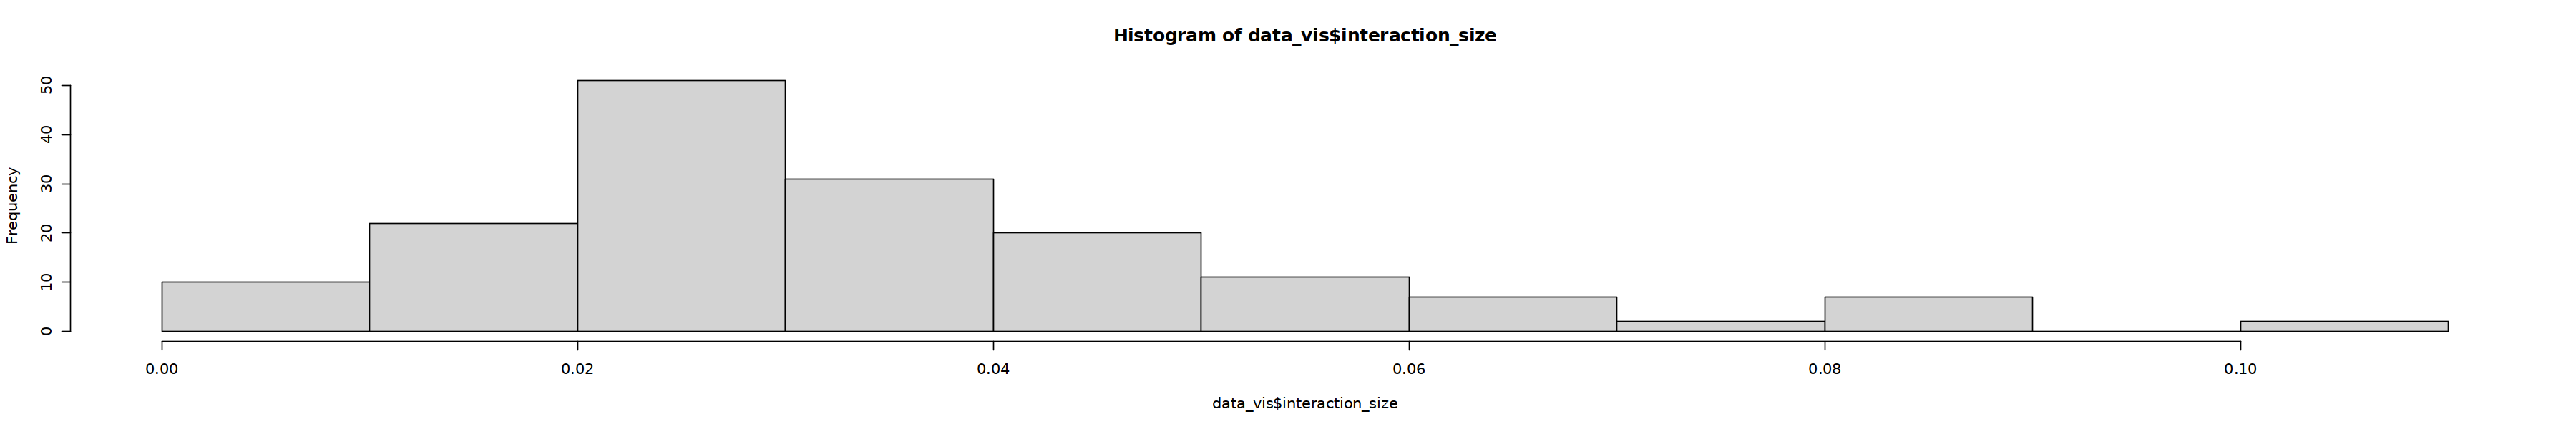

In [570]:
options(repr.plot.width=30, repr.plot.height=5)
hist(data_vis$interaction_size)

In [571]:
#data_vis = data_vis[data_vis$interaction_size > 0.075,]
###  Alternative: filter by correlation
data_vis = data_vis[abs(data_vis$correlation) >cor_filter,]
# data_vis = data_vis[data_vis$interaction_size > 0.01,]

In [572]:
### Calculate p-values for selected visualized correlations

In [573]:
length(unique(data_vis$ident))

[1] 12

In [574]:
length(unique(data_vis$ident_R))

[1] 11

In [575]:
head(data_vis,2)

ident_R                          
7  single_cell_0_X0_T.cell.CD4__IL7R
26 single_cell_0_X1_T.cell.CD8__IL7R
   ident                                           Receptor Ligand
7  single_cell_0_X1_T.cell.CD8__CALR               IL7R     CALR  
26 single_cell_0_X12_Monocytes...CD16_FCGR3A__CALR IL7R     CALR  
   amount_sources weight    interaction_type type       
7  1              0.1133325 Ligand           single_cell
26 1              0.1133325 Ligand           single_cell
   cluster                     perc_cells_expressing_gene ⋯ interaction_score
7  X1_T.cell.CD8               66.81685                   ⋯ 0.005647793      
26 X12_Monocytes...CD16_FCGR3A 82.21303                   ⋯ 0.005790643      
   correlation correlation_weight_interaction
7  -0.3282597  -0.03720250                   
26 -0.3475937  -0.03939367                   
   correlation_weight_expression_interaction ident_factor_weight
7  -0.001853943                              -0.3922054         
26 -0.002012791                              -0.2114685         
   ident_direction ident_R_factor_weight ident_R_direction cluster_text
7  negative        0.4115115             positive          T.cell.CD8_1
26 negative        0.4217747             positive          FCGR3A_12   
   interaction_size
7  0.04983383      
26 0.05109427

In [576]:
ligand_receptor_correlations_test = cor_test(
  ligand_receptor_expression,
  vars = all_of(unique(data_vis$ident)),
  vars2 = all_of(unique(data_vis$ident_R)),
  alternative = "two.sided",
  method = "spearman",
  conf.level = 0.95,
  use = "pairwise.complete.obs"
)

In [577]:
colnames(ligand_receptor_correlations_test) = c('ident', 'ident_R', 'correlation_test', 'statistic', 'p', 'method') 

In [578]:
head(ligand_receptor_correlations_test[order(ligand_receptor_correlations_test$ident),],2)

ident                             ident_R                          
1 single_cell_0_X0_T.cell.CD4__CALR single_cell_0_X0_T.cell.CD4__IL7R
2 single_cell_0_X0_T.cell.CD4__CALR single_cell_0_X1_T.cell.CD8__IL7R
  correlation_test statistic p        method  
1 -0.33            373086.4  0.000265 Spearman
2 -0.33            373103.4  0.000265 Spearman

In [579]:
#ligand_receptor_correlations_test[abs(ligand_receptor_correlations_test$correlation_test) >= cor_filter,]

In [580]:
#nrow(unique(data_vis[,c('ident', 'ident_R')]))

In [581]:
### Merge with data

In [582]:
nrow(data_vis)

[1] 19

In [583]:
data_vis = merge(data_vis, ligand_receptor_correlations_test)

In [584]:
max(data_vis$p)   # all significant

[1] 0.000859

In [585]:
p_thres = 0.05

In [586]:
data_vis = data_vis[data_vis$p <= p_thres]

In [587]:
#data_vis

In [588]:
### Save

In [589]:
write.csv(data_vis, paste0(result_path, '/F-Analysis/', 'F4_', factor, '_Ligand_Receptor_Correlations_', name, '_', version, '_', top_variable_fraction, '_', cor_filter, '_', weight_filter, '.csv'))

In [590]:
#data_vis

In [591]:
### Define variable that defines ticks --> dimension/ segments shown 

In [592]:
data_vis$plot_var =  data_vis$variable

In [593]:
data_vis$plot_var_R = data_vis$variable_R

In [594]:
### Aggregate by defined variables

In [595]:
data_vis = data_vis %>% group_by(
    plot_var, plot_var_R, # Variables for segement definition (smallest unit)
    cluster, cluster_R, cell_type, cell_type_R,  # Variables for color definition (based on cell-types currently)
    Ligand, Receptor, cluster_number, cluster_number_R , ident_factor_weight, ident_R_factor_weight# Variables for text description 
    ) %>% summarise (
    interaction_size = sum(interaction_size) , # Aggregate variable for segment size
    weight = sum(weight), # Aggregate variable for transparency,
    correlation = mean(correlation) # variable for potentially changing color
)  

`summarise()` has grouped output by 'plot_var', 'plot_var_R', 'cluster',
'cluster_R', 'cell_type', 'cell_type_R', 'Ligand', 'Receptor',
'cluster_number', 'cluster_number_R', 'ident_factor_weight'. You can override
using the `.groups` argument.


In [596]:
head(data_vis,2)

plot_var              plot_var_R                  cluster      
1 X0_T.cell.CD4_0_CALR  X1_T.cell.CD8_0_IL7R        X0_T.cell.CD4
2 X0_T.cell.CD4_0_HMGB1 X4_Monocytes...CD14_0_ITGA4 X0_T.cell.CD4
  cluster_R           cell_type  cell_type_R      Ligand Receptor
1 X1_T.cell.CD8       T.cell.CD4 T.cell.CD8       CALR   IL7R    
2 X4_Monocytes...CD14 T.cell.CD4 Monocytes...CD14 HMGB1  ITGA4   
  cluster_number cluster_number_R ident_factor_weight ident_R_factor_weight
1 0              1                -0.4045349           0.4217747           
2 0              4                 0.4914897          -0.3364544           
  interaction_size weight    correlation
1 0.03127921       0.1133325 -0.3285265 
2 0.02695648       0.1296817 -0.3255771

In [597]:
head(unique(data_vis$weight))

[1] 0.1133325 0.1296817 0.3988450 0.6160990 0.7665905 0.1149314

In [598]:
## Set color   - cluster and cluster_R

In [599]:
data_vis$color = '#000000'

In [600]:
data_vis$color[data_vis$cluster == 'proteomics'] = '#2FE6EC'
data_vis$color[data_vis$cluster == 'cytokine'] = '#0E2D9F'
data_vis$color[data_vis$cluster == 'neutrophil'] = '#CA580E'
data_vis$color[data_vis$cluster %in%  c('X0_T.cell.CD4','X11_T.cell.CD4','X2_T.cell.CD4', 'X5_T.cell.CD4')  ] = '#E38DE5'
data_vis$color[data_vis$cluster %in%  c('X4_Monocytes...CD14','X6_Monocytes...CD14','X7_Monocytes...CD14')  ] = '#F1E984'
data_vis$color[data_vis$cluster %in%  c('X10_B.cell','X8_B.cell')  ] = '#8C75AD'
data_vis$color[data_vis$cluster %in%  c('X13_Dendritic')  ] = '#E6B17F'
data_vis$color[data_vis$cluster %in%  c('X1_T.cell.CD8')  ] = '#EC349B'
data_vis$color[data_vis$cluster %in%  c('X12_Monocytes...CD16_FCGR3A','X9_Monocytes...CD16_FCGR3A' )  ] = '#DCF39D'
data_vis$color[data_vis$cluster %in%  c('X3_NK' )  ] = '#9DB8F3'

In [601]:
data_vis$color_R = '#000000'

In [602]:
data_vis$color_R[data_vis$cluster_R == 'proteomics'] = '#2FE6EC'
data_vis$color_R[data_vis$cluster_R == 'cytokine'] = '#0E2D9F'
data_vis$color_R[data_vis$cluster_R == 'neutrophil'] = '#CA580E'
data_vis$color_R[data_vis$cluster_R %in%  c('X0_T.cell.CD4','X11_T.cell.CD4','X2_T.cell.CD4', 'X5_T.cell.CD4')  ] = '#E38DE5'
data_vis$color_R[data_vis$cluster_R %in%  c('X4_Monocytes...CD14','X6_Monocytes...CD14','X7_Monocytes...CD14')  ] = '#F1E984'
data_vis$color_R[data_vis$cluster_R %in%  c('X10_B.cell','X8_B.cell')  ] = '#8C75AD'
data_vis$color_R[data_vis$cluster_R %in%  c('X13_Dendritic')  ] = '#E6B17F'
data_vis$color_R[data_vis$cluster_R %in%  c('X1_T.cell.CD8')  ] = '#EC349B'
data_vis$color_R[data_vis$cluster_R %in%  c('X12_Monocytes...CD16_FCGR3A','X9_Monocytes...CD16_FCGR3A' )  ] = '#DCF39D'
data_vis$color_R[data_vis$cluster_R %in%  c('X3_NK' )  ] = '#9DB8F3'

In [603]:
grid_col =data_vis[,c('color', 'color_R')]

In [604]:
ligand_color = data_vis %>% distinct(plot_var,color)
grid_ligand_color = ligand_color$color %>% set_names(ligand_color$plot_var)
target_color = data_vis %>% distinct(plot_var_R,color_R)
grid_target_color = target_color$color_R %>% set_names(target_color$plot_var_R)

grid_col =c(grid_ligand_color,grid_target_color)

In [605]:
head(grid_col)

X0_T.cell.CD4_0_CALR X0_T.cell.CD4_0_HMGB1 X0_T.cell.CD4_0_HMGB1 
            "#E38DE5"             "#E38DE5"             "#E38DE5" 
  X0_T.cell.CD4_0_MIF   X0_T.cell.CD4_0_MIF  X1_T.cell.CD8_0_CALR 
            "#E38DE5"             "#E38DE5"             "#EC349B"

In [606]:
#### Set text

In [607]:
colnames(data_vis)

[1] "plot_var"              "plot_var_R"            "cluster"              
 [4] "cluster_R"             "cell_type"             "cell_type_R"          
 [7] "Ligand"                "Receptor"              "cluster_number"       
[10] "cluster_number_R"      "ident_factor_weight"   "ident_R_factor_weight"
[13] "interaction_size"      "weight"                "correlation"          
[16] "color"                 "color_R"

In [608]:
text = rbind(data.frame(variable = data_vis$plot_var, text = paste0(data_vis$Ligand, ' (', data_vis$cluster_number, '| ', round(data_vis$ident_factor_weight,2),  ')' ) ), 
             data.frame(variable = data_vis$plot_var_R, text = paste0(data_vis$Receptor, ' (', data_vis$cluster_number_R,'| ', round(data_vis$ident_R_factor_weight,2), ')' )))

In [609]:
### Define Legend

In [610]:
lgd1 = Legend(at = unique(c(unique(data_vis$cell_type), unique(data_vis$cell_type_R))), type = "points", 
              labels_gp = gpar(fontsize = 20),
              grid_height = unit(10, "mm"), grid_width = unit(4, "mm"), gap = unit(4, "mm"),
              legend_gp =list(col = unique(c(unique(data_vis$color), unique(data_vis$color_R)))), 
              title_position = "topleft", 
              title = "Cell-Type", 
              title_gp = gpar(fontsize = 20),
              pch = 16, 
              size = unit(8, "mm"))

In [611]:
lgd_list_vertical = packLegend(lgd1)

In [612]:
### Set alternative colors for links

In [613]:
head(data_vis,2)

plot_var              plot_var_R                  cluster      
1 X0_T.cell.CD4_0_CALR  X1_T.cell.CD8_0_IL7R        X0_T.cell.CD4
2 X0_T.cell.CD4_0_HMGB1 X4_Monocytes...CD14_0_ITGA4 X0_T.cell.CD4
  cluster_R           cell_type  cell_type_R      Ligand Receptor
1 X1_T.cell.CD8       T.cell.CD4 T.cell.CD8       CALR   IL7R    
2 X4_Monocytes...CD14 T.cell.CD4 Monocytes...CD14 HMGB1  ITGA4   
  cluster_number cluster_number_R ident_factor_weight ident_R_factor_weight
1 0              1                -0.4045349           0.4217747           
2 0              4                 0.4914897          -0.3364544           
  interaction_size weight    correlation color   color_R
1 0.03127921       0.1133325 -0.3285265  #E38DE5 #EC349B
2 0.02695648       0.1296817 -0.3255771  #E38DE5 #F1E984

In [614]:
col_mat = data_vis[,c('plot_var', 'plot_var_R', 'correlation')]

In [615]:
col_mat$color = '#CBCBCB'

In [616]:
col_mat$color[col_mat$correlation < -0.3 ] = '#9B2502'

In [617]:
col_mat$color[col_mat$correlation > 0.3 ] = '#029B35'

In [618]:
col_mat = col_mat$color

In [619]:
#head(col_mat)

In [620]:
### Define links and order

In [621]:
links_circle = data_vis[,c('plot_var', 'plot_var_R', 'interaction_size')]

In [622]:
colnames(links_circle) = c('ligand' , 'target', 'weight')

In [623]:
ordered_data_sender = data_vis %>% arrange(cell_type, Ligand,  cluster_number, cell_type_R, cluster_number_R)

In [624]:
ordered_data_receiver = data_vis %>% arrange( cell_type_R, Receptor, cluster_number_R, cell_type, cluster_number)

In [625]:
order = c(ordered_data_sender$plot_var, ordered_data_receiver$plot_var_R)

In [626]:
#description = ordered_data[, c('plot_var', 'plot_var_R')]

In [627]:
head(order)

[1] "X12_Monocytes...CD16_FCGR3A_0_CALR" "X12_Monocytes...CD16_FCGR3A_0_CALR"
[3] "X4_Monocytes...CD14_0_CALR"         "X3_NK_0_CALR"                      
[5] "X3_NK_0_CALR"                       "X3_NK_0_HMGB1"

In [628]:
#### Define transparency based on a value

In [629]:
data_vis = as.data.frame(data_vis) # grouping needs to be removed from dataframe

In [630]:
head(data_vis)

plot_var              plot_var_R                  cluster      
1 X0_T.cell.CD4_0_CALR  X1_T.cell.CD8_0_IL7R        X0_T.cell.CD4
2 X0_T.cell.CD4_0_HMGB1 X4_Monocytes...CD14_0_ITGA4 X0_T.cell.CD4
3 X0_T.cell.CD4_0_HMGB1 X4_Monocytes...CD14_0_LY96  X0_T.cell.CD4
4 X0_T.cell.CD4_0_MIF   X3_NK_0_CD74                X0_T.cell.CD4
5 X0_T.cell.CD4_0_MIF   X8_B.cell_0_CD74            X0_T.cell.CD4
6 X1_T.cell.CD8_0_CALR  X0_T.cell.CD4_0_IL7R        X1_T.cell.CD8
  cluster_R           cell_type  cell_type_R      Ligand Receptor
1 X1_T.cell.CD8       T.cell.CD4 T.cell.CD8       CALR   IL7R    
2 X4_Monocytes...CD14 T.cell.CD4 Monocytes...CD14 HMGB1  ITGA4   
3 X4_Monocytes...CD14 T.cell.CD4 Monocytes...CD14 HMGB1  LY96    
4 X3_NK               T.cell.CD4 NK               MIF    CD74    
5 X8_B.cell           T.cell.CD4 B.cell           MIF    CD74    
6 X0_T.cell.CD4       T.cell.CD8 T.cell.CD4       CALR   IL7R    
  cluster_number cluster_number_R ident_factor_weight ident_R_factor_weight
1 0              1                -0.4045349           0.4217747           
2 0              4                 0.4914897          -0.3364544           
3 0              4                 0.4914897           0.3884362           
4 0              3                 0.2524674          -0.3466972           
5 0              8                 0.2524674          -0.3252070           
6 1              0                -0.3922054           0.4115115           
  interaction_size weight    correlation color   color_R
1 0.031279213      0.1133325 -0.3285265  #E38DE5 #EC349B
2 0.026956483      0.1296817 -0.3255771  #E38DE5 #F1E984
3 0.022529321      0.3988450  0.3852424  #E38DE5 #F1E984
4 0.006544298      0.6160990 -0.3310526  #E38DE5 #9DB8F3
5 0.037927801      0.6160990 -0.3615198  #E38DE5 #8C75AD
6 0.049833829      0.1133325 -0.3282597  #EC349B #E38DE5

In [631]:
#transparency =data_vis %>% mutate(weight =(weight-min(weight))/(max(weight)-min(weight))) %>% mutate(transparency = 1-weight) %>% .$transparency 
#transparency =data_vis %>% mutate(weight =(abs(correlation)-min(abs(correlation)))/(max(abs(correlation))-min(abs(correlation)))) %>% mutate(transparency = 1-weight) %>% .$transparency 
transparency = abs(data_vis$correlation)  # alternative in case of low amount of values - otherwise small correlation differences will appear large

In [632]:
head(transparency)

[1] 0.3285265 0.3255771 0.3852424 0.3310526 0.3615198 0.3282597

In [633]:
# hist(transparency)  --> values between 0  and 1

In [634]:
#data_vis

In [635]:
circos.clear()

In [636]:
nrow(links_circle)

[1] 19

In [637]:
#par(cex = 5, mar = c(0, 0, 0, 0))

In [638]:
#options(repr.plot.width=30, repr.plot.height=15)
#chordDiagram(links_circle, directional = 1, order=order,link.sort = TRUE, link.decreasing = FALSE, grid.col = grid_col, transparency = transparency, direction.type = c("diffHeight", "arrows"),  link.arr.type = "big.arrow", annotationTrack = c( "grid"), preAllocateTracks = 1, title(main ='Sender-Receiver Interactions between clusters based on mean expression of ligands and receptors', cex.main = 1.5))
#circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
#  xlim = get.cell.meta.data("xlim")
#  ylim = get.cell.meta.data("ylim")
  # sector.name = 
#  circos.text(mean(xlim), ylim[1] + .1, text$text[text$variable == get.cell.meta.data("sector.index")], facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
  #circos.axis(h = "top", labels.cex = 0.5, major.tick.length = 0.2, sector.index = get.cell.meta.data("sector.index"), track.index = 2)
#}, bg.border = NA)
### Add legend
#draw(lgd_list_vertical, x = unit(1.5, "snpc"), just = "left")

In [639]:
### Plot colorized by correlation

options(repr.plot.width=30, repr.plot.height=15)
pdf(paste0('figures/F_Ligand_Receptors/F4_Ligand_Receptor_Correlations_Circo', factor, '_', version, '_', top_variable_fraction, '_', cor_filter, '.pdf'), width = 30, height = 15)

chordDiagram(links_circle, directional = 1, order=order,link.sort = TRUE, link.decreasing = FALSE,col = col_mat, grid.col = grid_col, transparency = transparency, direction.type = c("diffHeight", "arrows"),  link.arr.type = "big.arrow", annotationTrack = c( "grid"), preAllocateTracks = 1, 
             title(main =paste0('Sender-Receiver Interactions between clusters based on mean expression of ligands and receptors, colorized by correlation - ', factor, '( ', version, '_', top_variable_fraction, '_', cor_filter ), cex.main = 1.5))
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  # sector.name = 
  circos.text(mean(xlim), ylim[1] + .1, text$text[text$variable == get.cell.meta.data("sector.index")], facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
  #circos.axis(h = "top", labels.cex = 0.5, major.tick.length = 0.2, sector.index = get.cell.meta.data("sector.index"), track.index = 2)
}, bg.border = NA)
### Add legend
draw(lgd_list_vertical, x = unit(1.5, "snpc"), just = "left")

dev.off()

png 
  2

#### Ligand/ Receptor Specific View

In [531]:
#### Prepare Data

In [532]:
#data_vis = data[(!data$type %in% filter_type_vis) & (!data$type_R %in% filter_type_vis),]
data_vis = data

In [533]:
#data_vis = data_vis[(!data_vis$type %in% filter_type_vis) & (!data_vis$type_R %in% filter_type_vis),]

In [534]:
unique(data_vis$cell_type_R)

[1] "neutrophil"       "T.cell.CD4"       "T.cell.CD8"       "B.cell"          
[5] "FCGR3A"           "Dendritic"        "NK"               "Monocytes...CD14"
[9] "proteomics"

In [535]:
receptor = 'Monocytes...CD14'

In [536]:
data_vis = data_vis[data_vis$cell_type_R == receptor,]

In [537]:
### Filter out entries

In [538]:
data_vis = data_vis[data_vis$weight > 0.1,]

In [539]:
data_vis$cluster_text = paste0(data_vis$cell_type, '_', data_vis$cluster_number)

In [540]:
### Define on whether to focus only on single-cell data

In [541]:
#data_vis = data_vis[data_vis$cell_type %in% unique(data_vis$cell_type)[1:2],]

In [542]:
### Define variable that should show interaction-sizes 

In [543]:
data_vis$interaction_size = data_vis$mean_expr_norm * data_vis$mean_expr_norm_R

In [544]:
#options(repr.plot.width=30, repr.plot.height=5)
#hist(data_vis$interaction_size)

In [545]:
#data_vis = data_vis[data_vis$interaction_size > 0.05,]
###  Alternative: filter by correlation
data_vis = data_vis[abs(data_vis$correlation) > 0.3,]

In [546]:
### Define variable that defines ticks --> dimension/ segments shown 

In [547]:
data_vis$plot_var =  data_vis$variable

In [548]:
data_vis$plot_var_R = data_vis$variable_R

In [549]:
### Aggregate by defined variables

In [550]:
data_vis = data_vis %>% group_by(
    plot_var, plot_var_R, # Variables for segement definition (smallest unit)
    cluster, cluster_R, cell_type, cell_type_R,  # Variables for color definition (based on cell-types currently)
    Ligand, Receptor, cluster_number, cluster_number_R # Variables for text description 
    ) %>% summarise (
    interaction_size = sum(interaction_size) , # Aggregate variable for segment size
    weight = sum(weight), # Aggregate variable for transparency,
    correlation = mean(correlation) # variable for potentially changing color
)  

`summarise()` has grouped output by 'plot_var', 'plot_var_R', 'cluster',
'cluster_R', 'cell_type', 'cell_type_R', 'Ligand', 'Receptor',
'cluster_number'. You can override using the `.groups` argument.


In [551]:
## Set color   - cluster and cluster_R

In [552]:
data_vis$color = '#000000'

In [553]:
data_vis$color[data_vis$cluster == 'proteomics'] = '#2FE6EC'
data_vis$color[data_vis$cluster == 'cytokine'] = '#0E2D9F'
data_vis$color[data_vis$cluster == 'neutrophil'] = '#CA580E'
data_vis$color[data_vis$cluster %in%  c('X0_T.cell.CD4','X11_T.cell.CD4','X2_T.cell.CD4', 'X5_T.cell.CD4')  ] = '#E38DE5'
data_vis$color[data_vis$cluster %in%  c('X4_Monocytes...CD14','X6_Monocytes...CD14','X7_Monocytes...CD14')  ] = '#F1E984'
data_vis$color[data_vis$cluster %in%  c('X10_B.cell','X8_B.cell')  ] = '#8C75AD'
data_vis$color[data_vis$cluster %in%  c('X13_Dendritic')  ] = '#E6B17F'
data_vis$color[data_vis$cluster %in%  c('X1_T.cell.CD8')  ] = '#EC349B'
data_vis$color[data_vis$cluster %in%  c('X12_Monocytes...CD16_FCGR3A','X9_Monocytes...CD16_FCGR3A' )  ] = '#DCF39D'
data_vis$color[data_vis$cluster %in%  c('X3_NK' )  ] = '#9DB8F3'

In [554]:
data_vis$color_R = '#000000'

In [555]:
data_vis$color_R[data_vis$cluster_R == 'proteomics'] = '#2FE6EC'
data_vis$color_R[data_vis$cluster_R == 'cytokine'] = '#0E2D9F'
data_vis$color_R[data_vis$cluster_R == 'neutrophil'] = '#CA580E'
data_vis$color_R[data_vis$cluster_R %in%  c('X0_T.cell.CD4','X11_T.cell.CD4','X2_T.cell.CD4', 'X5_T.cell.CD4')  ] = '#E38DE5'
data_vis$color_R[data_vis$cluster_R %in%  c('X4_Monocytes...CD14','X6_Monocytes...CD14','X7_Monocytes...CD14')  ] = '#F1E984'
data_vis$color_R[data_vis$cluster_R %in%  c('X10_B.cell','X8_B.cell')  ] = '#8C75AD'
data_vis$color_R[data_vis$cluster_R %in%  c('X13_Dendritic')  ] = '#E6B17F'
data_vis$color_R[data_vis$cluster_R %in%  c('X1_T.cell.CD8')  ] = '#EC349B'
data_vis$color_R[data_vis$cluster_R %in%  c('X12_Monocytes...CD16_FCGR3A','X9_Monocytes...CD16_FCGR3A' )  ] = '#DCF39D'
data_vis$color_R[data_vis$cluster_R %in%  c('X3_NK' )  ] = '#9DB8F3'

In [556]:
grid_col =data_vis[,c('color', 'color_R')]

In [557]:
ligand_color = data_vis %>% distinct(plot_var,color)
grid_ligand_color = ligand_color$color %>% set_names(ligand_color$plot_var)
target_color = data_vis %>% distinct(plot_var_R,color_R)
grid_target_color = target_color$color_R %>% set_names(target_color$plot_var_R)

grid_col =c(grid_ligand_color,grid_target_color)

In [558]:
head(grid_col)

cytokine_0_CCL27 cytokine_0_CXCL10 cytokine_0_CXCL10 cytokine_0_CXCL10 
        "#0E2D9F"         "#0E2D9F"         "#0E2D9F"         "#0E2D9F" 
 cytokine_0_CXCL9  proteomics_0_AGT 
        "#0E2D9F"         "#2FE6EC"

In [559]:
#### Set text

In [560]:
colnames(data_vis)

[1] "plot_var"         "plot_var_R"       "cluster"          "cluster_R"       
 [5] "cell_type"        "cell_type_R"      "Ligand"           "Receptor"        
 [9] "cluster_number"   "cluster_number_R" "interaction_size" "weight"          
[13] "correlation"      "color"            "color_R"

In [561]:
text = rbind(data.frame(variable = data_vis$plot_var, text = paste0(data_vis$Ligand, ' (', data_vis$cluster_number, ')' ) ), 
             data.frame(variable = data_vis$plot_var_R, text = paste0(data_vis$Receptor, ' (', data_vis$cluster_number_R, ')' )))

In [562]:
### Define Legend

In [563]:
lgd1 = Legend(at = unique(c(unique(data_vis$cell_type), unique(data_vis$cell_type_R))), type = "points", 
              labels_gp = gpar(fontsize = 20),
              grid_height = unit(10, "mm"), grid_width = unit(4, "mm"), gap = unit(4, "mm"),
              legend_gp =list(col = unique(c(unique(data_vis$color), unique(data_vis$color_R)))), 
              title_position = "topleft", 
              title = "Cell-Type", 
              title_gp = gpar(fontsize = 20),
              pch = 16, 
              size = unit(8, "mm"))

In [564]:
lgd_list_vertical = packLegend(lgd1)

In [565]:
### Set alternative colors for links

In [566]:
#head(data_vis,2)

In [567]:
col_mat = data_vis[,c('plot_var', 'plot_var_R', 'correlation')]

In [568]:
col_mat$color = '#CBCBCB'

In [569]:
col_mat$color[col_mat$correlation < -0.3 ] = '#9B2502'

In [570]:
col_mat$color[col_mat$correlation > 0.3 ] = '#029B35'

In [571]:
col_mat = col_mat$color

In [572]:
#head(col_mat)

In [573]:
### Define links and order

In [574]:
links_circle = data_vis[,c('plot_var', 'plot_var_R', 'interaction_size')]

In [575]:
colnames(links_circle) = c('ligand' , 'target', 'weight')

In [576]:
ordered_data_sender = data_vis %>% arrange(cell_type, Ligand,  cluster_number, cell_type_R, cluster_number_R)

In [577]:
ordered_data_receiver = data_vis %>% arrange( cell_type_R, Receptor, cluster_number_R, cell_type, cluster_number)

In [578]:
order = c(ordered_data_sender$plot_var, ordered_data_receiver$plot_var_R)

In [579]:
#description = ordered_data[, c('plot_var', 'plot_var_R')]

In [580]:
head(order)

[1] "X10_B.cell_0_CALR" "X10_B.cell_0_CCL5" "X8_B.cell_0_PTPRC"
[4] "cytokine_0_CCL27"  "cytokine_0_CXCL10" "cytokine_0_CXCL10"

In [581]:
#### Define transparency based on a value

In [582]:
data_vis = as.data.frame(data_vis) # grouping needs to be removed from dataframe

In [583]:
#transparency =data_vis %>% mutate(weight =(weight-min(weight))/(max(weight)-min(weight))) %>% mutate(transparency = 1-weight) %>% .$transparency 
transparency =data_vis %>% mutate(weight =(abs(correlation)-min(abs(correlation)))/(max(abs(correlation))-min(abs(correlation)))) %>% mutate(transparency = 1-weight) %>% .$transparency 

In [584]:
head(transparency)

[1] 0.0000000 0.7499795 0.7793009 0.8323550 0.8449305 0.9108660

In [585]:
# hist(transparency)  --> values between 0  and 1

In [586]:
#data_vis

In [587]:
circos.clear()

In [588]:
nrow(links_circle)

[1] 50

In [589]:
#par(cex = 5, mar = c(0, 0, 0, 0))

In [590]:
#options(repr.plot.width=30, repr.plot.height=15)
#chordDiagram(links_circle, directional = 1, order=order,link.sort = TRUE, link.decreasing = FALSE, grid.col = grid_col, transparency = transparency, direction.type = c("diffHeight", "arrows"),  link.arr.type = "big.arrow", annotationTrack = c( "grid"), preAllocateTracks = 1, title(main ='Sender-Receiver Interactions between clusters based on mean expression of ligands and receptors', cex.main = 1.5))
#circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
#  xlim = get.cell.meta.data("xlim")
#  ylim = get.cell.meta.data("ylim")
#  circos.text(mean(xlim), ylim[1] + .1, text$text[text$variable == get.cell.meta.data("sector.index")], facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
#}, bg.border = NA)
### Add legend
#draw(lgd_list_vertical, x = unit(1.5, "snpc"), just = "left")

In [591]:
#options(repr.plot.width=30, repr.plot.height=15)
#chordDiagram(links_circle, directional = 1, order=order,link.sort = TRUE, link.decreasing = FALSE,col = col_mat, grid.col = grid_col, transparency = transparency, direction.type = c("diffHeight", "arrows"),  link.arr.type = "big.arrow", annotationTrack = c( "grid"), preAllocateTracks = 1, title(main ='Sender-Receiver Interactions between clusters based on mean expression of ligands and receptors', cex.main = 1.5))
#circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
#  xlim = get.cell.meta.data("xlim")
#  ylim = get.cell.meta.data("ylim")
#  circos.text(mean(xlim), ylim[1] + .1, text$text[text$variable == get.cell.meta.data("sector.index")], facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
#}, bg.border = NA)
### Add legend
#draw(lgd_list_vertical, x = unit(1.5, "snpc"), just = "left")

### Visualize Ligand/Receptor interactions in network 

In [615]:
# filter_type_vis --> only single-cell to avoid diffs in interaction - score

In [616]:
head(data,2)

ident                   ident_R            Receptor Ligand amount_sources
1 cytokine_0_BCA1__CXCL13 neutrophil_0_CXCR4 CXCR4    CXCL13 1             
2 cytokine_0_BCA1__CXCL13 neutrophil_0_FPR2  FPR2     CXCL13 1             
  weight    interaction_type type     cluster  perc_cells_expressing_gene ⋯
1 0.2788696 Ligand           cytokine cytokine 41.34211                   ⋯
2 0.1930190 Ligand           cytokine cytokine 41.34211                   ⋯
  mean_expr_R var_expression_R cell_type_R cluster_vis_R cluster_number_R
1 3.484843    0.7122165        neutrophil  6             NA              
2 2.568535    0.9156551        neutrophil  4             NA              
  variable_R         interaction_score correlation
1 neutrophil_0_CXCR4 0.03480850        -0.1336829 
2 neutrophil_0_FPR2  0.01775768         0.1266091 
  correlation_weight_interaction correlation_weight_expression_interaction
1 -0.03728011                    0.009707031                              
2  0.02443796                    0.003427570

In [617]:
colnames(data)

[1] "ident"                                    
 [2] "ident_R"                                  
 [3] "Receptor"                                 
 [4] "Ligand"                                   
 [5] "amount_sources"                           
 [6] "weight"                                   
 [7] "interaction_type"                         
 [8] "type"                                     
 [9] "cluster"                                  
[10] "perc_cells_expressing_gene"               
[11] "total_amount_cells_expressing_gene"       
[12] "mean_expr_norm"                           
[13] "mean_expr"                                
[14] "var_expression"                           
[15] "cell_type"                                
[16] "cluster_vis"                              
[17] "cluster_number"                           
[18] "variable"                                 
[19] "interaction_type_R"                       
[20] "type_R"                                   
[21] "cluster_R"                                
[22] "perc_cells_expressing_gene_R"             
[23] "total_amount_cells_expressing_gene_R"     
[24] "mean_expr_norm_R"                         
[25] "mean_expr_R"                              
[26] "var_expression_R"                         
[27] "cell_type_R"                              
[28] "cluster_vis_R"                            
[29] "cluster_number_R"                         
[30] "variable_R"                               
[31] "interaction_score"                        
[32] "correlation"                              
[33] "correlation_weight_interaction"           
[34] "correlation_weight_expression_interaction"

In [618]:
##### Links

In [619]:
links = data[(!data$type %in% filter_type_vis) & (!data$type_R %in% filter_type_vis),]

In [620]:
### Initial Filters

In [621]:
links = links[abs(links$weight) > 0.1,]

In [622]:
links = links[abs(links$correlation) > 0.3,]   # optional: whether correlation should be taken as factor!

In [623]:
### Define what should be visualized

In [624]:
var_to_visualize = 'correlation_weight_interaction'

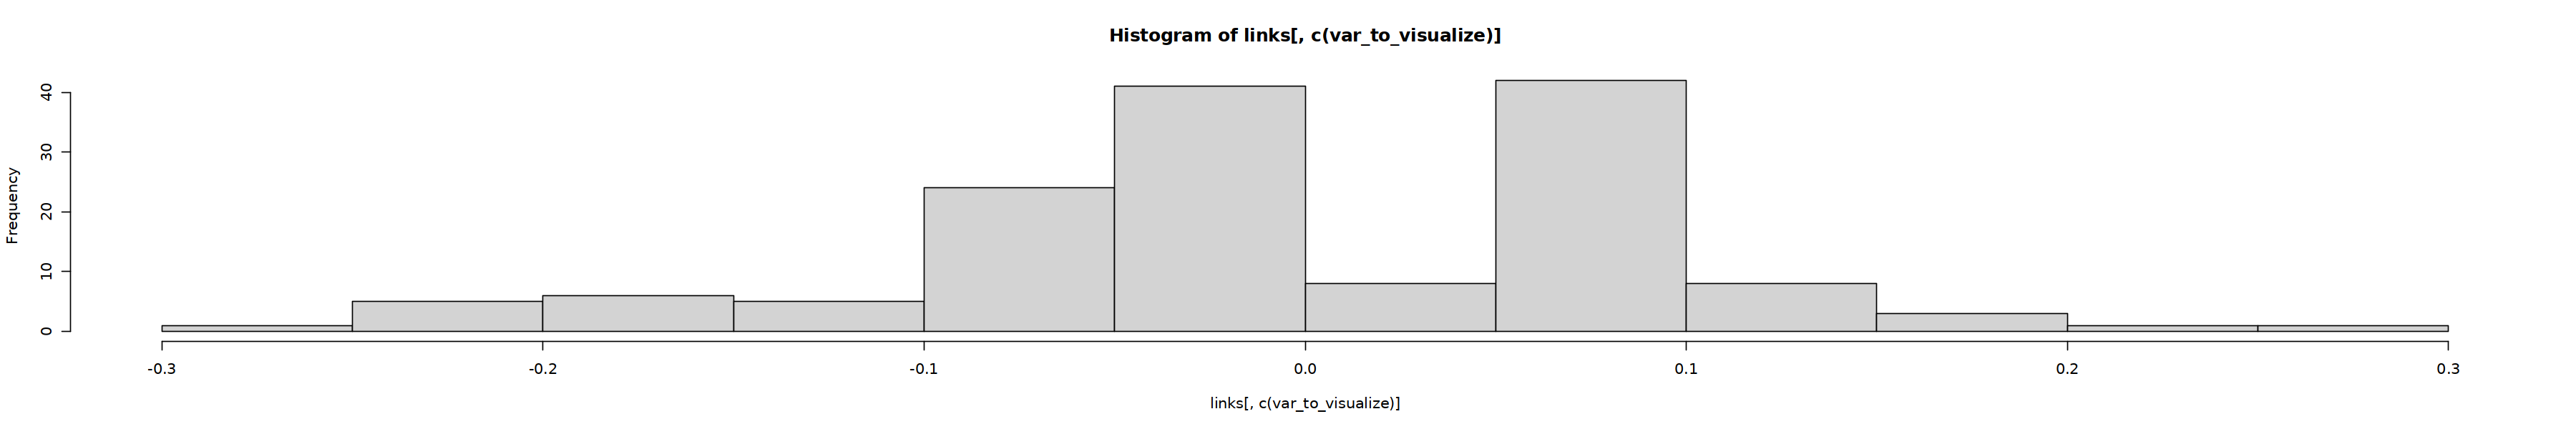

In [625]:
options(repr.plot.width=30, repr.plot.height=5)
hist(links[,c(var_to_visualize)])

In [626]:
var_threshold = 0

In [627]:
### Prepare visualization

In [628]:
head(links,2)

ident                              ident_R                          
3505 single_cell_0_X0_T.cell.CD4__ANXA1 single_cell_0_X1_T.cell.CD8__CD44
3511 single_cell_0_X0_T.cell.CD4__ANXA1 single_cell_0_X10_B.cell__CXCR4  
     Receptor Ligand amount_sources weight    interaction_type type       
3505 CD44     ANXA1  1              0.1670956 Ligand           single_cell
3511 CXCR4    ANXA1  1              0.2522842 Ligand           single_cell
     cluster       perc_cells_expressing_gene ⋯ mean_expr_R var_expression_R
3505 X0_T.cell.CD4 94.11433                   ⋯ 1.452045    0.03203534      
3511 X0_T.cell.CD4 94.11433                   ⋯ 2.914693    0.28710697      
     cell_type_R cluster_vis_R cluster_number_R variable_R          
3505 T.cell.CD8  7             1                X1_T.cell.CD8_0_CD44
3511 B.cell      6             10               X10_B.cell_0_CXCR4  
     interaction_score correlation correlation_weight_interaction
3505 0.009810022        0.3086779   0.05157872                   
3511 0.029730895       -0.3650563  -0.09209795                   
     correlation_weight_expression_interaction
3505 0.001639211                              
3511 0.007500637

In [629]:
links$title = paste0('Correlation: ', round(links$correlation,2), '/ Weight: ', round(links$weight,2), '/ Interaction Score: ', round(links$interaction_score,2))

In [630]:
links = links[,c('variable', 'variable_R','title', var_to_visualize)]

In [631]:
colnames(links) = c('from', 'to','title',  'width')

In [632]:
head(links,2)

from                  to                  
3505 X0_T.cell.CD4_0_ANXA1 X1_T.cell.CD8_0_CD44
3511 X0_T.cell.CD4_0_ANXA1 X10_B.cell_0_CXCR4  
     title                                                     width      
3505 Correlation: 0.31/ Weight: 0.17/ Interaction Score: 0.01   0.05157872
3511 Correlation: -0.37/ Weight: 0.25/ Interaction Score: 0.03 -0.09209795

In [633]:
### Set threshold

In [634]:
#### Filter ! -- minimum interaction score in order to display link and nodes   --> ! should probably be different for neutrophils due to different expression values
links = links[abs(links$width) > var_threshold,]

In [635]:
links$width = links$width *10

In [636]:
links$color = '#0BB35C'

In [637]:
links$color[links$width < 0] = '#B31F0B'

In [638]:
#### Nodes

In [639]:
nodes = analyze_expr_cluster

In [640]:
nodes$id = nodes$variable

In [641]:
nodes$name = nodes$gene

In [642]:
nodes$color[nodes$cluster == 'proteomics'] = '#2FE6EC'
nodes$color[nodes$cluster == 'cytokine'] = '#0E2D9F'
nodes$color[nodes$cluster == 'neutrophil'] = '#CA580E'
nodes$color[nodes$cluster %in%  c('X0_T.cell.CD4','X11_T.cell.CD4','X2_T.cell.CD4', 'X5_T.cell.CD4')  ] = '#E38DE5'
nodes$color[nodes$cluster %in%  c('X4_Monocytes...CD14','X6_Monocytes...CD14','X7_Monocytes...CD14')  ] = '#F1E984'
nodes$color[nodes$cluster %in%  c('X10_B.cell','X8_B.cell')  ] = '#8C75AD'
nodes$color[nodes$cluster %in%  c('X13_Dendritic')  ] = '#E6B17F'
nodes$color[nodes$cluster %in%  c('X1_T.cell.CD8')  ] = '#EC349B'
nodes$color[nodes$cluster %in%  c('X12_Monocytes...CD16_FCGR3A','X9_Monocytes...CD16_FCGR3A' )  ] = '#DCF39D'
nodes$color[nodes$cluster %in%  c('X3_NK' )  ] = '#9DB8F3'

In [643]:
unique(nodes$color)

[1] "#2FE6EC" "#EC349B" "#F1E984" "#DCF39D" "#CA580E" "#E6B17F" "#E38DE5"
 [8] "#8C75AD" "#9DB8F3" "#0E2D9F"

In [644]:
nodes$shape = 'dot'

In [645]:
nodes$shape[nodes$interaction_type == 'Receptor'] = 'triangle'

In [646]:
nodes$value = round(nodes$mean_expr_norm,2) *10

In [647]:
head(nodes,2)

interaction_type gene type        cluster       perc_cells_expressing_gene
1 Ligand           A2M  proteomics  proteomics    41.34211                  
2 Ligand           A2M  single_cell X1_T.cell.CD8 11.31416                  
  total_amount_cells_expressing_gene ident                           
1   NA                               proteomics_0_A2M_P01023         
2 2235                               single_cell_0_X1_T.cell.CD8__A2M
  mean_expr_norm mean_expr var_expression cell_type  cluster_vis cluster_number
1 0.86719027     8.7445302 0.324685780    proteomics 3           NA            
2 0.02045723     0.1758183 0.007878232    T.cell.CD8 3           1             
  variable            id                  name color   shape value
1 proteomics_0_A2M    proteomics_0_A2M    A2M  #2FE6EC dot   8.7  
2 X1_T.cell.CD8_0_A2M X1_T.cell.CD8_0_A2M A2M  #EC349B dot   0.2

In [648]:
nodes = nodes[nodes$variable %in% c(links$from, links$to),]

In [649]:
#nodes = nodes %>% group_by(gene,type, cluster, perc_cells_expressing_gene, total_amount_cells_expressing_gene,  mean_expr, var_expression, cell_type, variable, id, name, color, value) %>% summarise(shape = max(shape),interaction_type = max(interaction_type)) 

In [650]:
length(unique(nodes$id))

[1] 170

In [651]:
nodes[nodes$id == 'neutrophil_0_ITGAL',]

interaction_type gene type cluster perc_cells_expressing_gene
     total_amount_cells_expressing_gene ident mean_expr_norm mean_expr
     var_expression cell_type cluster_vis cluster_number variable id name color
     shape value

In [652]:
nodes$type = nodes$interaction_type

In [653]:
nodes$type = TRUE

In [654]:
nodes$type[nodes$type == 'Receptor'] = FALSE

In [655]:
nrow(nodes)

[1] 170

In [656]:
#head(nodes)

In [657]:
#### Plot Graph

In [658]:
library('visNetwork')

In [659]:
graph = visNetwork(nodes, links, width="100%", height="800px") %>%  visEdges(arrows = 'to') %>%
    visOptions(highlightNearest = list(enabled = TRUE, degree = 1, labelOnly = FALSE, hover = FALSE, algorithm = 'hierarchical', hideColor = '#0000FF00',labelOnly =TRUE  ), 
               #selectedBy = list(variable = "gene", selected = ligand,  style = 'width: 200px; height: 26px;
               #                  background: #ffffff;
               #                  color: darkblue;
               #                  border:none;
               #                  outline:none;', hideColor = '#0000FF00', highlight = TRUE, multiple = TRUE)
              ) %>%

               #nodesIdSelection = list(enabled = TRUE,
               #                  selected = "1",
               #                  style = 'width: 200px; height: 26px;
               #                  background: #ffffff;
               #                  color: darkblue;
               #                  border:none;
               #                  outline:none;')) %>%
    #visLayout(randomSeed = 123, improvedLayout = TRUE) %>% 
    #visPhysics(enabled =TRUE, stabilization = list(itearations = 100)) %>% 
    #visClusteringByGroup(groups = unique(nodes$group), label = 'Grouped: ', color = 'mediumaquamarine',  shape = 'triangle') %>%   # define which nodes should be collapsed
    #visLegend(addNodes = legend, width = 0.1, position = "right", main = "Type", useGroups = FALSE) %>% 
    visIgraphLayout(layout = 'layout_nicely')   #  'layout_with_lgl', #layout_with_fr #layout_nicely #layout_in_circle #layout_on_sphere #layout_as bipartite? #layout_as_tree

visSave(graph, paste0('figures/F_Ligand_Receptors/F4_Test_Ligand_Receptor_Network_.html'), selfcontained = TRUE, background = "white")

# Visualize Ligand Target Correlations

## Circoplot Visualization

### Factor specific - highest ligand target correlations

In [103]:
data_vis = ligand_target_correlation

In [104]:
data_vis$correlation = round(data_vis$correlation,2)

In [105]:
test = data_vis[ (!is.na(str_extract(data_vis$Target_Gene, 'VCAN'))) &(!is.na(str_extract(data_vis$Ligand_Gene, 'IL6'))),]

In [106]:
head(test[order(abs(test$correlation), decreasing = TRUE),],4)

V1      Ligand_Gene Target_Gene cluster             Ligand             
1 2179612 IL6         VCAN        X7_Monocytes...CD14 cytokine_0_IL6__IL6
2 2179610 IL6         VCAN        X6_Monocytes...CD14 cytokine_0_IL6__IL6
3 2179611 IL6         VCAN        X4_Monocytes...CD14 cytokine_0_IL6__IL6
  Target                                  correlation
1 single_cell_0_X7_Monocytes...CD14__VCAN 0.47       
2 single_cell_0_X6_Monocytes...CD14__VCAN 0.31       
3 single_cell_0_X4_Monocytes...CD14__VCAN 0.28       
  Target_Type                       Ligand_Type regulatory_potential
1 single_cell_0_X7_Monocytes...CD14 cytokine    0.001363396         
2 single_cell_0_X6_Monocytes...CD14 cytokine    0.001363396         
3 single_cell_0_X4_Monocytes...CD14 cytokine    0.001363396         
  regulatory_potential_scaled Target_Cell_Type     Ligand_Cell_Type
1 0.04918248                  CD14(high) Monocytes Cytokine        
2 0.04918248                  CD14(high) Monocytes Cytokine        
3 0.04918248                  CD14(high) Monocytes Cytokine        
  Ligand_Cluster_Text Target_Cluster_Text              Ligand_Cluster_Number
1 Cytokine            CD14(high) Monocytes (Cluster 7) Cytokine             
2 Cytokine            CD14(high) Monocytes (Cluster 6) Cytokine             
3 Cytokine            CD14(high) Monocytes (Cluster 4) Cytokine             
  Target_Cluster_Number
1 7                    
2 6                    
3 4

In [107]:
#ligand_target_correlation[(ligand_target_correlation$Target_Gene == 'JUNB') & (ligand_target_correlation$Ligand_Gene == 'NAMPT'),]

##### Parameters

In [108]:
head(data_vis,2)

V1 Ligand_Gene Target_Gene cluster   
1 1  ADAM17      A1BG        proteomics
2 2  ADAM17      A1BG        proteomics
  Ligand                                    Target                  
1 single_cell_0_X6_Monocytes...CD14__ADAM17 proteomics_0_A1BG_M0R009
2 single_cell_0_X4_Monocytes...CD14__ADAM17 proteomics_0_A1BG_M0R009
  correlation Target_Type Ligand_Type                      
1 -0.18       proteomics  single_cell_0_X6_Monocytes...CD14
2 -0.14       proteomics  single_cell_0_X4_Monocytes...CD14
  regulatory_potential regulatory_potential_scaled Target_Cell_Type
1 0.0004622894         0.01667641                  Proteomics      
2 0.0004622894         0.01667641                  Proteomics      
  Ligand_Cell_Type     Ligand_Cluster_Text              Target_Cluster_Text
1 CD14(high) Monocytes CD14(high) Monocytes (Cluster 6) Proteomics         
2 CD14(high) Monocytes CD14(high) Monocytes (Cluster 4) Proteomics         
  Ligand_Cluster_Number Target_Cluster_Number
1 6                     Proteomics           
2 4                     Proteomics

In [109]:
### Define which ligand target correlations to show based on regulatory potential score
use_thres = 'quant_new' # alternative 'percent' , 'quant_new'
reg_pot_thres_var = '95%'   # for 'quant': currently based on top x% of regulatory potential scores of input data --> ! dependent on input data
lig_thres = 0.1  # for 'percent': top percentage of targets per ligand --> all ligands same amount of targets
reg_pot_quant = '97.0%' # for quant_new: select on complete regulatory potential scores the top 95% 


In [110]:
#### Set figure name
figure_name = 'FIG9_Circo'

In [111]:
### select a regulatory potential threshold

if(use_thres == 'quant'){
    reg_pot_thres = quantile(data_vis$regulatory_potential, probs = seq(0, 1, 0.001))[reg_pot_thres_var]
    top_targets_per_ligand = ligand_target_matrix_long[ligand_target_matrix_long$regulatory_potential > reg_pot_thres,]
    }

if(use_thres == 'percent'){
    top_targets_per_ligand = ligand_target_matrix_long[ligand_target_matrix_long$regulatory_potential > 0,]  %>% group_by(ligand) %>% arrange( desc(regulatory_potential),  .by_group = TRUE)  %>% top_frac(lig_thres)
    }

if(use_thres == 'quant_new'){
    reg_pot_thres = quantile(ligand_target_matrix_long$regulatory_potential, probs = seq(0, 1, 0.001))[reg_pot_quant]
    top_targets_per_ligand = ligand_target_matrix_long[ligand_target_matrix_long$regulatory_potential > reg_pot_thres,]
    }


In [112]:
#quantile(ligand_target_matrix_long$regulatory_potential, probs = seq(0, 1, 0.001))

In [113]:
min(top_targets_per_ligand$regulatory_potential)

[1] 0.001211081

In [114]:
### select a correlation threshold; which correlations will be shown
cor_thres = 0.4

In [115]:
### Filter only on Mofa Factors, Select the amount of variables to take
top_variable_fraction = 0.01
geneset_oi_selection = 'positive' # alternatives: 'positive', 'negative', 'all' --> decide on which features take as targets
factor = 'Factor1'
filter_factor = TRUE

In [116]:
### Filter only on a specific cell-type as target
filter_cell_type = FALSE # or add cell-type to filter fore

In [117]:
### Define variable that should show interaction-sizes 

In [118]:
#data_vis$interaction_size = abs(data_vis$correlation)
data_vis$interaction_size = data_vis$regulatory_potential_scaled

##### Prepare data

In [119]:
data_vis = data_vis[abs(data_vis$correlation) >= cor_thres,]

In [120]:
# Filter on selected targets for ligand
data_vis = merge(data_vis, top_targets_per_ligand, by.x = c('Ligand_Gene', 'Target_Gene'), by.y = c('ligand', 'target'))


In [121]:
#### Filter on selected top genes of MOFA factor

## Select geneset OI
geneset_oi_pos_per_factor = feature_weights_long %>% group_by(variable) %>% arrange( desc(value),  .by_group = TRUE)  %>% top_frac(top_variable_fraction)
geneset_oi_pos_per_factor$direction = 'positive'

geneset_oi_neg_per_factor = feature_weights_long %>% group_by(variable) %>% arrange(desc(value),  .by_group = TRUE)  %>% top_frac(-top_variable_fraction)
geneset_oi_neg_per_factor$direction = 'negative'

if(geneset_oi_selection == 'all'){
    geneset_oi = rbind(geneset_oi_pos_per_factor, geneset_oi_neg_per_factor)
    }
if(geneset_oi_selection == 'positive'){
    geneset_oi = geneset_oi_pos_per_factor
    }
if(geneset_oi_selection == 'negative'){
    geneset_oi = geneset_oi_neg_per_factor
    }

geneset_oi = geneset_oi[geneset_oi$variable == factor,]

nrow(geneset_oi)

if(filter_cell_type != FALSE){
    geneset_oi = geneset_oi[geneset_oi$type_cluster %in% filter_cell_type,]
    }

if(filter_factor == TRUE){
    data_vis = data_vis[(data_vis$Target %in% unique(geneset_oi$variable_name_conc)),] ## ! only filtered on target not ligand!
     }
    

Selecting by value
Selecting by value


[1] 132

In [122]:
head(geneset_oi,2)

type        variable_name       type_cluster
1 single_cell X0_T.cell.CD4__PFN1 X0_TcellCD4 
2 single_cell X0_T.cell.CD4__CYBA X0_TcellCD4 
  variable_name_conc                variable value     direction
1 single_cell_0_X0_T.cell.CD4__PFN1 Factor1  0.5391310 positive 
2 single_cell_0_X0_T.cell.CD4__CYBA Factor1  0.5244921 positive

In [123]:
head(data_vis,2)

Ligand_Gene Target_Gene V1     cluster      
1 CALM1       JUNB        430784 X5_T.cell.CD4
2 CALM1       JUNB        430805 X2_T.cell.CD4
  Ligand                             Target                           
1 single_cell_0_X1_T.cell.CD8__CALM1 single_cell_0_X5_T.cell.CD4__JUNB
2 single_cell_0_X10_B.cell__CALM1    single_cell_0_X2_T.cell.CD4__JUNB
  correlation Target_Type                 Ligand_Type                
1 -0.40       single_cell_0_X5_T.cell.CD4 single_cell_0_X1_T.cell.CD8
2 -0.43       single_cell_0_X2_T.cell.CD4 single_cell_0_X10_B.cell   
  regulatory_potential.x regulatory_potential_scaled Target_Cell_Type
1 0.001372257            0.04950216                  CD4+ T cells    
2 0.001372257            0.04950216                  CD4+ T cells    
  Ligand_Cell_Type Ligand_Cluster_Text      Target_Cluster_Text     
1 CD8+ T cells     CD8+ T cells (Cluster 1) CD4+ T cells (Cluster 5)
2 B cells          B cells (Cluster 10)     CD4+ T cells (Cluster 2)
  Ligand_Cluster_Number Target_Cluster_Number interaction_size
1 1                     5                     0.04950216      
2 10                    2                     0.04950216      
  regulatory_potential.y
1 0.001372257           
2 0.001372257

In [124]:
## Add factor values to the data (use original feature weights instead of filtered geneset_oi to also add weights for ligands that are not among top genes)

In [125]:
factor_value_merge = feature_weights_long[feature_weights_long$variable == factor,][,c('variable_name_conc', 'value')]

In [126]:
## Add for ligands

In [127]:
colnames(factor_value_merge) = c('Ligand', 'Ligand_factor_weight')

In [128]:
head(factor_value_merge,2)

Ligand                Ligand_factor_weight
1 clinical_data_0_CK    -0.13418597         
2 clinical_data_0_CK_MB -0.06222621

In [129]:
data_vis = merge(data_vis, factor_value_merge,by = 'Ligand',  all.x = TRUE)

In [130]:
## Add for Targets

In [131]:
colnames(factor_value_merge) = c('Target', 'Target_factor_weight')

In [132]:
data_vis = merge(data_vis, factor_value_merge, by = 'Target', all.x = TRUE)

In [133]:
head(data_vis,2)

Target                            
1 single_cell_0_X0_T.cell.CD4__CLIC1
2 single_cell_0_X0_T.cell.CD4__CLIC1
  Ligand                                           Ligand_Gene Target_Gene
1 single_cell_0_X12_Monocytes...CD16_FCGR3A__NAMPT NAMPT       CLIC1      
2 single_cell_0_X1_T.cell.CD8__CD2                 CD2         CLIC1      
  V1      cluster       correlation Target_Type                
1 2486424 X0_T.cell.CD4 -0.40       single_cell_0_X0_T.cell.CD4
2  849244 X0_T.cell.CD4  0.41       single_cell_0_X0_T.cell.CD4
  Ligand_Type                               regulatory_potential.x ⋯
1 single_cell_0_X12_Monocytes...CD16_FCGR3A 0.001842364            ⋯
2 single_cell_0_X1_T.cell.CD8               0.001453365            ⋯
  Target_Cell_Type Ligand_Cell_Type       Ligand_Cluster_Text                
1 CD4+ T cells     FCGR3A(high) Monocytes FCGR3A(high) Monocytes (Cluster 12)
2 CD4+ T cells     CD8+ T cells           CD8+ T cells (Cluster 1)           
  Target_Cluster_Text      Ligand_Cluster_Number Target_Cluster_Number
1 CD4+ T cells (Cluster 0) 12                    0                    
2 CD4+ T cells (Cluster 0) 1                     0                    
  interaction_size regulatory_potential.y Ligand_factor_weight
1 0.06646054       0.001842364            -0.3056532          
2 0.05242799       0.001453365             0.3208104          
  Target_factor_weight
1 0.4889695           
2 0.4889695

In [134]:
#data_vis

In [135]:
data_vis[data_vis$Ligand_Cell_Type == 'Cytokine',]

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


Target Ligand Ligand_Gene Target_Gene V1 cluster correlation Target_Type
     Ligand_Type regulatory_potential.x ⋯ Target_Cell_Type Ligand_Cell_Type
     Ligand_Cluster_Text Target_Cluster_Text Ligand_Cluster_Number
     Target_Cluster_Number interaction_size regulatory_potential.y
     Ligand_factor_weight Target_factor_weight

In [136]:
### Calculate p-values for selected visualized correlations (and keep only significant ones)
# not possible at the moment --> need to add original expression data

In [137]:
length(unique(data_vis$Ligand))

[1] 16

In [138]:
length(unique(data_vis$Target))

[1] 13

In [139]:
#ligand_target_correlation_test = cor_test(
#  expression_data,
#  vars = all_of(unique(data_vis$Ligand)),
#  vars2 = all_of(unique(data_vis$Target)),
#  alternative = "two.sided",
#  method = "spearman",
#  conf.level = 0.95,
#  use = "pairwise.complete.obs"
#)

In [140]:
#colnames(ligand_target_correlation_test) = c('Ligand', 'Target', 'correlation_test', 'statistic', 'p', 'method') 

In [141]:
#head(ligand_target_correlation_test[order(ligand_target_correlation_test$Ligand),],2)

In [142]:
#data_vis = merge(data_vis, ligand_target_correlation_test)

In [143]:
#max(data_vis$p)   # all significant?

In [144]:
#p_thres = 0.05

In [145]:
#data_vis = data_vis[data_vis$p <= p_thres,]

In [146]:
head(data_vis,2)

Target                            
1 single_cell_0_X0_T.cell.CD4__CLIC1
2 single_cell_0_X0_T.cell.CD4__CLIC1
  Ligand                                           Ligand_Gene Target_Gene
1 single_cell_0_X12_Monocytes...CD16_FCGR3A__NAMPT NAMPT       CLIC1      
2 single_cell_0_X1_T.cell.CD8__CD2                 CD2         CLIC1      
  V1      cluster       correlation Target_Type                
1 2486424 X0_T.cell.CD4 -0.40       single_cell_0_X0_T.cell.CD4
2  849244 X0_T.cell.CD4  0.41       single_cell_0_X0_T.cell.CD4
  Ligand_Type                               regulatory_potential.x ⋯
1 single_cell_0_X12_Monocytes...CD16_FCGR3A 0.001842364            ⋯
2 single_cell_0_X1_T.cell.CD8               0.001453365            ⋯
  Target_Cell_Type Ligand_Cell_Type       Ligand_Cluster_Text                
1 CD4+ T cells     FCGR3A(high) Monocytes FCGR3A(high) Monocytes (Cluster 12)
2 CD4+ T cells     CD8+ T cells           CD8+ T cells (Cluster 1)           
  Target_Cluster_Text      Ligand_Cluster_Number Target_Cluster_Number
1 CD4+ T cells (Cluster 0) 12                    0                    
2 CD4+ T cells (Cluster 0) 1                     0                    
  interaction_size regulatory_potential.y Ligand_factor_weight
1 0.06646054       0.001842364            -0.3056532          
2 0.05242799       0.001453365             0.3208104          
  Target_factor_weight
1 0.4889695           
2 0.4889695

In [147]:
colnames(data_vis)

[1] "Target"                      "Ligand"                     
 [3] "Ligand_Gene"                 "Target_Gene"                
 [5] "V1"                          "cluster"                    
 [7] "correlation"                 "Target_Type"                
 [9] "Ligand_Type"                 "regulatory_potential.x"     
[11] "regulatory_potential_scaled" "Target_Cell_Type"           
[13] "Ligand_Cell_Type"            "Ligand_Cluster_Text"        
[15] "Target_Cluster_Text"         "Ligand_Cluster_Number"      
[17] "Target_Cluster_Number"       "interaction_size"           
[19] "regulatory_potential.y"      "Ligand_factor_weight"       
[21] "Target_factor_weight"

In [148]:
### Define variable that defines ticks --> dimension/ segments shown
### should be the smallest unit (currently genes)
data_vis$plot_var = data_vis$Ligand
data_vis$plot_var_R = data_vis$Target

In [149]:
head(data_vis,2)

Target                            
1 single_cell_0_X0_T.cell.CD4__CLIC1
2 single_cell_0_X0_T.cell.CD4__CLIC1
  Ligand                                           Ligand_Gene Target_Gene
1 single_cell_0_X12_Monocytes...CD16_FCGR3A__NAMPT NAMPT       CLIC1      
2 single_cell_0_X1_T.cell.CD8__CD2                 CD2         CLIC1      
  V1      cluster       correlation Target_Type                
1 2486424 X0_T.cell.CD4 -0.40       single_cell_0_X0_T.cell.CD4
2  849244 X0_T.cell.CD4  0.41       single_cell_0_X0_T.cell.CD4
  Ligand_Type                               regulatory_potential.x ⋯
1 single_cell_0_X12_Monocytes...CD16_FCGR3A 0.001842364            ⋯
2 single_cell_0_X1_T.cell.CD8               0.001453365            ⋯
  Ligand_Cluster_Text                 Target_Cluster_Text     
1 FCGR3A(high) Monocytes (Cluster 12) CD4+ T cells (Cluster 0)
2 CD8+ T cells (Cluster 1)            CD4+ T cells (Cluster 0)
  Ligand_Cluster_Number Target_Cluster_Number interaction_size
1 12                    0                     0.06646054      
2 1                     0                     0.05242799      
  regulatory_potential.y Ligand_factor_weight Target_factor_weight
1 0.001842364            -0.3056532           0.4889695           
2 0.001453365             0.3208104           0.4889695           
  plot_var                                        
1 single_cell_0_X12_Monocytes...CD16_FCGR3A__NAMPT
2 single_cell_0_X1_T.cell.CD8__CD2                
  plot_var_R                        
1 single_cell_0_X0_T.cell.CD4__CLIC1
2 single_cell_0_X0_T.cell.CD4__CLIC1

In [150]:
colnames(data_vis)

[1] "Target"                      "Ligand"                     
 [3] "Ligand_Gene"                 "Target_Gene"                
 [5] "V1"                          "cluster"                    
 [7] "correlation"                 "Target_Type"                
 [9] "Ligand_Type"                 "regulatory_potential.x"     
[11] "regulatory_potential_scaled" "Target_Cell_Type"           
[13] "Ligand_Cell_Type"            "Ligand_Cluster_Text"        
[15] "Target_Cluster_Text"         "Ligand_Cluster_Number"      
[17] "Target_Cluster_Number"       "interaction_size"           
[19] "regulatory_potential.y"      "Ligand_factor_weight"       
[21] "Target_factor_weight"        "plot_var"                   
[23] "plot_var_R"

In [151]:
### Aggregate by defined variables (on this level probably not necessary)

In [152]:
data_vis = data_vis %>% group_by(
    plot_var, plot_var_R, # Variables for segement definition (smallest unit)
    Ligand_Type, Target_Type, Ligand_Cell_Type, Target_Cell_Type,  # Variables for color definition (based on cell-types currently)
    Ligand_Gene, Target_Gene, Ligand_factor_weight, Target_factor_weight, # Variables for text description 
    Ligand_Cluster_Text, Target_Cluster_Text, 
    Ligand_Cluster_Number, Target_Cluster_Number) %>% summarise (
    interaction_size = sum(interaction_size) , # Aggregate variable for segment size
    weight = mean(abs(correlation)), # Aggregate variable for transparency
    correlation = mean(correlation) # variable for potentially changing color
)  

`summarise()` has grouped output by 'plot_var', 'plot_var_R', 'Ligand_Type',
'Target_Type', 'Ligand_Cell_Type', 'Target_Cell_Type', 'Ligand_Gene',
'Target_Gene', 'Ligand_factor_weight', 'Target_factor_weight',
'Ligand_Cluster_Text', 'Target_Cluster_Text', 'Ligand_Cluster_Number'. You can
override using the `.groups` argument.


In [153]:
data_vis[data_vis$Ligand_Cell_Type == 'Cytokine',]

plot_var plot_var_R Ligand_Type Target_Type Ligand_Cell_Type
     Target_Cell_Type Ligand_Gene Target_Gene Ligand_factor_weight
     Target_factor_weight Ligand_Cluster_Text Target_Cluster_Text
     Ligand_Cluster_Number Target_Cluster_Number interaction_size weight
     correlation

In [154]:
head(data_vis,2)

plot_var                           plot_var_R                        
1 single_cell_0_X0_T.cell.CD4__CD2   single_cell_0_X1_T.cell.CD8__CLIC1
2 single_cell_0_X1_T.cell.CD8__CALM1 single_cell_0_X5_T.cell.CD4__JUNB 
  Ligand_Type                 Target_Type                 Ligand_Cell_Type
1 single_cell_0_X0_T.cell.CD4 single_cell_0_X1_T.cell.CD8 CD4+ T cells    
2 single_cell_0_X1_T.cell.CD8 single_cell_0_X5_T.cell.CD4 CD8+ T cells    
  Target_Cell_Type Ligand_Gene Target_Gene Ligand_factor_weight
1 CD8+ T cells     CD2         CLIC1        0.3758228          
2 CD4+ T cells     CALM1       JUNB        -0.3922435          
  Target_factor_weight Ligand_Cluster_Text      Target_Cluster_Text     
1 0.4760339            CD4+ T cells (Cluster 0) CD8+ T cells (Cluster 1)
2 0.4421466            CD8+ T cells (Cluster 1) CD4+ T cells (Cluster 5)
  Ligand_Cluster_Number Target_Cluster_Number interaction_size weight
1 0                     1                     0.05242799       0.51  
2 1                     5                     0.04950216       0.40  
  correlation
1  0.51      
2 -0.40

In [155]:
### Define links and order

In [156]:
## Define how to order ligands
ordered_data_sender = data_vis %>% arrange(Ligand_Cell_Type,
                                           Ligand_Gene, 
                                           Ligand_Cluster_Number, 
                                           Target_Cell_Type, 
                                           Target_Cluster_Number)

In [157]:
## Define how to order targets
ordered_data_receiver = data_vis %>% arrange(Target_Cell_Type, 
                                             Target_Gene, 
                                             Target_Cluster_Number, 
                                             Ligand_Cell_Type, 
                                             Ligand_Cluster_Number)

In [158]:
order = c(ordered_data_sender$plot_var, ordered_data_receiver$plot_var_R)

In [159]:
## Order data_vis dataset

In [160]:
data_vis = ordered_data_sender

In [161]:
links_circle = data_vis[,c('plot_var', 'plot_var_R', 'interaction_size')]
colnames(links_circle) = c('ligand' , 'target', 'weight')

In [162]:
## Define Color Scheme

In [163]:
color_scheme = data.frame(
    color = c("#3c75af",
             "#e1833d",
             "#4e9b6d",
             "#c43b36",
             "#6d5296",
             "#845950",
             "#c67dac",
             "#b6bc6d",
             "#59b4c6",
             "#b1c5e4",
             "#efbc82",
             "#a5c88e",
             "#e69998",
              "#c0b0d2",
             "#330FED",
             "#07580A",
             "#9F8918",
             "#128890"),
    cluster = c( "CD4+ T cells (Cluster 0)",  
                "CD8+ T cells (Cluster 1)",
                "CD4+ T cells (Cluster 2)" ,
                "NK cells (Cluster 3)",
               "CD14(high) Monocytes (Cluster 4)",
               "CD4+ T cells (Cluster 5)",
               "CD14(high) Monocytes (Cluster 6)",
               "CD14(high) Monocytes (Cluster 7)",
               "B cells (Cluster 8)" ,
               "FCGR3A(high) Monocytes (Cluster 9)",
               "B cells (Cluster 10)",
               "CD4+ T cells (Cluster 11)" ,
               "FCGR3A(high) Monocytes (Cluster 12)",
               "Dendritic cells (Cluster 13)" ,
               "Clinical",
               "Cytokine",
               "Neutrophil",
               "Proteomics"))

In [164]:
color_scheme$color_R = color_scheme$color

In [165]:
nrow(data_vis)

[1] 35

In [166]:
data_vis = left_join(data_vis, color_scheme[,c('cluster', 'color')], by = c('Ligand_Cluster_Text' = 'cluster'))

In [167]:
data_vis = left_join(data_vis, color_scheme[,c('cluster', 'color_R')], by = c('Target_Cluster_Text'= 'cluster'))

In [168]:
nrow(data_vis)

[1] 35

In [169]:
grid_col =data_vis[,c('color', 'color_R')]

In [170]:
ligand_color = data_vis %>% distinct(plot_var,color)
grid_ligand_color = ligand_color$color %>% set_names(ligand_color$plot_var)
target_color = data_vis %>% distinct(plot_var_R,color_R)
grid_target_color = target_color$color_R %>% set_names(target_color$plot_var_R)

grid_col =c(grid_ligand_color,grid_target_color)

In [171]:
#### Set text

In [172]:
#text = rbind(data.frame(variable = data_vis$plot_var, text = paste0(data_vis$Ligand_Gene, ' (', data_vis$cluster_number, '| ', round(data_vis$Ligand_factor_weight,2), ')' ) ), 
#             data.frame(variable = data_vis$plot_var_R, text = paste0(data_vis$Target_Gene, ' (', data_vis$cluster_number_T,'| ', round(data_vis$Target_factor_weight,2), ')' )))
text = rbind(data.frame(variable = data_vis$plot_var, text = paste0(data_vis$Ligand_Gene, ' (', data_vis$Ligand_Cluster_Number, ')' ) ), 
             data.frame(variable = data_vis$plot_var_R, text = paste0(data_vis$Target_Gene, ' (', data_vis$Target_Cluster_Number, ')' )))

In [173]:
### Define Legend

In [174]:
lgd1 = Legend(at = unique(c(unique(data_vis$Ligand_Cluster_Text), unique(data_vis$Target_Cluster_Text))), type = "points", 
              labels_gp = gpar(fontsize = 20),
              grid_height = unit(10, "mm"), grid_width = unit(4, "mm"), gap = unit(4, "mm"),
              legend_gp =list(col = unique(c(unique(data_vis$color), unique(data_vis$color_R)))), 
              title_position = "topleft", 
              title = "View", 
              title_gp = gpar(fontsize = 20),
              pch = 16, 
              size = unit(8, "mm"))

In [175]:
lgd_list_vertical = packLegend(lgd1)

In [176]:
### Color for Links based on correlation

In [177]:
## TBD can be used to highlight certain connections

In [178]:
#unique(data_vis$plot_var)

In [179]:
highlighting_factor2 = data.frame(plot_var = c('cytokine_0_IL6__IL6',
                                       'cytokine_0_IL6__IL6', 
                                       'cytokine_0_IL6__IL6',
                                                'cytokine_0_IL6__IL6',
                                      'single_cell_0_X0_T.cell.CD4__HMGB1',
                                      'single_cell_0_X1_T.cell.CD8__HMGB1',
                                      'single_cell_0_X1_T.cell.CD8__HMGB1',
                                      'single_cell_0_X0_T.cell.CD4__HMGB1',
                                      'single_cell_0_X0_T.cell.CD4__HMGB1',
                                      'single_cell_0_X0_T.cell.CD4__HMGB1',
                                              'single_cell_0_X2_T.cell.CD4__HMGB1',
                                              'single_cell_0_X2_T.cell.CD4__HMGB1',
                                              'single_cell_0_X2_T.cell.CD4__HMGB1',
                                              'single_cell_0_X1_T.cell.CD8__HMGB1',
                                              'single_cell_0_X1_T.cell.CD8__TGFB1',
                                              'single_cell_0_X1_T.cell.CD8__TGFB1'),
                          plot_var_R = c( 'single_cell_0_X4_Monocytes...CD14__PIM1',
                                         'single_cell_0_X7_Monocytes...CD14__VCAN', 
                                         'single_cell_0_X7_Monocytes...CD14__CD74',
                                          'single_cell_0_X4_Monocytes...CD14__CD74',
                                        'single_cell_0_X1_T.cell.CD8__UBC',
                                        'single_cell_0_X0_T.cell.CD4__UBC',
                                        'single_cell_0_X2_T.cell.CD4__UBC',
                                        'single_cell_0_X4_Monocytes...CD14__PSME2',
                                        'single_cell_0_X6_Monocytes...CD14__PSME2',
                                        'single_cell_0_X7_Monocytes...CD14__PSME2',
                                        'single_cell_0_X4_Monocytes...CD14__PSME2',
                                        'single_cell_0_X6_Monocytes...CD14__PSME2',
                                        'single_cell_0_X7_Monocytes...CD14__PSME2',
                                        'single_cell_0_X4_Monocytes...CD14__PSME2',
                                         'single_cell_0_X4_Monocytes...CD14__ODC1',
                                         'single_cell_0_X0_T.cell.CD4__ODC1'
                                 ))

In [180]:
data_vis[data_vis$Target_Gene == 'PTMA',]

plot_var plot_var_R Ligand_Type Target_Type Ligand_Cell_Type
     Target_Cell_Type Ligand_Gene Target_Gene Ligand_factor_weight
     Target_factor_weight Ligand_Cluster_Text Target_Cluster_Text
     Ligand_Cluster_Number Target_Cluster_Number interaction_size weight
     correlation color color_R

In [181]:
head(data_vis,2)

plot_var                        plot_var_R                       
1 single_cell_0_X10_B.cell__CALM1 single_cell_0_X2_T.cell.CD4__JUNB
2 single_cell_0_X8_B.cell__CALM1  single_cell_0_X2_T.cell.CD4__JUNB
  Ligand_Type              Target_Type                 Ligand_Cell_Type
1 single_cell_0_X10_B.cell single_cell_0_X2_T.cell.CD4 B cells         
2 single_cell_0_X8_B.cell  single_cell_0_X2_T.cell.CD4 B cells         
  Target_Cell_Type Ligand_Gene Target_Gene Ligand_factor_weight
1 CD4+ T cells     CALM1       JUNB        -0.3156618          
2 CD4+ T cells     CALM1       JUNB        -0.3314573          
  Target_factor_weight Ligand_Cluster_Text  Target_Cluster_Text     
1 0.4286883            B cells (Cluster 10) CD4+ T cells (Cluster 2)
2 0.4286883            B cells (Cluster 8)  CD4+ T cells (Cluster 2)
  Ligand_Cluster_Number Target_Cluster_Number interaction_size weight
1 10                    2                     0.04950216       0.43  
2 8                     2                     0.04950216       0.52  
  correlation color   color_R
1 -0.43       #efbc82 #4e9b6d
2 -0.52       #59b4c6 #4e9b6d

In [182]:
highlighting_factor1 = data.frame(plot_var = c('single_cell_0_X2_T.cell.CD4__ICAM3',
                                       'single_cell_0_X5_T.cell.CD4__ICAM3', 
                                       'single_cell_0_X11_T.cell.CD4__ICAM3',
                                      'single_cell_0_X0_T.cell.CD4__ICAM3',
                                      'single_cell_0_X0_T.cell.CD4__CALM1',
                                      'single_cell_0_X5_T.cell.CD4__CALM1',
                                      'single_cell_0_X1_T.cell.CD8__CALM1',
                                    'single_cell_0_X11_T.cell.CD4__CALM1',
                                       'single_cell_0_X2_T.cell.CD4__CALM1',
                                       'single_cell_0_X3_NK__CALM1',
                                       'single_cell_0_X13_Dendritic__CALM1',
                                       'single_cell_0_X4_Monocytes...CD14__CALM1',
                                       'single_cell_0_X10_B.cell__CALM1',
                                       'single_cell_0_X8_B.cell__CALM1',
                                      'single_cell_0_X12_Monocytes...CD16_FCGR3A__NAMPT',
                                      'single_cell_0_X12_Monocytes...CD16_FCGR3A__NAMPT',
                                       'single_cell_0_X9_Monocytes...CD16_FCGR3A__NAMPT',
                                          'single_cell_0_X9_Monocytes...CD16_FCGR3A__NAMPT',
                                              'single_cell_0_X8_B.cell__CALM1'),
                          plot_var_R = c( 'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA', 
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                        'single_cell_0_X1_T.cell.CD8__PTMA',
                                        'single_cell_0_X1_T.cell.CD8__PTMA',
                                        'single_cell_0_X1_T.cell.CD8__PTMA',
                                       'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                        'single_cell_0_X2_T.cell.CD4__JUNB',
                                        'single_cell_0_X5_T.cell.CD4__JUNB',
                                        'single_cell_0_X2_T.cell.CD4__JUNB',
                                        'single_cell_0_X5_T.cell.CD4__JUNB',
                                        'single_cell_0_X0_T.cell.CD4__PTMA'))

In [183]:
if(factor == 'Factor1'){
    highlighting = unique(highlighting_factor1)
    }
if(factor == 'Factor2'){
     highlighting = unique(highlighting_factor2)
    }

In [184]:
#unique(data_vis$plot_var)

In [185]:
#unique(data_vis$plot_var_R)

In [186]:
col_mat = data_vis[,c('plot_var', 'plot_var_R', 'correlation')]
col_mat$color = '#CBCBCB'
col_mat$color[col_mat$correlation < 0 ] = '#9B2502'
col_mat$color[col_mat$correlation > 0 ] = '#029B35'
#col_mat = col_mat$color

In [187]:
col_mat_special = merge(col_mat, highlighting)
col_mat_rest = anti_join(col_mat, highlighting)

Joining, by = c("plot_var", "plot_var_R")


In [188]:
special_colors = c('#34063B', '#065553')   # define special colors for highlighting specific examples

In [189]:
col_mat_special$color[col_mat_special$correlation < 0] = special_colors[1]
col_mat_special$color[col_mat_special$correlation > 0] = special_colors[2]

In [190]:
#head(data_vis[,c('plot_var', 'plot_var_R')],2)

In [191]:
col_mat = rbind(col_mat_special, col_mat_rest)
#col_mat = col_mat$color

In [192]:
col_mat = left_join(data_vis[,c('plot_var', 'plot_var_R')], col_mat )


Joining, by = c("plot_var", "plot_var_R")


In [193]:
col_mat = col_mat$color

In [194]:
nrow(col_mat)
nrow(col_mat_special)
nrow(col_mat_rest)

NULL

[1] 4

[1] 31

In [195]:
head(col_mat,2)

[1] "#9B2502" "#9B2502"

In [196]:
unique(col_mat)

[1] "#9B2502" "#029B35" "#34063B"

In [197]:
length(col_mat)

[1] 35

In [198]:
#### Define transparency based on a value

In [199]:
data_vis = as.data.frame(data_vis) # grouping needs to be removed from dataframe

In [200]:
## currently defined based on weight (could also be used for highlighting)

# transparency =data_vis %>% mutate(weight =(weight-min(weight))/(max(weight)-min(weight))) %>% mutate(transparency = 1-weight) %>% .$transparency 
# old implementation scale based on correlation (but dependent on correlation range)

# New: fix thresholds based on correlation
transparency = abs(data_vis$correlation)
transparency[data_vis$correlation < 0.4] = 0.9
transparency[(data_vis$correlation < 0.5) & (data_vis$correlation >= 0.4)] = 0.7
transparency[data_vis$correlation >= 0.5] = 0.5
transparency[col_mat  %in% special_colors]= 0   # no transparency for highlighted cases

In [201]:
length(col_mat)

[1] 35

In [202]:
length(abs(data_vis$correlation))

[1] 35

In [203]:
head(transparency)

[1] 0.9 0.9 0.9 0.9 0.9 0.5

In [204]:
length(transparency)

[1] 35

In [205]:
nrow(data_vis)

[1] 35

In [206]:
min(abs(data_vis$correlation))

[1] 0.4

In [207]:
name

[1] "V_FINAL"

In [208]:
circos.clear()

In [209]:
circos.par(track.height = 0.25, unit.circle.segments =250)

In [210]:
tail(order)

[1] "single_cell_0_X1_T.cell.CD8__LCK" "single_cell_0_X3_NK__CLIC1"      
[3] "single_cell_0_X3_NK__CLIC1"       "single_cell_0_X3_NK__CLIC1"      
[5] "single_cell_0_X3_NK__CLIC1"       "single_cell_0_X3_NK__CLIC1"

In [211]:
tail(col_mat,10)

[1] "#9B2502" "#34063B" "#9B2502" "#9B2502" "#029B35" "#9B2502" "#9B2502"
 [8] "#9B2502" "#9B2502" "#9B2502"

In [212]:
length(col_mat)

[1] 35

In [213]:
nrow(data_vis)

[1] 35

In [214]:
head(links_circle,2)

ligand                          target                            weight    
1 single_cell_0_X10_B.cell__CALM1 single_cell_0_X2_T.cell.CD4__JUNB 0.04950216
2 single_cell_0_X8_B.cell__CALM1  single_cell_0_X2_T.cell.CD4__JUNB 0.04950216

In [215]:
links_circle[(!is.na(str_extract(links_circle$ligand, 'HMGB1'))) & (!is.na(str_extract(links_circle$target, 'PSME2'))),]

ligand target weight

In [216]:
links_circle[ (!is.na(str_extract(links_circle$target, 'ODC1'))),]

ligand target weight

In [217]:
head(data_vis[(data_vis$Ligand_Cell_Type == 'Cytokine')  &(data_vis$Ligand_Gene == 'LIF') ,],40)

plot_var plot_var_R Ligand_Type Target_Type Ligand_Cell_Type
     Target_Cell_Type Ligand_Gene Target_Gene Ligand_factor_weight
     Target_factor_weight Ligand_Cluster_Text Target_Cluster_Text
     Ligand_Cluster_Number Target_Cluster_Number interaction_size weight
     correlation color color_R

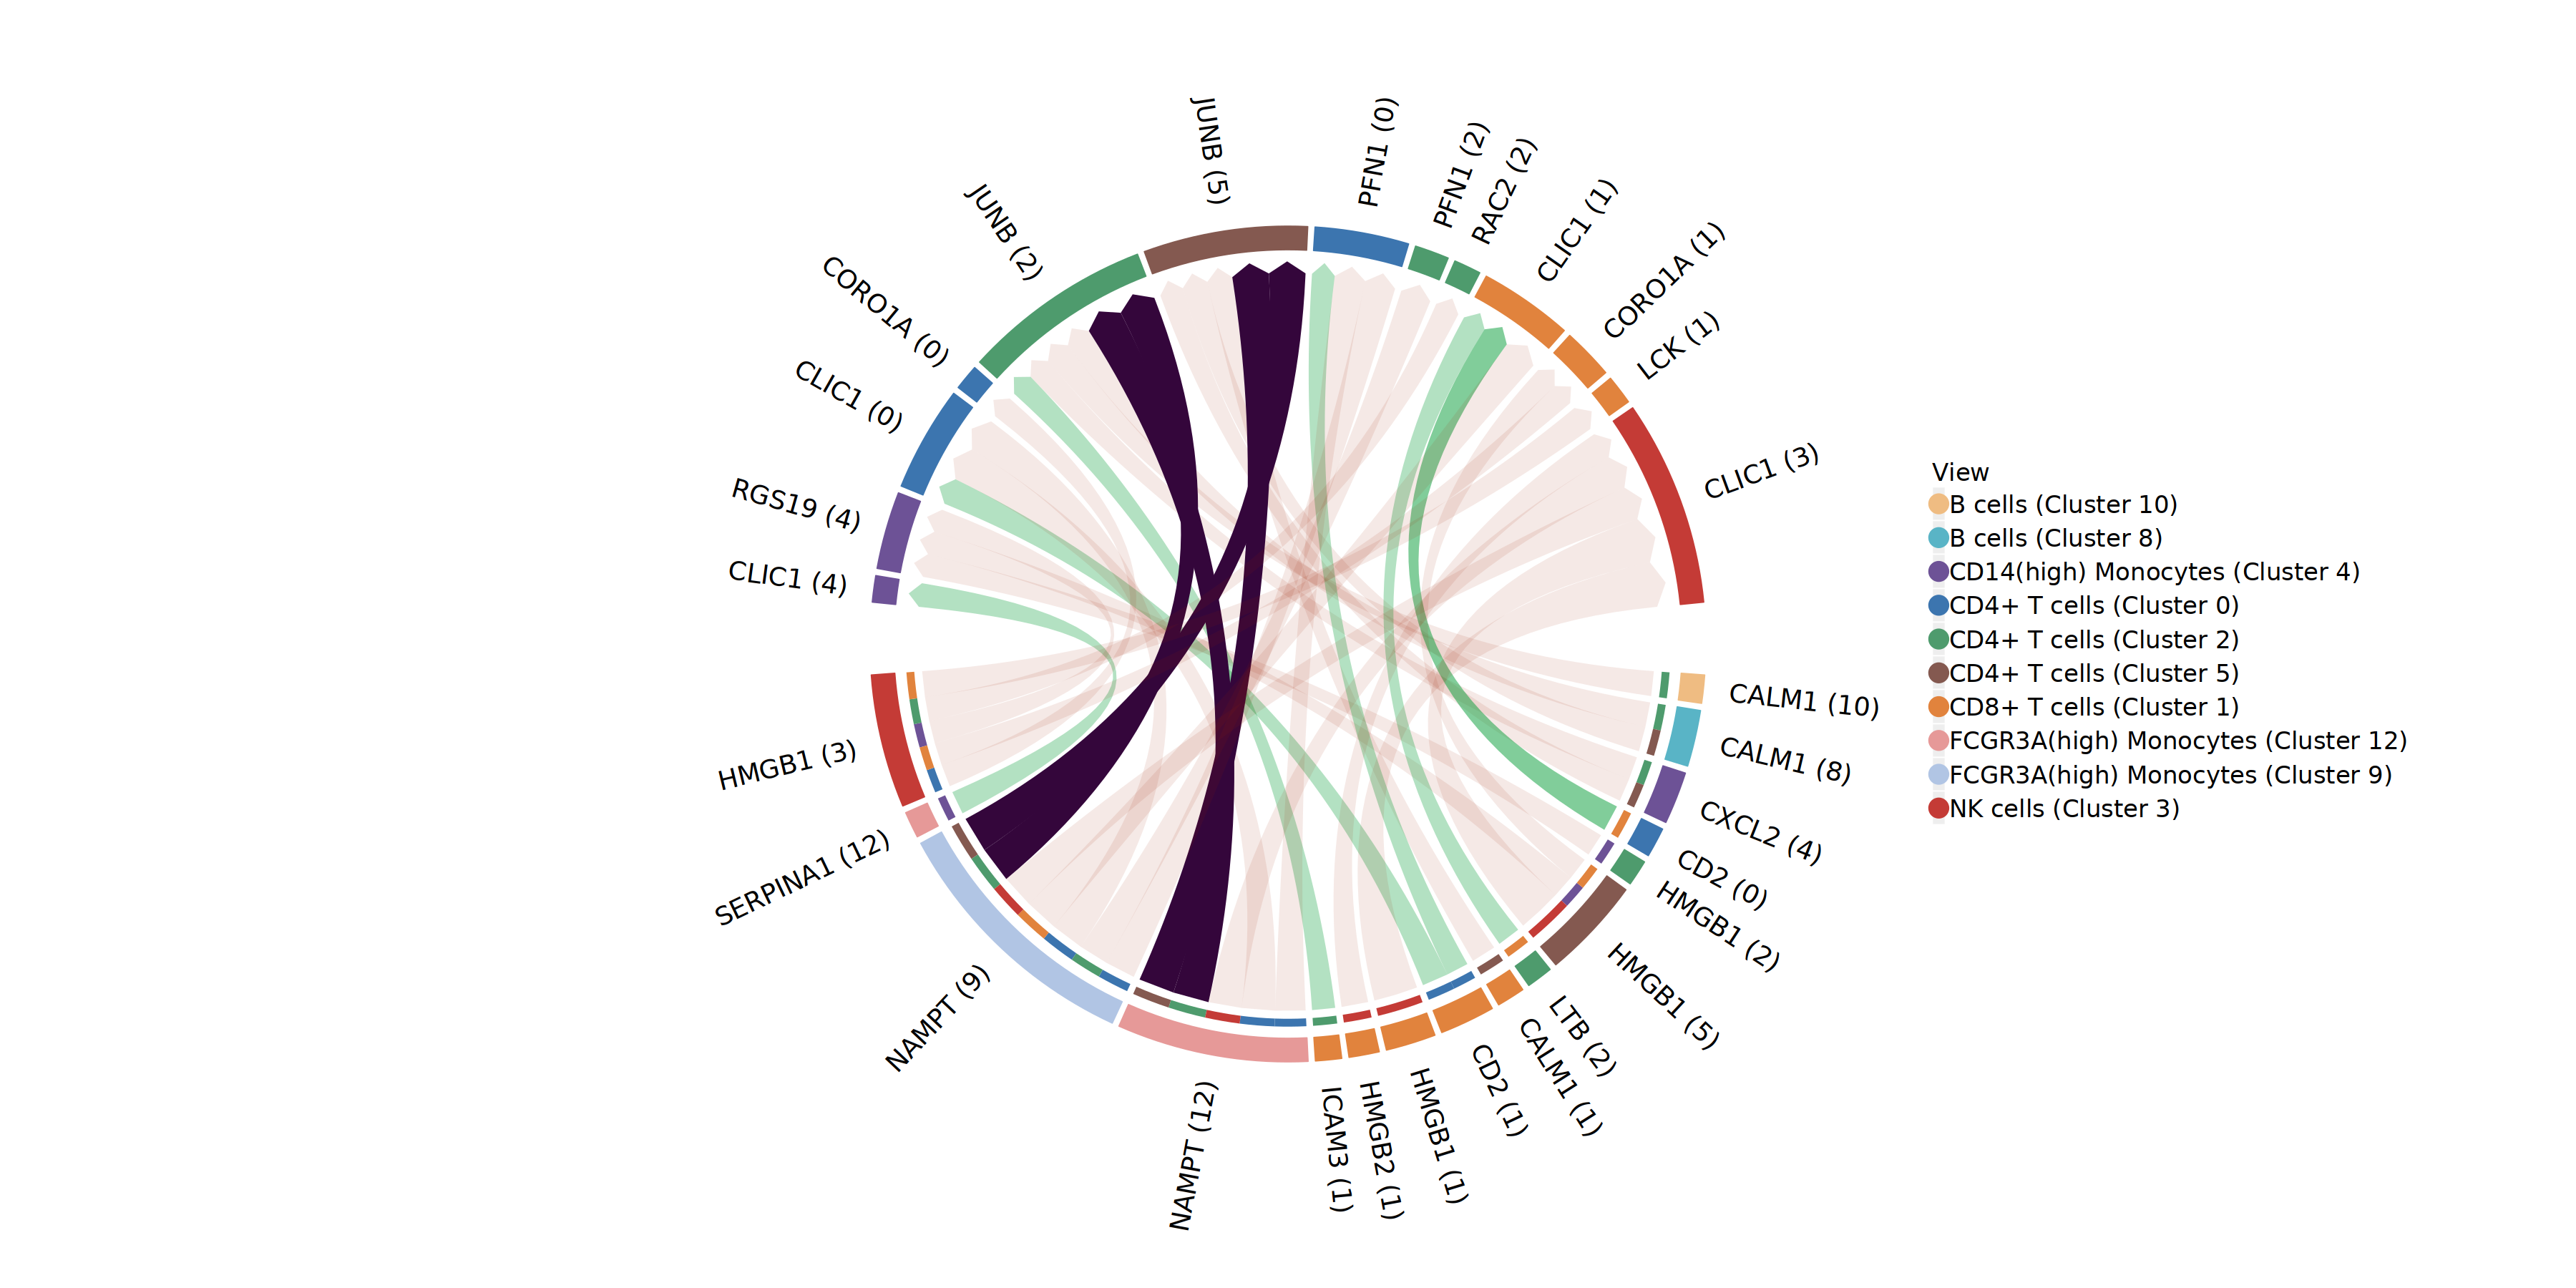

In [218]:
options(repr.plot.width=30, repr.plot.height=15)
chordDiagram(links_circle, directional = 1, order=order,link.sort = TRUE, link.decreasing = FALSE,col = col_mat, grid.col = grid_col, transparency = transparency, direction.type = c("diffHeight", "arrows"),  link.arr.type = "big.arrow", annotationTrack = c( "grid"), preAllocateTracks = 1, title(
    main = paste0('' ), cex.main = 1.5))
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  # sector.name = 
  circos.text(mean(xlim), ylim[1] + .1, text$text[text$variable == get.cell.meta.data("sector.index")], facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5),  cex = 1.8)
  #circos.axis(h = "top", labels.cex = 0.5, major.tick.length = 0.2, sector.index = get.cell.meta.data("sector.index"), track.index = 2)
}, bg.border = NA)
### Add legend
draw(lgd_list_vertical, x = unit(1.5, "snpc"), just = "left")

In [570]:
options(repr.plot.width=30, repr.plot.height=15)
if(use_thres == 'quant_new'){
    pdf(paste0('figures/Final_Figures/', figure_name, '_', factor, '_',name, '_', top_variable_fraction, '_', cor_thres,'_' ,str_replace(reg_pot_thres_var, '%', ''),geneset_oi_selection, filter_samples, '.pdf'), 
        width = 4, 
        height = 4)
    }


chordDiagram(links_circle, directional = 1, 
             order=order,link.sort = TRUE, 
             link.decreasing = FALSE,
             col = col_mat, 
             grid.col = grid_col, 
             transparency = transparency, 
             direction.type = c("diffHeight", "arrows"),  
             link.arr.type = "big.arrow", 
             annotationTrack = c( "grid"), 
             preAllocateTracks = 1, 
             title(main = paste0('Top ', top_variable_fraction *100, '% ', geneset_oi_selection, ' features' ), cex.main = 0.7))
circos.trackPlotRegion( track.height = 0.01, track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  # sector.name = 
  circos.text(mean(xlim), ylim[1] + .1, text$text[text$variable == get.cell.meta.data("sector.index")], cex = 0.5, facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
  #circos.axis(h = "top", labels.cex = 0.5, major.tick.length = 0.2, sector.index = get.cell.meta.data("sector.index"), track.index = 2)
}, bg.border = NA)
### Add legend
draw(lgd_list_vertical, x = unit(1.5, "snpc"), just = "left")

dev.off()

png 
  2

In [571]:
top_variable_fraction

[1] 0.01

### Generate a legend

In [2114]:
head(color_scheme,2)

color   cluster                  color_R
1 #3c75af CD4+ T cells (Cluster 0) #3c75af
2 #e1833d CD8+ T cells (Cluster 1) #e1833d

In [2115]:
legend_add = Legend(at = unique(color_scheme$cluster), type = "points", 
              labels_gp = gpar(fontsize = 20),
              grid_height = unit(20, "mm"), grid_width = unit(205, "mm"), gap = unit(0.1, "mm"),
              legend_gp =list(col = unique(color_scheme$color)), 
              title_position = "topleft", 
              title = "View", 
              title_gp = gpar(fontsize = 20),
              pch = 2, 
              size = unit(3, "mm"), ncol = 8)

No legend element is put in the last 2 columns under `ncol = 8`, maybe
you should set `by_row = TRUE`? Reset `ncol` to 6.



In [2116]:
legend_add  = Legend(labels = unique(color_scheme$cluster), labels_gp = gpar(fontsize = 8),legend_gp =list(col = unique(c(unique(color_scheme$color)))), 
    nrow = 5, type = 'points') 

In [2117]:
legend_add_vertical = packLegend(legend_add, direction = "horizontal")

In [2118]:
pdf(paste0('figures/Final_Figures/Circo_Legend_Text', '.pdf'), 
    width =8.07, 
    height = 1)
draw(legend_add_vertical)
dev.off()

png 
  2

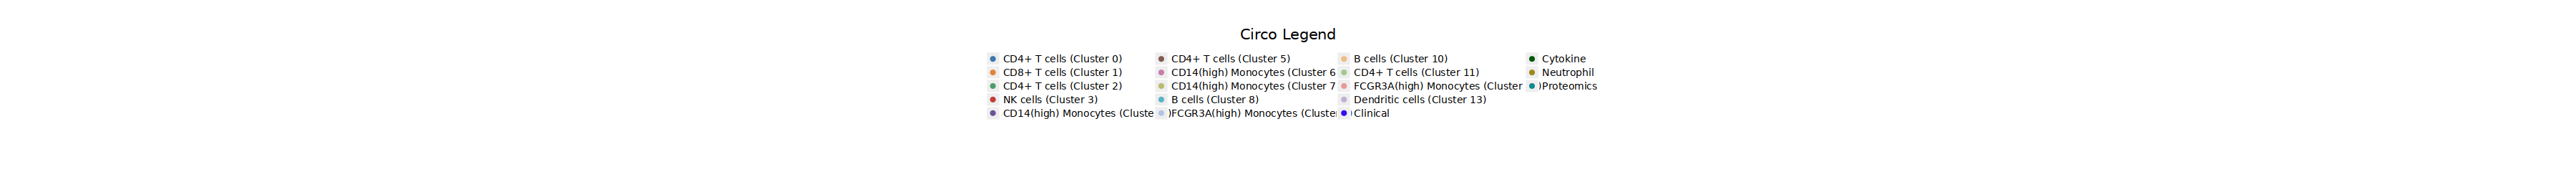

In [2119]:
options(repr.plot.width=30, repr.plot.height=2)
draw(legend_add_vertical, test = "Circo Legend")

### Scatterplot for single correlations

In [572]:
head(data_long,2)

X sample_id type        variable             value    
1 1 k10       single_cell X0_T.cell.CD4__SSU72 0.5896835
2 2 k10       single_cell X0_T.cell.CD4__PARK7 0.8587511
  config                          
1 FALSE-FALSE-TRUE-0.2-FALSE-TRUE-
2 FALSE-FALSE-TRUE-0.2-FALSE-TRUE-

In [573]:
head(ligand_target_correlation,2)

V1 Ligand_Gene Target_Gene cluster   
1 1  ADAM17      A1BG        proteomics
2 2  ADAM17      A1BG        proteomics
  Ligand                                    Target                  
1 single_cell_0_X6_Monocytes...CD14__ADAM17 proteomics_0_A1BG_M0R009
2 single_cell_0_X4_Monocytes...CD14__ADAM17 proteomics_0_A1BG_M0R009
  correlation Target_Type Ligand_Type                      
1 -0.1841739  proteomics  single_cell_0_X6_Monocytes...CD14
2 -0.1387664  proteomics  single_cell_0_X4_Monocytes...CD14
  regulatory_potential regulatory_potential_scaled Target_Cell_Type
1 0.0004622894         0.01667641                  Proteomics      
2 0.0004622894         0.01667641                  Proteomics      
  Ligand_Cell_Type     Ligand_Cluster_Text              Target_Cluster_Text
1 CD14(high) Monocytes CD14(high) Monocytes (Cluster 6) Proteomics         
2 CD14(high) Monocytes CD14(high) Monocytes (Cluster 4) Proteomics         
  Ligand_Cluster_Number Target_Cluster_Number
1 6                     Proteomics           
2 4                     Proteomics

In [574]:
data_vis[(data_vis$Ligand_Gene == 'LIF') &  (data_vis$Target_Gene == 'PTMA'),]

plot_var plot_var_R Ligand_Type Target_Type Ligand_Cell_Type
     Target_Cell_Type Ligand_Gene Target_Gene Ligand_factor_weight
     Target_factor_weight Ligand_Cluster_Text Target_Cluster_Text
     Ligand_Cluster_Number Target_Cluster_Number interaction_size weight
     correlation color color_R

In [719]:

#unique(data_vis$plot_var_R)

In [746]:
correlation_var1 = c(
    'single_cell_0_X1_T.cell.CD8__HMGB1',
    'single_cell_0_X0_T.cell.CD4__HMGB1',
    'cytokine_0_IL6__IL6',
    'cytokine_0_IL6__IL6',
    'cytokine_0_IL6__IL6',
    'single_cell_0_X0_T.cell.CD4__ICAM3',
    'single_cell_0_X0_T.cell.CD4__CALM1',
    'single_cell_0_X9_Monocytes...CD16_FCGR3A__NAMPT',
    'single_cell_0_X1_T.cell.CD8__TGFB1',
'single_cell_0_X8_B.cell__CALM1',
'cytokine_0_LIF__LIF')
correlation_var2 = c(
    'single_cell_0_X0_T.cell.CD4__UBC',
    'single_cell_0_X6_Monocytes...CD14__PSME2',
    'single_cell_0_X7_Monocytes...CD14__CD74',
    'single_cell_0_X7_Monocytes...CD14__VCAN',
    'single_cell_0_X4_Monocytes...CD14__PIM1',
    'single_cell_0_X1_T.cell.CD8__PTMA',
    'single_cell_0_X1_T.cell.CD8__PTMA',
    'single_cell_0_X5_T.cell.CD4__JUNB',
    'single_cell_0_X4_Monocytes...CD14__ODC1',
'single_cell_0_X0_T.cell.CD4__PTMA',
'single_cell_0_X0_T.cell.CD4__PTMA')

In [747]:
correlation_var1 = correlation_var1[11]
correlation_var2 = correlation_var2[11]

In [748]:
plot_data = data_long[(data_long$variable %in% c(str_replace(correlation_var1, '.*_0_', ''), str_replace(correlation_var2, '.*_0_', ''))),]

In [749]:
plot_data = plot_data %>% dcast(sample_id ~ variable, value.var = 'value')

Warning message in dcast(., sample_id ~ variable, value.var = "value"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error.”


In [750]:
plot_correlation = ligand_target_correlation[(ligand_target_correlation$Ligand == correlation_var1) &(ligand_target_correlation$Target == correlation_var2),] 

In [751]:
head(plot_correlation)

V1      Ligand_Gene Target_Gene cluster       Ligand             
1 2281658 LIF         PTMA        X0_T.cell.CD4 cytokine_0_LIF__LIF
  Target                            correlation Target_Type                
1 single_cell_0_X0_T.cell.CD4__PTMA -0.1963101  single_cell_0_X0_T.cell.CD4
  Ligand_Type regulatory_potential regulatory_potential_scaled Target_Cell_Type
1 cytokine    0.002088332          0.07533347                  CD4+ T cells    
  Ligand_Cell_Type Ligand_Cluster_Text Target_Cluster_Text     
1 Cytokine         Cytokine            CD4+ T cells (Cluster 0)
  Ligand_Cluster_Number Target_Cluster_Number
1 Cytokine              0

In [752]:
# Specific Text Descriptions:
xlabel = xlab(paste0(plot_correlation$Ligand_Gene, ' (', plot_correlation$Ligand_Cluster_Number, ')'))
ylabel = ylab(paste0(plot_correlation$Target_Gene, ' (', plot_correlation$Target_Cluster_Number, ')'))

In [753]:
colnames(plot_data ) = c('sample_id', 'var1', 'var2')

In [754]:
figure_name = "FIG11_Scatter_"

In [755]:
# Sizes of the plot
width_par = 1.3
height_par = 1.6

In [756]:
if(plot_correlation$correlation > 0){
    annotations <- data.frame(
      xpos = c(-Inf), ypos =  c(-Inf),
      annotateText = paste0('cor = ', round(plot_correlation$correlation,2)),
      hjustvar = c(-0.9), #-0.1
      vjustvar = c(-1.4))
    }

if(plot_correlation$correlation < 0){
    annotations <- data.frame(
      xpos = c(-Inf), ypos =  c(-Inf),
      annotateText = paste0('cor = ', round(plot_correlation$correlation,2)),
      hjustvar = c(-0.1), #-0.1
      vjustvar = c(-1.5))
    }

In [757]:
if(plot_correlation$correlation < 0){

    scatter = ggplot(plot_data, aes(x=var1, y=var2)) +
      geom_point(size=0.2) +
      geom_text(data = annotations, aes(x = xpos, y = ypos, hjust = hjustvar, vjust = vjustvar, label = annotateText), size = 2, color = 'red')+
      plot_config + theme(axis.text.x = element_text(angle = 90)) +
      xlabel +
      ylabel
    }

if(plot_correlation$correlation > 0){
        scatter = ggplot(plot_data, aes(x=var1, y=var2)) +
      geom_point(size=0.2) +
      geom_text(data = annotations, aes(x = xpos, y = ypos, hjust = hjustvar, vjust = vjustvar, label = annotateText), size = 2, color = 'darkgreen')+
      plot_config + theme(axis.text.x = element_text(angle = 90)) +
      xlabel +
      ylabel
    }

In [758]:
pdf(paste0('figures/Final_Figures/', figure_name,plot_correlation$Ligand_Gene, plot_correlation$Target_Gene, filter_samples, '.pdf'), width =width_par, height =height_par)
print(scatter)
dev.off()
    

Warning message:
“Removed 11 rows containing missing values (geom_point).”


png 
  2

### Factor specific - aggregated

In [4098]:
data_vis = ligand_target_correlation

In [4099]:
data_vis = data_vis[data_vis$Target_Type != 'clinical_data',]  # clinical data not really matched to a gene

In [4100]:
data_vis$correlation = round(data_vis$correlation,2)

In [4101]:
nrow(data_vis)

[1] 2720033

In [4102]:
### Calculate potential ligand target correlations calculated

total_amount_ligand_target_interactions = data_vis %>% group_by(Ligand_Cluster_Text, Target_Cluster_Text) %>% count()
colnames(total_amount_ligand_target_interactions) = c('Ligand_Cluster_Text', 'Target_Cluster_Text', 'total_amount_potential_interactions')

total_amount_interactions_per_ligand = total_amount_ligand_target_interactions %>% group_by(Ligand_Cluster_Text) %>% summarise( total_amount_ligand_interactions = sum(total_amount_potential_interactions) )
total_amount_interactions_per_target = total_amount_ligand_target_interactions %>% group_by(Target_Cluster_Text) %>% summarise( total_amount_target_interactions = sum(total_amount_potential_interactions) )

total_amount_ligand_target_interactions = merge(total_amount_ligand_target_interactions, total_amount_interactions_per_target)
total_amount_ligand_target_interactions = merge(total_amount_ligand_target_interactions, total_amount_interactions_per_ligand)

In [4103]:
### Define which ligand target correlations to show based on regulatory potential score
use_thres = 'quant_new' # alternative 'percent' , 'quant_new'
reg_pot_thres_var = '95%'   # for 'quant': currently based on top x% of regulatory potential scores of input data --> ! dependent on input data
lig_thres = 0.1  # for 'percent': top percentage of targets per ligand --> all ligands same amount of targets
reg_pot_quant = '95.0%' # for quant_new: select on complete regulatory potential scores the top 95% 


In [4104]:
### Should the amounts shown be weighted by the total amount of features?
weight_by_features = FALSE

In [4105]:
#### Set figure name
figure_name = 'FIG9_2_Circo'

In [4106]:
### select a regulatory potential threshold

if(use_thres == 'quant'){
    reg_pot_thres = quantile(data_vis$regulatory_potential, probs = seq(0, 1, 0.001))[reg_pot_thres_var]
    top_targets_per_ligand = ligand_target_matrix_long[ligand_target_matrix_long$regulatory_potential > reg_pot_thres,]
    }

if(use_thres == 'percent'){
    top_targets_per_ligand = ligand_target_matrix_long[ligand_target_matrix_long$regulatory_potential > 0,]  %>% group_by(ligand) %>% arrange( desc(regulatory_potential),  .by_group = TRUE)  %>% top_frac(lig_thres)
    }

if(use_thres == 'quant_new'){
    reg_pot_thres = quantile(ligand_target_matrix_long$regulatory_potential, probs = seq(0, 1, 0.001))[reg_pot_quant]
    top_targets_per_ligand = ligand_target_matrix_long[ligand_target_matrix_long$regulatory_potential > reg_pot_thres,]
    }


In [4107]:
#quantile(ligand_target_matrix_long$regulatory_potential, probs = seq(0, 1, 0.001))

In [4108]:
reg_pot_thres

95.0% 
0.001044174

In [4109]:
min(top_targets_per_ligand$regulatory_potential)

[1] 0.001044175

In [4110]:
### select a correlation threshold; which correlations will be shown
cor_thres = 0.4

In [4111]:
### Filter only on Mofa Factors, Select the amount of variables to take
top_variable_fraction = 0.025
geneset_oi_selection = 'all' 
factor = 'Factor2'
filter_factor = TRUE

In [4112]:
### Filter only on a specific cell-type as target
filter_cell_type = FALSE # or add cell-type to filter fore

In [4113]:
### Define variable that should show interaction-sizes 

In [4114]:
#data_vis$interaction_size = abs(data_vis$correlation)
#data_vis$interaction_size = data_vis$correlation

##### Prepare data

In [4115]:
#### Filter on selected top genes of MOFA factor

## Select geneset OI
geneset_oi_pos_per_factor = feature_weights_long %>% group_by(variable) %>% arrange( desc(value),  .by_group = TRUE)  %>% top_frac(top_variable_fraction)
geneset_oi_pos_per_factor$direction = 'positive'

geneset_oi_neg_per_factor = feature_weights_long %>% group_by(variable) %>% arrange(desc(value),  .by_group = TRUE)  %>% top_frac(-top_variable_fraction)
geneset_oi_neg_per_factor$direction = 'negative'

if(geneset_oi_selection == 'all'){
    geneset_oi = rbind(geneset_oi_pos_per_factor, geneset_oi_neg_per_factor)
    }

geneset_oi = geneset_oi[geneset_oi$variable == factor,]

nrow(geneset_oi)

if(filter_cell_type != FALSE){
    geneset_oi = geneset_oi[geneset_oi$type_cluster %in% filter_cell_type,]
    }

if(filter_factor == TRUE){
    data_vis = data_vis[(data_vis$Target %in% unique(geneset_oi$variable_name_conc)),] ## ! only filtered on target not ligand!
     }
    

Selecting by value
Selecting by value


[1] 664

In [4116]:
nrow(data_vis)

[1] 134290

In [4117]:
### Define potential ligand-target interactions for selected MOFA subset

amount_ligand_target_interactions = data_vis %>% group_by(Ligand_Cluster_Text, Target_Cluster_Text) %>% count()
colnames(amount_ligand_target_interactions) = c('Ligand_Cluster_Text', 'Target_Cluster_Text', 'total_amount_potential_interactions')

amount_interactions_per_ligand = amount_ligand_target_interactions %>% group_by(Ligand_Cluster_Text) %>% summarise( total_amount_ligand_interactions = sum(total_amount_potential_interactions) )
amount_interactions_per_target = amount_ligand_target_interactions %>% group_by(Target_Cluster_Text) %>% summarise( total_amount_target_interactions = sum(total_amount_potential_interactions) )

amount_ligand_target_interactions = merge(amount_ligand_target_interactions, amount_interactions_per_target)
amount_ligand_target_interactions = merge(amount_ligand_target_interactions,amount_interactions_per_ligand)

In [4118]:
### Filter data_vis based on correlation and regulatory potential threshold

In [4119]:
data_vis = data_vis[abs(data_vis$correlation) >= cor_thres,]

In [4120]:
head(data_vis,2)

V1   Ligand_Gene Target_Gene cluster                   
1 3739 ADAM17      CELF2       X9_Monocytes...CD16_FCGR3A
2 3749 ADAM17      CELF2       X5_T.cell.CD4             
  Ligand                                   
1 single_cell_0_X4_Monocytes...CD14__ADAM17
2 single_cell_0_X4_Monocytes...CD14__ADAM17
  Target                                          correlation
1 single_cell_0_X9_Monocytes...CD16_FCGR3A__CELF2 0.42       
2 single_cell_0_X5_T.cell.CD4__CELF2              0.41       
  Target_Type                              Ligand_Type                      
1 single_cell_0_X9_Monocytes...CD16_FCGR3A single_cell_0_X4_Monocytes...CD14
2 single_cell_0_X5_T.cell.CD4              single_cell_0_X4_Monocytes...CD14
  regulatory_potential regulatory_potential_scaled Target_Cell_Type      
1 0.001026788          0.03703986                  FCGR3A(high) Monocytes
2 0.001026788          0.03703986                  CD4+ T cells          
  Ligand_Cell_Type     Ligand_Cluster_Text             
1 CD14(high) Monocytes CD14(high) Monocytes (Cluster 4)
2 CD14(high) Monocytes CD14(high) Monocytes (Cluster 4)
  Target_Cluster_Text                Ligand_Cluster_Number
1 FCGR3A(high) Monocytes (Cluster 9) 4                    
2 CD4+ T cells (Cluster 5)           4                    
  Target_Cluster_Number
1 9                    
2 5

In [4121]:
head(top_targets_per_ligand,2)

target ligand regulatory_potential
1635 BCL2L1 CXCL1  0.001050431         
1644 BCL3   CXCL1  0.001265603

In [4122]:
# Filter on selected targets for ligand (apply regulatory potential threshold)
data_vis = merge(data_vis, top_targets_per_ligand[,c('target', 'ligand')], by.x = c('Ligand_Gene', 'Target_Gene'), by.y = c('ligand', 'target'))


In [4123]:
#head(data_vis[round(data_vis$regulatory_potential.x,6) != round(data_vis$regulatory_potential.y,6),],2)

In [4124]:
head(data_vis,2)

Ligand_Gene Target_Gene V1   cluster      
1 ADAM17      EEF1A1      6213 X1_T.cell.CD8
2 ADAM17      EEF1A1      6215 X0_T.cell.CD4
  Ligand                                    Target                             
1 single_cell_0_X6_Monocytes...CD14__ADAM17 single_cell_0_X1_T.cell.CD8__EEF1A1
2 single_cell_0_X4_Monocytes...CD14__ADAM17 single_cell_0_X0_T.cell.CD4__EEF1A1
  correlation Target_Type                 Ligand_Type                      
1 -0.40       single_cell_0_X1_T.cell.CD8 single_cell_0_X6_Monocytes...CD14
2 -0.51       single_cell_0_X0_T.cell.CD4 single_cell_0_X4_Monocytes...CD14
  regulatory_potential regulatory_potential_scaled Target_Cell_Type
1 0.001102896          0.03978534                  CD8+ T cells    
2 0.001102896          0.03978534                  CD4+ T cells    
  Ligand_Cell_Type     Ligand_Cluster_Text             
1 CD14(high) Monocytes CD14(high) Monocytes (Cluster 6)
2 CD14(high) Monocytes CD14(high) Monocytes (Cluster 4)
  Target_Cluster_Text      Ligand_Cluster_Number Target_Cluster_Number
1 CD8+ T cells (Cluster 1) 6                     1                    
2 CD4+ T cells (Cluster 0) 4                     0

In [4125]:
length(unique(data_vis$Target))

[1] 184

In [4126]:
#### Amount intereactins on filtered data
amount_top_interactions = data_vis %>% group_by(Target_Cluster_Text, Ligand_Cluster_Text) %>% count()
colnames(amount_top_interactions) = c('Target_Cluster_Text','Ligand_Cluster_Text', 'total_amount_top_interactions')

amount_top_targets_types = amount_top_interactions%>% group_by(Target_Cluster_Text) %>% summarise(amount_top_interactions_target = sum(total_amount_top_interactions))
amount_top_ligand_types = amount_top_interactions%>% group_by(Ligand_Cluster_Text) %>% summarise(amount_top_interactions_ligand = sum(total_amount_top_interactions))

amount_top_interactions = merge(amount_top_interactions, amount_top_targets_types )
amount_top_interactions = merge(amount_top_interactions, amount_top_ligand_types )

overview = merge(amount_ligand_target_interactions, amount_top_interactions)

In [4127]:
head(overview,2)

Ligand_Cluster_Text  Target_Cluster_Text             
1 B cells (Cluster 10) CD14(high) Monocytes (Cluster 4)
2 B cells (Cluster 10) CD4+ T cells (Cluster 0)        
  total_amount_potential_interactions total_amount_target_interactions
1 2422                                36849                           
2 1344                                19296                           
  total_amount_ligand_interactions total_amount_top_interactions
1 8648                             2                            
2 8648                             1                            
  amount_top_interactions_target amount_top_interactions_ligand
1 111                            6                             
2  44                            6

In [4128]:
overview$total_percentage = overview$total_amount_top_interactions / overview$total_amount_potential_interactions

In [4129]:
## Add factor values to the data (use original feature weights instead of filtered geneset_oi to also add weights for ligands that are not among top genes)

In [4130]:
factor_value_merge = feature_weights_long[feature_weights_long$variable == factor,][,c('variable_name_conc', 'value')]

In [4131]:
## Add for ligands

In [4132]:
colnames(factor_value_merge) = c('Ligand', 'Ligand_factor_weight')

In [4133]:
head(factor_value_merge,2)

Ligand                Ligand_factor_weight
13283 clinical_data_0_CK    0.3968507           
13284 clinical_data_0_CK_MB 0.2622791

In [4134]:
data_vis = merge(data_vis, factor_value_merge,by = 'Ligand',  all.x = TRUE)

In [4135]:
## Add for Targets

In [4136]:
colnames(factor_value_merge) = c('Target', 'Target_factor_weight')

In [4137]:
data_vis = merge(data_vis, factor_value_merge, by = 'Target', all.x = TRUE)

In [4138]:
head(data_vis,2)

Target                            
1 single_cell_0_X0_T.cell.CD4__ACTG1
2 single_cell_0_X0_T.cell.CD4__ACTG1
  Ligand                                           Ligand_Gene Target_Gene
1 single_cell_0_X12_Monocytes...CD16_FCGR3A__NAMPT NAMPT       ACTG1      
2 single_cell_0_X3_NK__HMGB1                       HMGB1       ACTG1      
  V1      cluster       correlation Target_Type                
1 2480910 X0_T.cell.CD4 -0.42       single_cell_0_X0_T.cell.CD4
2 1285374 X0_T.cell.CD4 -0.47       single_cell_0_X0_T.cell.CD4
  Ligand_Type                               regulatory_potential
1 single_cell_0_X12_Monocytes...CD16_FCGR3A 0.001144620         
2 single_cell_0_X3_NK                       0.001315339         
  regulatory_potential_scaled Target_Cell_Type Ligand_Cell_Type      
1 0.04129048                  CD4+ T cells     FCGR3A(high) Monocytes
2 0.04744889                  CD4+ T cells     NK cells              
  Ligand_Cluster_Text                 Target_Cluster_Text     
1 FCGR3A(high) Monocytes (Cluster 12) CD4+ T cells (Cluster 0)
2 NK cells (Cluster 3)                CD4+ T cells (Cluster 0)
  Ligand_Cluster_Number Target_Cluster_Number Ligand_factor_weight
1 12                    0                     0.2206819           
2 3                     0                     0.3493588           
  Target_factor_weight
1 -0.3737175          
2 -0.3737175

In [4139]:
#data_vis

In [4140]:
### Calculate p-values for selected visualized correlations (and keep only significant ones)
# not possible at the moment --> need to add original expression data

In [4141]:
length(unique(data_vis$Ligand))

[1] 65

In [4142]:
length(unique(data_vis$Target))

[1] 184

In [4143]:
### Define the variable that should determine interaction size

In [4144]:
unique(data_vis$Ligand_Cell_Type)

[1] "FCGR3A(high) Monocytes" "NK cells"               "B cells"               
[4] "CD8+ T cells"           "CD14(high) Monocytes"   "Cytokine"              
[7] "CD4+ T cells"           "Dendritic cells"        "Neutrophil"

In [4145]:
#data_vis[data_vis$Ligand_Cell_Type == 'NK cells',]

In [4146]:
data_vis$interaction_size = 1 ## count 1 for every correlation interaction that is left after filtering

In [4147]:
#data_vis[data_vis$Ligand_Cell_Type == 'NK cells',]

In [4148]:
nrow(data_vis)

[1] 407

In [4149]:
head(data_vis,2)

Target                            
1 single_cell_0_X0_T.cell.CD4__ACTG1
2 single_cell_0_X0_T.cell.CD4__ACTG1
  Ligand                                           Ligand_Gene Target_Gene
1 single_cell_0_X12_Monocytes...CD16_FCGR3A__NAMPT NAMPT       ACTG1      
2 single_cell_0_X3_NK__HMGB1                       HMGB1       ACTG1      
  V1      cluster       correlation Target_Type                
1 2480910 X0_T.cell.CD4 -0.42       single_cell_0_X0_T.cell.CD4
2 1285374 X0_T.cell.CD4 -0.47       single_cell_0_X0_T.cell.CD4
  Ligand_Type                               regulatory_potential
1 single_cell_0_X12_Monocytes...CD16_FCGR3A 0.001144620         
2 single_cell_0_X3_NK                       0.001315339         
  regulatory_potential_scaled Target_Cell_Type Ligand_Cell_Type      
1 0.04129048                  CD4+ T cells     FCGR3A(high) Monocytes
2 0.04744889                  CD4+ T cells     NK cells              
  Ligand_Cluster_Text                 Target_Cluster_Text     
1 FCGR3A(high) Monocytes (Cluster 12) CD4+ T cells (Cluster 0)
2 NK cells (Cluster 3)                CD4+ T cells (Cluster 0)
  Ligand_Cluster_Number Target_Cluster_Number Ligand_factor_weight
1 12                    0                     0.2206819           
2 3                     0                     0.3493588           
  Target_factor_weight interaction_size
1 -0.3737175           1               
2 -0.3737175           1

In [4150]:
#### Add amount of interactions or features for weighting

In [4151]:
head(total_amount_ligand_target_interactions,2)

Ligand_Cluster_Text  Target_Cluster_Text      
1 B cells (Cluster 10) Neutrophil               
2 B cells (Cluster 10) CD4+ T cells (Cluster 11)
  total_amount_potential_interactions total_amount_target_interactions
1 11830                               240825                          
2  8932                               121858                          
  total_amount_ligand_interactions
1 154536                          
2 154536

In [4152]:
colnames(data_vis)

[1] "Target"                      "Ligand"                     
 [3] "Ligand_Gene"                 "Target_Gene"                
 [5] "V1"                          "cluster"                    
 [7] "correlation"                 "Target_Type"                
 [9] "Ligand_Type"                 "regulatory_potential"       
[11] "regulatory_potential_scaled" "Target_Cell_Type"           
[13] "Ligand_Cell_Type"            "Ligand_Cluster_Text"        
[15] "Target_Cluster_Text"         "Ligand_Cluster_Number"      
[17] "Target_Cluster_Number"       "Ligand_factor_weight"       
[19] "Target_factor_weight"        "interaction_size"

In [4153]:
data_vis = merge(data_vis,total_amount_ligand_target_interactions, by = c('Ligand_Cluster_Text','Target_Cluster_Text'))
### amount of calculated potential ligand target interactions (only takes ligand and target features that map to nichenet in account)

In [4154]:
data_vis$Target_Type = str_replace(data_vis$Target_Type, '.*_0_', '')
data_vis$Target_Type = str_replace_all(data_vis$Target_Type, '\\.', '')

data_vis$Ligand_Type = str_replace(data_vis$Ligand_Type, '.*_0_', '')
data_vis$Ligand_Type = str_replace_all(data_vis$Ligand_Type, '\\.', '')

In [4155]:
nrow(data_vis)

[1] 407

In [4156]:
head(amount_features_per_dimension,2)

Ligand_Type   Target_Type   combined_amount_features
1 clinical_data clinical_data  16                     
2 cytokine      clinical_data 260

In [4157]:
data_vis = merge(data_vis, amount_features_per_dimension, by = c('Ligand_Type', 'Target_Type'))

In [4158]:
head(data_vis,2)

Ligand_Type Target_Type              Ligand_Cluster_Text     
1 X0_TcellCD4 X10_Bcell                CD4+ T cells (Cluster 0)
2 X0_TcellCD4 X12_MonocytesCD16_FCGR3A CD4+ T cells (Cluster 0)
  Target_Cluster_Text                
1 B cells (Cluster 10)               
2 FCGR3A(high) Monocytes (Cluster 12)
  Target                                          
1 single_cell_0_X10_B.cell__HIST1H4C              
2 single_cell_0_X12_Monocytes...CD16_FCGR3A__H3F3B
  Ligand                             Ligand_Gene Target_Gene V1     
1 single_cell_0_X0_T.cell.CD4__HMGB1 HMGB1       HIST1H4C    1353744
2 single_cell_0_X0_T.cell.CD4__HMGB1 HMGB1       H3F3B       1351712
  cluster                     ⋯ Ligand_Cell_Type Ligand_Cluster_Number
1 X10_B.cell                  ⋯ CD4+ T cells     0                    
2 X12_Monocytes...CD16_FCGR3A ⋯ CD4+ T cells     0                    
  Target_Cluster_Number Ligand_factor_weight Target_factor_weight
1 10                    0.4914897            -0.4323247          
2 12                    0.4914897            -0.3479209          
  interaction_size total_amount_potential_interactions
1 1                 8250                              
2 1                11596                              
  total_amount_target_interactions total_amount_ligand_interactions
1 158250                           126828                          
2 206944                           126828                          
  combined_amount_features
1 547648                  
2 647408

In [4159]:
if(weight_by_features == TRUE){
    data_vis$interaction_size = data_vis$interaction_size/ data_vis$combined_amount_features
    }

In [4160]:
nrow(data_vis)

[1] 407

In [4161]:
### Decide how to calculate interaction size

In [4162]:
#data_vis$interaction_size = data_vis$interaction_size/ data_vis$total_amount_potential_interactions

In [4163]:
### Define variable that defines ticks --> dimension/ segments shown
### should be the smallest unit (currently genes)
data_vis$plot_var = paste0(data_vis$Ligand_Cluster_Text, '(L)')
data_vis$plot_var_R = paste0(data_vis$Target_Cluster_Text, '(T)')

In [4164]:
head(data_vis,2)

Ligand_Type Target_Type              Ligand_Cluster_Text     
1 X0_TcellCD4 X10_Bcell                CD4+ T cells (Cluster 0)
2 X0_TcellCD4 X12_MonocytesCD16_FCGR3A CD4+ T cells (Cluster 0)
  Target_Cluster_Text                
1 B cells (Cluster 10)               
2 FCGR3A(high) Monocytes (Cluster 12)
  Target                                          
1 single_cell_0_X10_B.cell__HIST1H4C              
2 single_cell_0_X12_Monocytes...CD16_FCGR3A__H3F3B
  Ligand                             Ligand_Gene Target_Gene V1     
1 single_cell_0_X0_T.cell.CD4__HMGB1 HMGB1       HIST1H4C    1353744
2 single_cell_0_X0_T.cell.CD4__HMGB1 HMGB1       H3F3B       1351712
  cluster                     ⋯ Target_Cluster_Number Ligand_factor_weight
1 X10_B.cell                  ⋯ 10                    0.4914897           
2 X12_Monocytes...CD16_FCGR3A ⋯ 12                    0.4914897           
  Target_factor_weight interaction_size total_amount_potential_interactions
1 -0.4323247           1                 8250                              
2 -0.3479209           1                11596                              
  total_amount_target_interactions total_amount_ligand_interactions
1 158250                           126828                          
2 206944                           126828                          
  combined_amount_features plot_var                   
1 547648                   CD4+ T cells (Cluster 0)(L)
2 647408                   CD4+ T cells (Cluster 0)(L)
  plot_var_R                            
1 B cells (Cluster 10)(T)               
2 FCGR3A(high) Monocytes (Cluster 12)(T)

In [4165]:
colnames(data_vis)

[1] "Ligand_Type"                         "Target_Type"                        
 [3] "Ligand_Cluster_Text"                 "Target_Cluster_Text"                
 [5] "Target"                              "Ligand"                             
 [7] "Ligand_Gene"                         "Target_Gene"                        
 [9] "V1"                                  "cluster"                            
[11] "correlation"                         "regulatory_potential"               
[13] "regulatory_potential_scaled"         "Target_Cell_Type"                   
[15] "Ligand_Cell_Type"                    "Ligand_Cluster_Number"              
[17] "Target_Cluster_Number"               "Ligand_factor_weight"               
[19] "Target_factor_weight"                "interaction_size"                   
[21] "total_amount_potential_interactions" "total_amount_target_interactions"   
[23] "total_amount_ligand_interactions"    "combined_amount_features"           
[25] "plot_var"                            "plot_var_R"

In [4166]:
### Aggregate by defined variables (on this level probably not necessary)

In [4167]:
data_vis = data_vis %>% group_by(
    plot_var, plot_var_R, # Variables for segement definition (smallest unit)
    Ligand_Type, Target_Type, Ligand_Cell_Type, Target_Cell_Type,  # Variables for color definition (based on cell-types currently)
    Ligand_Cluster_Text, Target_Cluster_Text, 
    Ligand_Cluster_Number, Target_Cluster_Number) %>% summarise (
    interaction_size = sum(interaction_size) , # Aggregate variable for segment size
    weight = mean(regulatory_potential), # Aggregate variable for transparency
    correlation = sum(correlation) # variable for potentially changing color
)  

`summarise()` has grouped output by 'plot_var', 'plot_var_R', 'Ligand_Type',
'Target_Type', 'Ligand_Cell_Type', 'Target_Cell_Type', 'Ligand_Cluster_Text',
'Target_Cluster_Text', 'Ligand_Cluster_Number'. You can override using the
`.groups` argument.


In [4168]:
head(data_vis,2)

plot_var                plot_var_R                          Ligand_Type
1 B cells (Cluster 10)(L) CD14(high) Monocytes (Cluster 4)(T) X10_Bcell  
2 B cells (Cluster 10)(L) CD4+ T cells (Cluster 0)(T)         X10_Bcell  
  Target_Type      Ligand_Cell_Type Target_Cell_Type     Ligand_Cluster_Text 
1 X4_MonocytesCD14 B cells          CD14(high) Monocytes B cells (Cluster 10)
2 X0_TcellCD4      B cells          CD4+ T cells         B cells (Cluster 10)
  Target_Cluster_Text              Ligand_Cluster_Number Target_Cluster_Number
1 CD14(high) Monocytes (Cluster 4) 10                    4                    
2 CD4+ T cells (Cluster 0)         10                    0                    
  interaction_size weight      correlation
1 2                0.001112178 0.84       
2 1                0.001144695 0.42

In [4169]:
### Define links and order

In [4170]:
## Define how to order ligands
ordered_data_sender = data_vis %>% arrange(Ligand_Cell_Type, 
                                           Ligand_Cluster_Number, 
                                           Target_Cell_Type, 
                                           Target_Cluster_Number)

In [4171]:
## Define how to order targets
ordered_data_receiver = data_vis %>% arrange(Target_Cell_Type, 
                                             Target_Cluster_Number, 
                                             Ligand_Cell_Type, 
                                             Ligand_Cluster_Number)

In [4172]:
order = c(ordered_data_sender$plot_var, ordered_data_receiver$plot_var_R)

In [4173]:
## Order data_vis dataset

In [4174]:
data_vis = ordered_data_sender

In [4175]:
links_circle = data_vis[,c('plot_var', 'plot_var_R', 'interaction_size')]
colnames(links_circle) = c('ligand' , 'target', 'weight')

In [4176]:
## Define Color Scheme

In [4177]:
color_scheme = data.frame(
    color = c("#3c75af",
             "#e1833d",
             "#4e9b6d",
             "#c43b36",
             "#6d5296",
             "#845950",
             "#c67dac",
             "#b6bc6d",
             "#59b4c6",
             "#b1c5e4",
             "#efbc82",
             "#a5c88e",
             "#e69998",
              "#c0b0d2",
             "#330FED",
             "#07580A",
             "#9F8918",
             "#128890"),
    cluster = c( "CD4+ T cells (Cluster 0)",  
                "CD8+ T cells (Cluster 1)",
                "CD4+ T cells (Cluster 2)" ,
                "NK cells (Cluster 3)",
               "CD14(high) Monocytes (Cluster 4)",
               "CD4+ T cells (Cluster 5)",
               "CD14(high) Monocytes (Cluster 6)",
               "CD14(high) Monocytes (Cluster 7)",
               "B cells (Cluster 8)" ,
               "FCGR3A(high) Monocytes (Cluster 9)",
               "B cells (Cluster 10)",
               "CD4+ T cells (Cluster 11)" ,
               "FCGR3A(high) Monocytes (Cluster 12)",
               "Dendritic cells (Cluster 13)" ,
               "Clinical",
               "Cytokine",
               "Neutrophil",
               "Proteomics"))

In [4178]:
color_scheme$color_R = color_scheme$color

In [4179]:
head(color_scheme,2)

color   cluster                  color_R
1 #3c75af CD4+ T cells (Cluster 0) #3c75af
2 #e1833d CD8+ T cells (Cluster 1) #e1833d

In [4180]:
nrow(data_vis)

[1] 79

In [4181]:
data_vis = left_join(data_vis, color_scheme[,c('cluster', 'color')], by = c('Ligand_Cluster_Text' = 'cluster'))

In [4182]:
data_vis = left_join(data_vis, color_scheme[,c('cluster', 'color_R')], by = c('Target_Cluster_Text'= 'cluster'))

In [4183]:
head(data_vis,2)

plot_var                plot_var_R                          Ligand_Type
1 B cells (Cluster 10)(L) CD14(high) Monocytes (Cluster 4)(T) X10_Bcell  
2 B cells (Cluster 10)(L) CD4+ T cells (Cluster 0)(T)         X10_Bcell  
  Target_Type      Ligand_Cell_Type Target_Cell_Type     Ligand_Cluster_Text 
1 X4_MonocytesCD14 B cells          CD14(high) Monocytes B cells (Cluster 10)
2 X0_TcellCD4      B cells          CD4+ T cells         B cells (Cluster 10)
  Target_Cluster_Text              Ligand_Cluster_Number Target_Cluster_Number
1 CD14(high) Monocytes (Cluster 4) 10                    4                    
2 CD4+ T cells (Cluster 0)         10                    0                    
  interaction_size weight      correlation color   color_R
1 2                0.001112178 0.84        #efbc82 #6d5296
2 1                0.001144695 0.42        #efbc82 #3c75af

In [4184]:
nrow(data_vis)

[1] 79

In [4185]:
grid_col =data_vis[,c('color', 'color_R')]

In [4186]:
ligand_color = data_vis %>% distinct(plot_var,color)
grid_ligand_color = ligand_color$color %>% set_names(ligand_color$plot_var)
target_color = data_vis %>% distinct(plot_var_R,color_R)
grid_target_color = target_color$color_R %>% set_names(target_color$plot_var_R)

grid_col =c(grid_ligand_color,grid_target_color)

In [4187]:
#### Set text

In [4188]:
#text = rbind(data.frame(variable = data_vis$plot_var, text = paste0(data_vis$Ligand_Gene, ' (', data_vis$cluster_number, '| ', round(data_vis$Ligand_factor_weight,2), ')' ) ), 
#             data.frame(variable = data_vis$plot_var_R, text = paste0(data_vis$Target_Gene, ' (', data_vis$cluster_number_T,'| ', round(data_vis$Target_factor_weight,2), ')' )))
text = rbind(data.frame(variable = data_vis$plot_var, text = paste0( data_vis$Ligand_Cluster_Number) ), 
             data.frame(variable = data_vis$plot_var_R, text = paste0( data_vis$Target_Cluster_Number)))

In [4189]:
### Define Legend

In [4190]:
lgd1 = Legend(at = unique(c(unique(data_vis$Ligand_Cluster_Text), unique(data_vis$Target_Cluster_Text))), type = "points", 
              labels_gp = gpar(fontsize = 20),
              grid_height = unit(10, "mm"), grid_width = unit(4, "mm"), gap = unit(4, "mm"),
              legend_gp =list(col = unique(c(unique(data_vis$color), unique(data_vis$color_R)))), 
              title_position = "topleft", 
              title = "View", 
              title_gp = gpar(fontsize = 20),
              pch = 16, 
              size = unit(8, "mm"))

In [4191]:
lgd_list_vertical = packLegend(lgd1)

In [4192]:
### Color for Links based on correlation

In [4193]:
## TBD can be used to highlight certain connections

In [4194]:
#unique(data_vis$plot_var)

In [4195]:
head(data_vis,2)

plot_var                plot_var_R                          Ligand_Type
1 B cells (Cluster 10)(L) CD14(high) Monocytes (Cluster 4)(T) X10_Bcell  
2 B cells (Cluster 10)(L) CD4+ T cells (Cluster 0)(T)         X10_Bcell  
  Target_Type      Ligand_Cell_Type Target_Cell_Type     Ligand_Cluster_Text 
1 X4_MonocytesCD14 B cells          CD14(high) Monocytes B cells (Cluster 10)
2 X0_TcellCD4      B cells          CD4+ T cells         B cells (Cluster 10)
  Target_Cluster_Text              Ligand_Cluster_Number Target_Cluster_Number
1 CD14(high) Monocytes (Cluster 4) 10                    4                    
2 CD4+ T cells (Cluster 0)         10                    0                    
  interaction_size weight      correlation color   color_R
1 2                0.001112178 0.84        #efbc82 #6d5296
2 1                0.001144695 0.42        #efbc82 #3c75af

In [4196]:
#unique(data_vis$plot_var)

In [4197]:
#unique(data_vis$plot_var_R)

In [4198]:
col_mat = data_vis[,c('plot_var', 'plot_var_R', 'color')]

In [4199]:
col_mat = col_mat$color

In [4200]:
head(col_mat,2)

[1] "#efbc82" "#efbc82"

In [4201]:
unique(col_mat)

[1] "#efbc82" "#59b4c6" "#6d5296" "#c67dac" "#b6bc6d" "#3c75af" "#a5c88e"
 [8] "#4e9b6d" "#845950" "#e1833d" "#07580A" "#c0b0d2" "#e69998" "#b1c5e4"
[15] "#9F8918" "#c43b36"

In [4202]:
length(col_mat)

[1] 79

In [4203]:
#### Define transparency based on a value

In [4204]:
data_vis = as.data.frame(data_vis) # grouping needs to be removed from dataframe

In [4205]:
## currently defined based on weight (could also be used for highlighting)

# transparency =data_vis %>% mutate(weight =(weight-min(weight))/(max(weight)-min(weight))) %>% mutate(transparency = 1-weight) %>% .$transparency 
# old implementation scale based on correlation (but dependent on correlation range)

# New: fix thresholds based on correlation
transparency = 0.7

In [4206]:
length(col_mat)

[1] 79

In [4207]:
length(abs(data_vis$correlation))

[1] 79

In [4208]:
head(transparency)

[1] 0.7

In [4209]:
length(transparency)

[1] 1

In [4210]:
nrow(data_vis)

[1] 79

In [4211]:
min(abs(data_vis$correlation))

[1] 0.01

In [4212]:
name

[1] "V_FINAL"

In [4213]:
circos.clear()

In [4214]:
circos.par(track.height = 0.25, unit.circle.segments =250)

In [4215]:
tail(order)

[1] "NK cells (Cluster 3)(T)" "NK cells (Cluster 3)(T)"
[3] "NK cells (Cluster 3)(T)" "NK cells (Cluster 3)(T)"
[5] "NK cells (Cluster 3)(T)" "NK cells (Cluster 3)(T)"

In [4216]:
tail(col_mat,10)

[1] "#9F8918" "#c43b36" "#c43b36" "#c43b36" "#c43b36" "#c43b36" "#c43b36"
 [8] "#c43b36" "#c43b36" "#c43b36"

In [4217]:
length(col_mat)

[1] 79

In [4218]:
nrow(data_vis)

[1] 79

In [4219]:
head(links_circle,2)

ligand                  target                              weight
1 B cells (Cluster 10)(L) CD14(high) Monocytes (Cluster 4)(T) 2     
2 B cells (Cluster 10)(L) CD4+ T cells (Cluster 0)(T)         1

In [4220]:
#links_circle

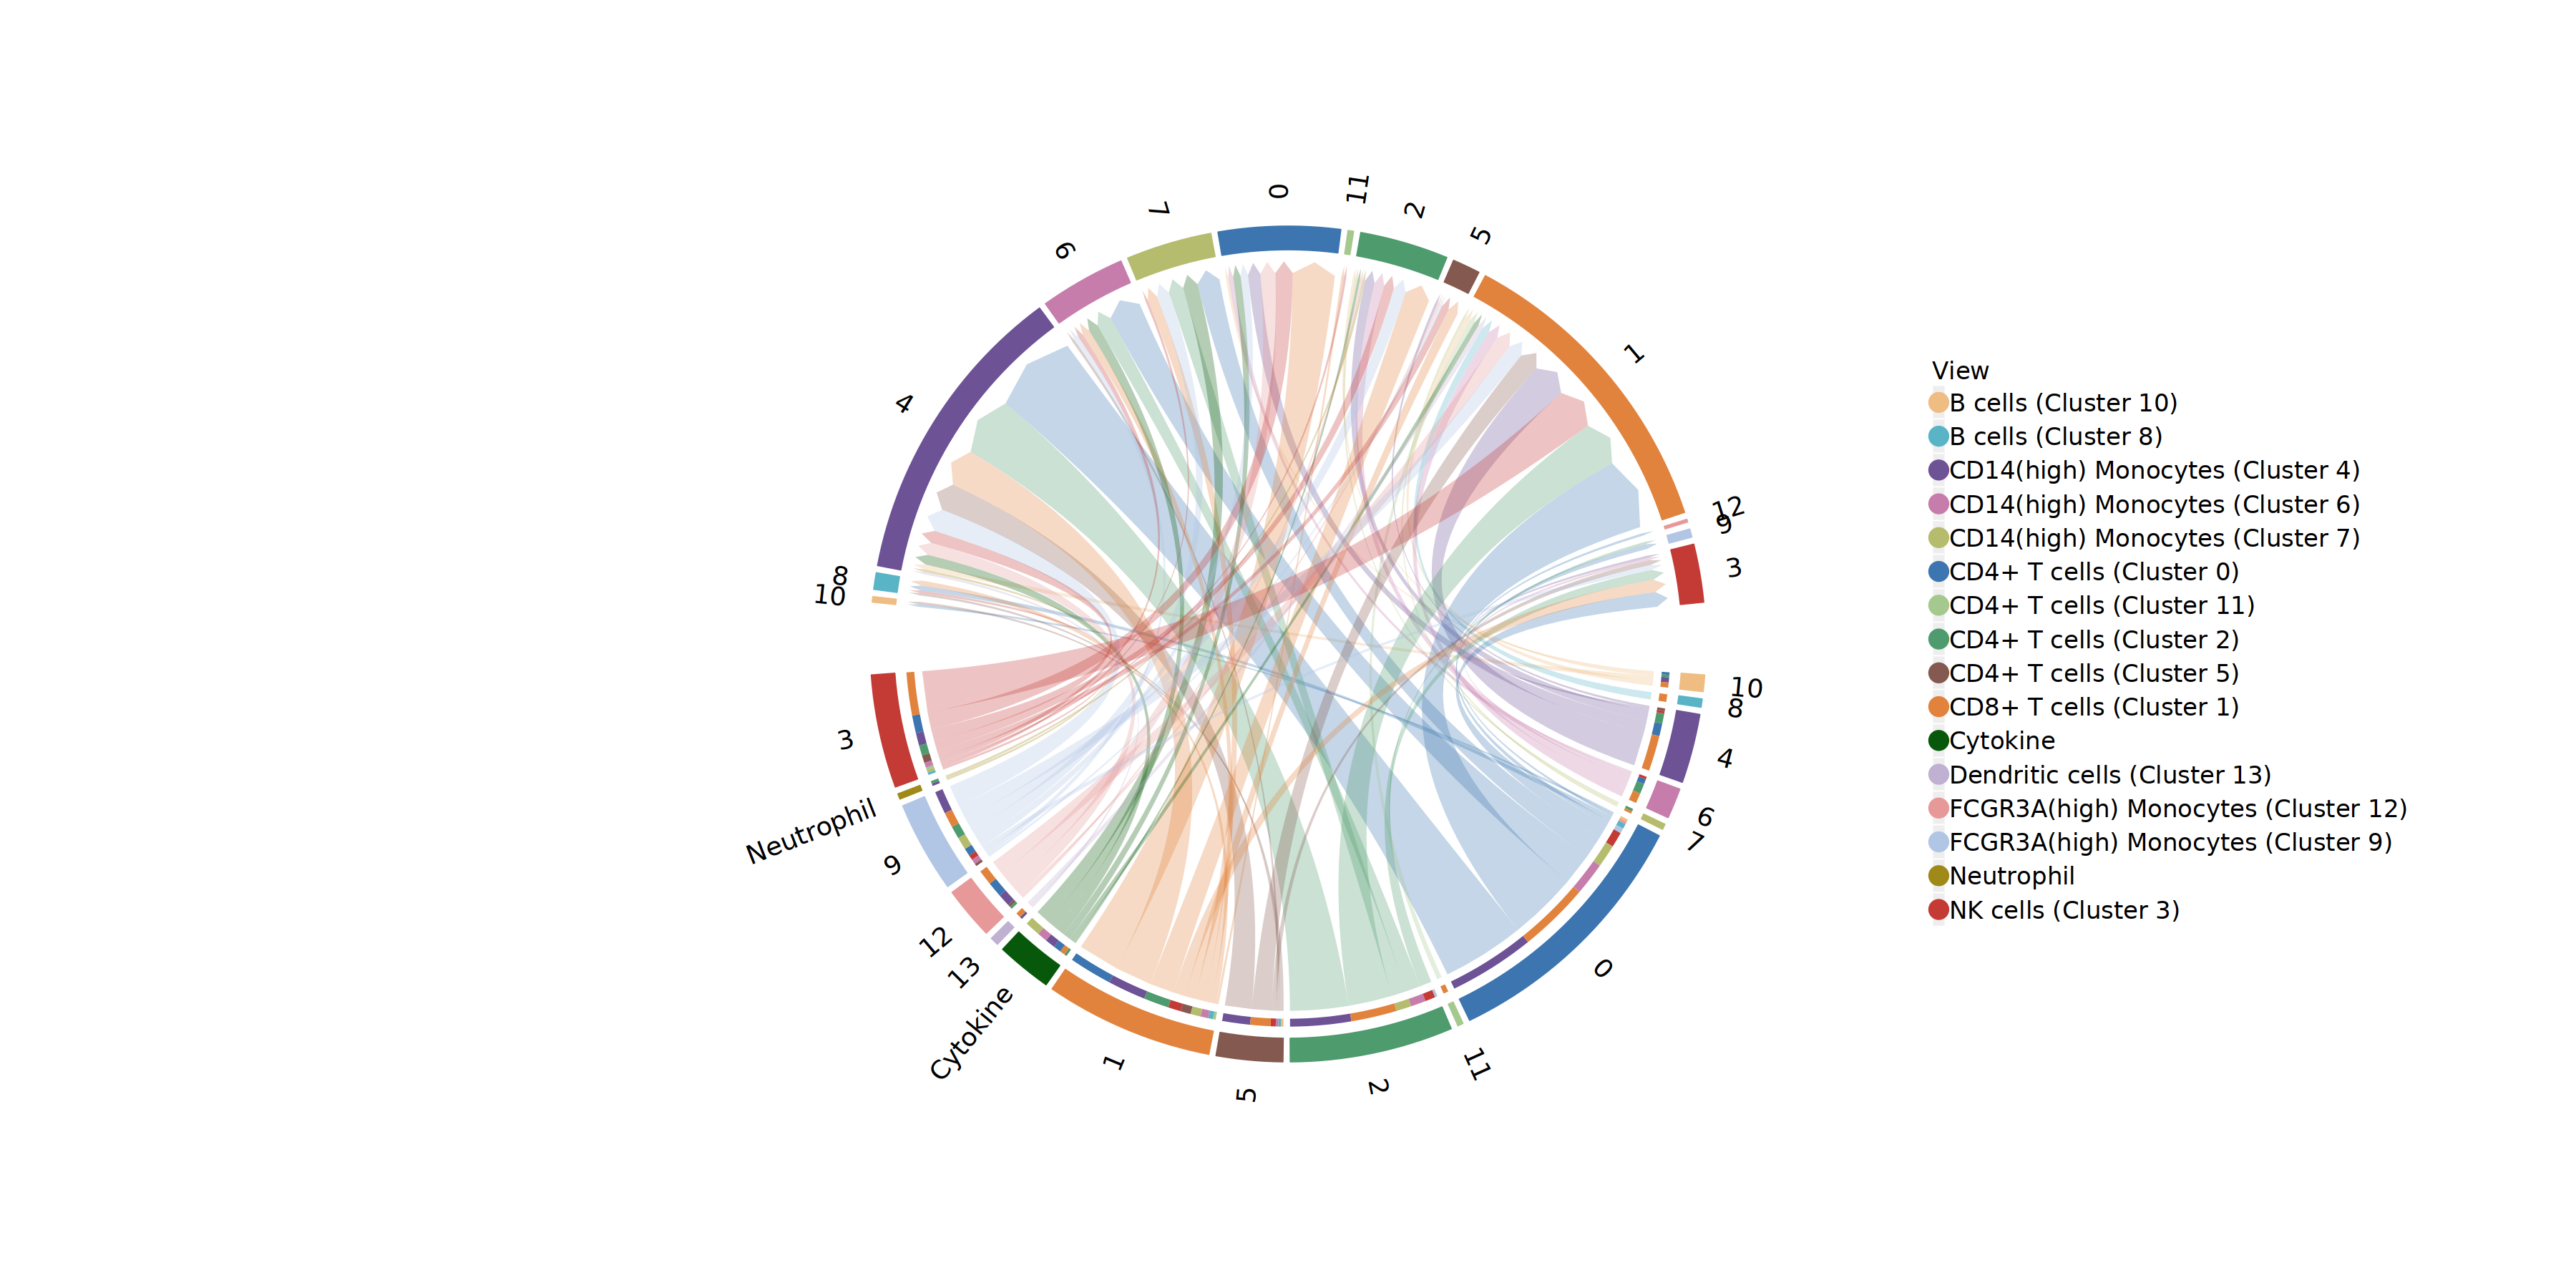

In [4221]:
options(repr.plot.width=30, repr.plot.height=15)
chordDiagram(links_circle, directional = 1, order=order,link.sort = TRUE, link.decreasing = FALSE,col = col_mat, grid.col = grid_col, transparency = transparency, direction.type = c("diffHeight", "arrows"),  link.arr.type = "big.arrow", annotationTrack = c( "grid"), preAllocateTracks = 1, title(
    main = paste0('' ), cex.main = 1.5))
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  # sector.name = 
  circos.text(mean(xlim), ylim[1] + .1, text$text[text$variable == get.cell.meta.data("sector.index")], facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5),  cex = 1.8)
  #circos.axis(h = "top", labels.cex = 0.5, major.tick.length = 0.2, sector.index = get.cell.meta.data("sector.index"), track.index = 2)
}, bg.border = NA)
### Add legend
draw(lgd_list_vertical, x = unit(1.5, "snpc"), just = "left")

In [ ]:
options(repr.plot.width=30, repr.plot.height=15)
if(use_thres == 'quant_new'){
    pdf(paste0('figures/Final_Figures/', figure_name, '_', factor, '_',name, '_', top_variable_fraction, '_', cor_thres,'_' ,str_replace(reg_pot_quant, '%', ''),geneset_oi_selection, filter_samples, weight_by_features,'.pdf'), 
        width = 4, 
        height = 4)
    }


chordDiagram(links_circle, directional = 1, 
             order=order,link.sort = TRUE, 
             link.decreasing = FALSE,
             col = col_mat, 
             grid.col = grid_col, 
             transparency = transparency, 
             direction.type = c("diffHeight", "arrows"),  
             link.arr.type = "big.arrow", 
             annotationTrack = c( "grid"), 
             preAllocateTracks = 1, 
             title(main = paste0('Top ', top_variable_fraction *100 *2, '% ', geneset_oi_selection, ' features' ), cex.main = 0.7))
circos.trackPlotRegion( track.height = 0.01, track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  # sector.name = 
  circos.text(mean(xlim), ylim[1] + .1, text$text[text$variable == get.cell.meta.data("sector.index")], cex = 0.5, facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
  #circos.axis(h = "top", labels.cex = 0.5, major.tick.length = 0.2, sector.index = get.cell.meta.data("sector.index"), track.index = 2)
}, bg.border = NA)
### Add legend
draw(lgd_list_vertical, x = unit(1.5, "snpc"), just = "left")

dev.off()

In [ ]:
top_variable_fraction